#Multilingual Content Moderation Pipeline

<img src="https://i.imgur.com/KNiZaxC.jpeg" width="1500">

*Image generated using AI*

This project focuses on building a robust pipeline for **detecting offensive content in multilingual tweets**, particularly in scenarios where users **mix languages** (e.g. English and Hindi) within the same text — a phenomenon common in social media platforms.

The pipeline includes:
- **Preprocessing**: Text cleaning, hashtag expansion, and back-translation for data augmentation
- **Modelling**: Fine-tuning and evaluating multilingual transformer models

### Models Compared
- `xlm-roberta-base`
- `distilbert-base-multilingual-cased`
- `ai4bharat/indic-bert`

The aim is to evaluate how well these models handle **code-mixed language** and **low-resource multilingual text** in the context of **offensive language detection**.

**Data Source**: [HASOC 2021 - Offensive Language Identification](https://github.com/Kalit31/HASOC-2021/tree/main)

In [2]:
# Mount Google Drive so we can access files stored there
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Install Google Cloud Translate client library
!pip install google-cloud-translate -q

# Install transformers, datasets, huggingface and optuna
!pip install transformers datasets huggingface_hub optuna -q

# Install contractions library to convert words from "don't" to "do not"
!pip install contractions -q

# Set the environment variable to authenticate with Google Cloud Translate (deleting key after assignment submission so don't even think about it 😡 )
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/gdrive/Shareddrives/NLP Assignment 3/data/sinuous-bedrock-459007-c0-0d066719d88a.json'

# Translation client
from google.cloud import translate_v2 as translate

# Data handling, modeling, and evaluation
import re
import time
import html
import random
import shutil
import contractions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# NLP utils and eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# PyTorch
import torch
from torch.nn import CrossEntropyLoss

# HuggingFace
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# Optuna
import optuna

# Start the Google Translate API client
translate_client = translate.Client()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.5 MB/s eta 0:00:00


# Loading and proprocessing data

### Load and Preview English and Hindi Datasets

This code loads two CSV files containing English and Hindi datasets using `pandas`, and combines the row counts to report the total number of data instances available. It then previews the first few rows of each dataset using `display()` to ensure the data has been loaded correctly.


In [ ]:
# Paths to CSV data files
eng_data = "/content/gdrive/Shareddrives/NLP Assignment 3/data/english_2021.csv"
hin_data = "/content/gdrive/Shareddrives/NLP Assignment 3/data/hindi_2021.csv"

# Load datasets into pandas DataFrames
eng_df = pd.read_csv(eng_data)
hin_df = pd.read_csv(hin_data)

# Counting number of rows of data available
hin_data_count = len(hin_df)
eng_data_count = len(eng_df)
data_count = len(eng_df) + len(hin_df)
print(f"Loaded {data_count} rows of data. English data rows: {eng_data_count}. Hindi data rows: {hin_data_count}")
print("\n")

# Count labels (HOF/NOT)
hof_count = (hin_df['task_1'] == 'HOF').sum() + (eng_df['task_1'] == 'HOF').sum()
not_count = (hin_df['task_1'] == 'NOT').sum() + (eng_df['task_1'] == 'NOT').sum()
print(f"HOF (Hateful or Offensive) count: {hof_count}")
print(f"NOT (Not HOF) count: {not_count}")
print("\n")

# Check for missing values in both datasets
missing_hin = hin_df.isnull().sum()
missing_eng = eng_df.isnull().sum()
print("Missing values in Hindi dataset:\\n", missing_hin)
print("\\nMissing values in English dataset:\\n", missing_eng)
print("\n")
print("Unique labels in Hindi:", hin_df['task_1'].unique())
print("Unique labels in English:", eng_df['task_1'].unique())
print("\n")
print("Empty/whitespace rows in Hindi:", hin_df['text'].str.strip().eq("").sum())
print("Empty/whitespace rows in English:", eng_df['text'].str.strip().eq("").sum())
print("\n")
print("Duplicate rows in Hindi:", hin_df.duplicated().sum())
print("Duplicate rows in English:", eng_df.duplicated().sum())
print("\n")
print("Non-string values in Hindi:", hin_df[~hin_df['text'].apply(lambda x: isinstance(x, str))].shape[0])
print("Non-string values in English:", eng_df[~eng_df['text'].apply(lambda x: isinstance(x, str))].shape[0])
print("\n")

# Quick preview of each dataset
display(eng_df.head())
display(hin_df.head())

Loaded 8437 rows of data. English data rows: 3843. Hindi data rows: 4594


HOF (Hateful or Offensive) count: 3934
NOT (Not HOF) count: 4503


Missing values in Hindi dataset:\n Unnamed: 0    0
_id           0
tweet_id      0
text          0
task_1        0
task_2        0
dtype: int64
\nMissing values in English dataset:\n Unnamed: 0    0
_id           0
text          0
task_1        0
task_2        0
dtype: int64


Unique labels in Hindi: ['NOT' 'HOF']
Unique labels in English: ['HOF' 'NOT']


Empty/whitespace rows in Hindi: 0
Empty/whitespace rows in English: 0


Duplicate rows in Hindi: 0
Duplicate rows in English: 0


Non-string values in Hindi: 0
Non-string values in English: 0




,Unnamed: 0,_id,text,task_1,task_2
0,4986,60c5d6bf5659ea5e55defa2c,@wealth if you made it through this &amp;&amp;...,HOF,PRFN
1,3394,60c5d6bf5659ea5e55def461,Technically that's still turning back the cloc...,HOF,OFFN
2,1310,60c5d6bf5659ea5e55defaad,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT,NONE
3,3390,60c5d6bf5659ea5e55def419,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF,OFFN
4,4626,60c5d6bf5659ea5e55def7fa,@blueheartedly You'd be better off asking who ...,HOF,OFFN


,Unnamed: 0,_id,tweet_id,text,task_1,task_2
0,998,60c5d7495659ea5e55df0b7b,hi_hasoc_2021_998,@rssurjewala #Hindus DYING #HindusLivesMatter ...,NOT,NONE
1,4049,60c5d7495659ea5e55df1b73,hi_hasoc_2021_4049,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,NOT,NONE
2,1757,60c5d7495659ea5e55df0d1b,hi_hasoc_2021_1757,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,NOT,NONE
3,5175,60c5d7495659ea5e55df0e45,hi_hasoc_2021_5178,@AskAnshul आसमानी किताब के नाजायज औलाद है।,HOF,OFFN
4,1825,60c5d7495659ea5e55df0ee1,hi_hasoc_2021_1825,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,NOT,NONE


### Clean Dataset by Dropping Irrelevant Columns

This code removes columns that are not useful for training the model from both English and Hindi datasets. These include identifiers like `_id`, `tweet_id`, and metadata such as `Unnamed: 0` or `task_2`, which are redundant to the classification task.


In [ ]:
# Remove unnecessary columns that aren't relevant for training
eng_df.drop(columns=['Unnamed: 0', '_id', 'task_2'], inplace=True)
hin_df.drop(columns=['Unnamed: 0', '_id', 'tweet_id', 'task_2'], inplace=True)

# Preview after cleanup
display(eng_df.head())
display(hin_df.head())

,text,task_1
0,@wealth if you made it through this &amp;&amp;...,HOF
1,Technically that's still turning back the cloc...,HOF
2,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT
3,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF
4,@blueheartedly You'd be better off asking who ...,HOF


,text,task_1
0,@rssurjewala #Hindus DYING #HindusLivesMatter ...,NOT
1,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,NOT
2,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,NOT
3,@AskAnshul आसमानी किताब के नाजायज औलाद है।,HOF
4,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,NOT


### Add Unique Identifiers and Standardise Language/Label Columns

To ensure traceability and facilitate multilingual processing, this block adds a unique `id` to each row and assigns a new `lang` column indicating the language of the entry (`'en'` for English, `'hi'` for Hindi). The columns are then reordered to place `id` and `lang` first for consistency. The label column (`task_1`) is also renamed to `label` in both datasets, preparing the data for modelling.


In [ ]:
# Add unique IDs and a language column to track language source
eng_df['id'] = range(0, len(eng_df))
hin_df['id'] = range(len(eng_df), len(eng_df) + len(hin_df))
eng_df['lang'] = 'en'
hin_df['lang'] = 'hi'

# Reorder columns so 'id' and 'lang' appear first
eng_df = eng_df[['id', 'lang'] + [col for col in eng_df.columns if col not in ['id', 'lang']]]
hin_df = hin_df[['id', 'lang'] + [col for col in hin_df.columns if col not in ['id', 'lang']]]

# Rename label column to something consistent
eng_df.rename(columns={'task_1': 'label'}, inplace=True)
hin_df.rename(columns={'task_1': 'label'}, inplace=True)

# Check that the format is what we expect
display(eng_df.head())
display(hin_df.head())

,id,lang,text,label
0,0,en,@wealth if you made it through this &amp;&amp;...,HOF
1,1,en,Technically that's still turning back the cloc...,HOF
2,2,en,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT
3,3,en,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF
4,4,en,@blueheartedly You'd be better off asking who ...,HOF


,id,lang,text,label
0,3843,hi,@rssurjewala #Hindus DYING #HindusLivesMatter ...,NOT
1,3844,hi,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,NOT
2,3845,hi,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,NOT
3,3846,hi,@AskAnshul आसमानी किताब के नाजायज औलाद है।,HOF
4,3847,hi,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,NOT


### Preprocess Text: Clean Noise and Expand Hashtags

This code cleans tweets from both English and Hindi datasets. It includes:

- **`split_hashtag`**: Transforms hashtags into readable text by inserting spaces between camel case transitions, digits and letters, and replacing underscores  
  (e.g. `#StopTheHate123` → `Stop The Hate 123`).

- **`clean_text`**:
  - Decodes HTML entities (e.g. `&amp;` → `&`)
  - Expands contractions (e.g. `don't` → `do not`)
  - Collapses repeated special characters (e.g. `!!` → `!`)
  - Replaces ampersands (`&`) with the word "and"
  - Removes URLs, user mentions (`@username`), and any non-ASCII or non-Devanagari characters
  - Expands hashtags using `split_hashtag`
  - Converts all text to lowercase
  - Removes punctuation
  - Adds a trailing space after "covid" to separate it in merged hashtags (e.g. `#CovidSucks` → `covid sucks`)
  - Normalises underscores and collapses extra whitespace

These cleaning steps reduce noise, handle social media-specific artifacts, and standardise inputs, improving interpretability.


In [ ]:
# Split hashtags into readable words (e.g. #NotCool → "Not Cool")
def split_hashtag(tag):
    """Split camelCase or snake_case hashtag into readable words."""
    tag = tag.replace("_", " ")
    tag = re.sub(r"([a-z])([A-Z])", r"\1 \2", tag)
    tag = re.sub(r"([A-Za-z])(\d)", r"\1 \2", tag)
    tag = re.sub(r"(\d)([A-Za-z])", r"\1 \2", tag)
    return tag

# Clean each tweet: expand contractins, decode html entities, remove non-roman characters, links, mentions, punctuations, and expand hashtags
def clean_text(text):
    """
    Clean tweet text: decode HTML, expand contractions, remove links/mentions,
    normalise punctuation/casing, and split hashtags.
    """
    text = html.unescape(text) # decodes HTML entities (i.e. '&amp;' -> '&')
    text = contractions.fix(text) # expands contractions (i.e. "don't" -> "do not")
    text = re.sub(r"([^\w\s])\1+", r"\1", text) # collapses repeated special characters (i.e. && -> &)
    text = re.sub(r"&", " and ", text) # replaces ampersands (&) with 'and'
    text = re.sub(r"[^\x20-\x7E\u0900-\u097F]", "", text) # removes any non-ASCII and non-Devanagari characters (mojibake characters were present)
    text = re.sub(r"http\S+|www\S+", "", text) # removes URLs
    text = re.sub(r"@\w+", "", text) # removes mentions (@'s)

    # expands hastags by splitting camelCase or snake_case instances (camelCase: "#CovidSucks" | snake_case: "#covid_sucks")
    hashtags = sorted(re.findall(r"#\w+", text), key=len, reverse=True)
    for tag in hashtags:
        tag_body = tag[1:]
        split = split_hashtag(tag_body)
        text = text.replace(tag, split)

    text = text.lower() # converts text to lowercase (e.g. "COVID" -> "covid")
    text = re.sub(r"[^\w\s]", "", text) # removes punctuation (e.g. "price: $1000" -> "price 1000")

    # Adds a trailing space after every instance of "covid" for hastags
    # that originally included "covid" or "COVID" before converting to lower case. Solving edge cases such as:
    # "#covidsucks" - hashtag splitting would result in "covidsucks", now --> "covid sucks"
    # "#COVIDSucks" - hashtag splitting would result in "COVIDSucks" ("covidsucks" after applying lowercase), now --> "covid sucks"
    text = re.sub(r"covid", "covid ", text)

    text = re.sub(r"_", " ", text) # normalises underscores (e.g. "covid_sucks" -> "covid sucks")
    text = re.sub(r"\s+", " ", text) # collapses multiple spaces (e.g. "covid   sucks" -> "covid sucks")
    text = text.strip() # strips edges (e.g. " covid " -> "covid")
    return text

# Apply cleaning to English and Hindi text
eng_df['text'] = eng_df['text'].astype(str).apply(clean_text)
hin_df['text'] = hin_df['text'].astype(str).apply(clean_text)

# Preview the cleaned text
display(eng_df.head())
display(hin_df.head())

,id,lang,text,label
0,0,en,if you made it through this and were not only ...,HOF
1,1,en,technically that is still turning back the clo...,HOF
2,2,en,and you are the govt stop thinking about world...,NOT
3,3,en,soldier of japan who has dick head,HOF
4,4,en,you would be better off asking who does not th...,HOF


,id,lang,text,label
0,3843,hi,hindus dying hindus lives matter kind attn pmn...,NOT
1,3844,hi,सब लग इतन पस डनट ह कर रह ह फर भ आम आदम क सलडर ...,NOT
2,3845,hi,शरए सवन शहबददन सहब स रशत कय justice for shahab...,NOT
3,3846,hi,आसमन कतब क नजयज औलद ह,HOF
4,3847,hi,इस कहत ह दगल पत जस सप क दम पर 0 स 10 क सफर कय ...,NOT


### Back-Translation for Data Augmentation

This block performs **back-translation**, a technique used to paraphrase text while preserving its semantic meaning. It uses the Google Translate API to translate each tweet from:
- English → Hindi → English
- Hindi → English → Hindi (only if Devanagari script is detected, to avoid translating Hinglish content)

A helper function `devanagari_detection` checks if the Hindi tweet is written in Devanagari script before translating it — this avoids corrupting Romanised Hindi. Each dataset is augmented by replacing the original text with its back-translated version to introduce linguistic diversity and potentially improve generalisation during model training.

Finally, the augmented datasets are saved as new CSV files for reuse.


In [ ]:
def devanagari_detection(text):
  """Check if the given text contains any Devanagari script characters."""
    return any('\u0900' <= ch <= '\u097F' for ch in text)

def back_translate(text, src_lang):
    """
    Perform back-translation for paraphrasing via Google Translate API.

    If the source language is Hindi ('hi'), only translate if Devanagari script is detected.
    - 'hi': HI → EN → HI
    - 'en': EN → HI → EN

    Returns the back-translated text. If translation fails, returns the original text.
    """
    try:
        if src_lang == 'hi':
            if not devanagari_detection(text):
                return text
            en = translate_client.translate(text, source_language='hi', target_language='en')['translatedText']
            return translate_client.translate(en, source_language='en', target_language='hi')['translatedText'].strip()
        else:
            hi = translate_client.translate(text, source_language='en', target_language='hi')['translatedText']
            return translate_client.translate(hi, source_language='hi', target_language='en')['translatedText'].strip()
    except Exception as e:
        print(e)
        return text

# Back translate English tweets
backtrans_eng_texts = []
for text in eng_df['text'].astype(str).tolist():
    translated_text = back_translate(text, 'en')
    backtrans_eng_texts.append(translated_text)
eng_df['text'] = backtrans_eng_texts

# Back translate Hindi tweets
backtrans_hin_texts = []
for text in hin_df['text'].astype(str).tolist():
    translated_text = back_translate(text, 'hi')
    backtrans_hin_texts.append(translated_text)
hin_df['text'] = backtrans_hin_texts

# Save these augmented datasets for reuse later
eng_df.to_csv("/content/gdrive/Shareddrives/NLP Assignment 3/data/english_preprocessed.csv", index=False)
hin_df.to_csv("/content/gdrive/Shareddrives/NLP Assignment 3/data/hindi_preprocessed.csv", index=False)

In [ ]:
# Load saved CSV's to skip back-translation in case runtime disconnects
eng_df = pd.read_csv("/content/gdrive/Shareddrives/NLP Assignment 3/data/english_preprocessed.csv")
hin_df = pd.read_csv("/content/gdrive/Shareddrives/NLP Assignment 3/data/hindi_preprocessed.csv")

### Prepare Dataset: Merge, Encode Labels, Balance Classes, and Split

This section prepares the final dataset for training, validation, and testing. These steps include:

- **Random seed** is set for reproducibility across data splits.
- **English and Hindi datasets** are merged into a unified DataFrame to create a multilingual corpus.
- **Label encoding** converts categorical labels (`'HOF'`, `'NOT'`) into integers using `LabelEncoder`, enabling compatibility with machine learning models.
- **Class weights** are computed using `compute_class_weight` to mitigate label imbalance, ensuring the model doesn't favour majority classes. These weights are converted into a tensor for later use in loss functions.
- The dataset is split:
  - **60% for training, 20% for validation** and **20% for testing**, stratifying on the label class to ensure even label distribution amongst the splits.
- The final text-label splits are converted into HuggingFace `Dataset` objects for integration with transformer models.


In [ ]:
# Set a fixed random seed for reproducibility
random_seed = 42

# Combine English and Hindi data into one unified DataFrame
# This will be used as the full dataset for training and evaluation
df = pd.concat([eng_df, hin_df], ignore_index=True)

# Encode labels into numerical format (e.g., 'HOF' → 0, 'NOT' → 1)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Compute class weights to address potential label imbalance in the dataset
labels = df['label'].values
weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Separate features and labels
X = df['text']
y = df['label']

# Split into train+val and test (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

# Further split train+val into 75% train and 25% validation → 60% train, 20% val, 20% test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=random_seed)

# Convert text and labels into HuggingFace Datasets
raw_train_ds = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
raw_val_ds = Dataset.from_dict({'text': X_val.tolist(), 'label': y_val.tolist()})
raw_test_ds = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

# Modelling

### Custom Trainer with Class Weights and Evaluation Metrics

To address class imbalance during training, a custom `WeightedTrainer` class was defined by subclassing HuggingFace’s `Trainer`. It overrides the `compute_loss` method to incorporate **class weights** into the cross-entropy loss function. This ensures that the model doesn't learn any unnecessary bias during optimisation.

Additionally, the `compute_metrics` function calculates key evaluation metrics:
- **Accuracy**: Overall correctness.
- **Precision**: Proportion of correctly predicted positive instances.
- **Recall**: Proportion of actual positives correctly identified.
- **F1 Score**: Harmonic mean of precision and recall.


In [ ]:
class WeightedTrainer(Trainer):
    """
    Custom Trainer that applies class weights to the CrossEntropyLoss
    for imbalanced classification tasks.
    """
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    """
    Compute evaluation metrics for classification:
    returns macro-averaged accuracy, precision, recall, and F1.
    """
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": p, "recall": r}

### Hyperparameter Tuning with Optuna for Transformer Models

This function implements **hyperparameter tuning** using **Optuna** with HuggingFace transformer models. It attempts to maximise classification performance on the data by tuning training parameters.



---


- **Tokenisation**: The selected model's tokeniser is applied to both training and validation datasets, with automatic padding and truncation for variable-length input.
- **Dynamic Data Collation**: `DataCollatorWithPadding` enables dynamic padding during batching to ensure all the data is of the same length when inputting into the model.
- **Model Initialisation**: A fresh instance of a pre-trained transformer is loaded and adapted for sequence classification using a `model_init()` function.
- **Search Space**: Hyperparameters such as learning rate, batch size, warm-up steps, number of epochs, optimiser settings (`beta1`, `beta2`, `epsilon`), gradient accumulation steps, and label smoothing are explored.
- **WeightedTrainer**: A custom subclass of `Trainer` is used to apply class weights during training, compensating for dataset imbalance.
- **Early Stopping**: Built-in early stopping is applied in each trial and final training to reduce overfitting.
- **Per-Trial Cleanup**: Non-best trial checkpoints are deleted immediately after training and evaluation to prevent Colab disk overflow, ensuring only the best model is retained.
- **Final Training**: After tuning, the best configuration is used to retrain the model from scratch and save the final model and tokeniser to disk.
- **Result Reporting**: The final macro F1 score and evaluation metrics are printed after training for benchmarking.



---



This pipeline is ideal for **offensive multilingual content classification** or other NLP tasks **content classification**. The cleanup protocols are particularly useful as I was running into memory issues.

It produces a fully trained, optimised model along with detailed evaluation metrics.

---

Generative AI was used to find a suitable framework to complete a grid search of hyperparameters. AI suggested optuna and gave a general guide on how to set it up. Here is a link to the AI prompt: https://chatgpt.com/share/682437fb-7b0c-8006-99f9-bdf63ee902e7


In [ ]:
def run_optuna_search(model_name, raw_train_ds, raw_val_ds, label_list, predefined_params=None):
    """
    Run Optuna hyperparameter search for a HuggingFace Transformer model.
    """
    # Load tokeniser and define padding logic
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Tokenisation function for input text
    def tokenize(batch):
        return tokenizer(batch["text"], padding=True, truncation=True)

    # Apply tokenization to training and validation datasets
    train_ds = raw_train_ds.map(tokenize, batched=True)
    val_ds = raw_val_ds.map(tokenize, batched=True)

    # Function to initialise the model for each trial
    def model_init():
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=len(label_list)
        )

    # If no predefined hyperparameters are provided, run Optuna search
    if predefined_params is None:
        best_f1 = 0.0
        best_trial_number = None
        best_hyperparams = None

        # Objective function to be optimised by Optuna
        def objective(trial):
            nonlocal best_f1, best_trial_number, best_hyperparams

            # Define hyperparameter search space
            hp = {
                "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
                "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.1]),
                "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
                "warmup_steps": trial.suggest_categorical("warmup_steps", [0, 100, 250, 500]),
                "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
                "adam_beta1": trial.suggest_float("adam_beta1", 0.85, 0.95),
                "adam_beta2": trial.suggest_float("adam_beta2", 0.95, 0.999),
                "adam_epsilon": trial.suggest_float("adam_epsilon", 1e-8, 1e-6, log=True),
                "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4]),
                "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "cosine_with_restarts", "polynomial"]),
                "label_smoothing_factor": trial.suggest_float("label_smoothing_factor", 0.0, 0.2),
            }

            # Output folder for trial
            output_dir = f"optuna_search/trial-{trial.number}"

            # Training arguments for current trial
            training_args = TrainingArguments(
                output_dir=output_dir,
                eval_strategy="epoch",
                save_strategy="epoch",
                logging_strategy="epoch",
                **hp,
                save_total_limit=1,
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                seed=random_seed,
                fp16=torch.cuda.is_available(),
                disable_tqdm=True,
                per_device_eval_batch_size=64,
                logging_dir=f"{output_dir}/logs"
            )

            # Initialise trainer with training args and datasets
            trainer = WeightedTrainer(
                model_init=model_init,
                args=training_args,
                train_dataset=train_ds,
                eval_dataset=val_ds,
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )

            # Train and evaluate the model
            trainer.train()
            metrics = trainer.evaluate()
            f1 = metrics["eval_f1"]

            # Save best results
            if f1 > best_f1:
                best_f1 = f1
                best_trial_number = trial.number
                best_hyperparams = hp

            # Clean up models from unsuccessful trials
            if trial.number != best_trial_number:
                shutil.rmtree(output_dir, ignore_errors=True)

            return f1  # Objective to maximise

        # Create TPESampler for reproducibility, Optuna study and start optimisation
        sampler = optuna.samplers.TPESampler(seed=42, multivariate=True, group=True)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=40)

        # Print best results
        print("\nBest Hyperparameters:")
        for k, v in best_hyperparams.items():
            print(f"{k}: {v}")
        print(f"Best F1: {best_f1:.4f}")

    else:
        # Use predefined parameters if provided
        best_hyperparams = predefined_params

    # Define final output directory
    best_output_dir = f"{model_name}_best"

    # Set up final training arguments using best hyperparameters
    final_args = TrainingArguments(
        output_dir=best_output_dir,
        **best_hyperparams,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=random_seed,
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        per_device_eval_batch_size=64,
        logging_dir=f"{best_output_dir}/logs"
    )

    # Final training using best configuration
    final_trainer = WeightedTrainer(
        model_init=model_init,
        args=final_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    final_trainer.train()
    final_eval = final_trainer.evaluate()

    # Print final evaluation results
    print("\nValidation Set Results:")
    for key, value in final_eval.items():
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

    # Save final model and tokeniser
    final_trainer.save_model(best_output_dir)
    tokenizer.save_pretrained(best_output_dir)

    return {
        "best_hyperparameters": best_hyperparams,
        "evaluation_metrics": final_eval
    }


### Fine-Tuning Multiple Transformer Models with Optuna Search

A list of multilingual transformer models is defined to evaluate, including:
- `xlm-roberta-base`: A strong general-purpose multilingual model.
- `distilbert-base-multilingual-cased`: A lightweight, efficient version of multilingual BERT.
- `ai4bharat/indic-bert`: A model specifically pre-trained on Indic languages (as well as english).

The loop iterates over each model name and performs:
- **Back-to-back fine-tuning** using the previously defined `run_optuna_search` function.
- **Automated hyperparameter optimisation** via Optuna for each model separately.
- **Evaluation and saving** of the best-performing model per architecture.

This allows for a comparative analysis of model performance across different multilingual pre-trained transformers.


In [ ]:
# List of model names to try fine-tuning on
models = [
    "xlm-roberta-base",
    "distilbert-base-multilingual-cased",
    "ai4bharat/indic-bert"
]

# Run fine-tuning loop across all models
for model_name in models:
    print(f"\n{model_name}")
    best = run_optuna_search(model_name, raw_train_ds, raw_val_ds, le.classes_.tolist())


xlm-roberta-base


Map:   0%|          | 0/5061 [00:00<?, ? examples/s]

Map:   0%|          | 0/1688 [00:00<?, ? examples/s]

[I 2025-05-12 14:03:27,937] A new study created in memory with name: no-name-8b187d37-e2c5-44af-9873-3532f751d0b2
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6288, 'grad_norm': 9.421112060546875, 'learning_rate': 1.1402485571255739e-05, 'epoch': 1.0}
{'eval_loss': 0.5130487084388733, 'eval_accuracy': 0.7713270142180095, 'eval_f1': 0.7713010087679273, 'eval_precision': 0.776511190571535, 'eval_recall': 0.7755846602744092, 'eval_runtime': 0.6502, 'eval_samples_per_second': 2596.21, 'eval_steps_per_second': 41.527, 'epoch': 1.0}
{'loss': 0.5164, 'grad_norm': 5.885914325714111, 'learning_rate': 7.666716656124895e-06, 'epoch': 2.0}
{'eval_loss': 0.4762418270111084, 'eval_accuracy': 0.7813981042654028, 'eval_f1': 0.7813421610150898, 'eval_precision': 0.7876077586206897, 'eval_recall': 0.7860636282994893, 'eval_runtime': 0.6655, 'eval_samples_per_second': 2536.486, 'eval_steps_per_second': 40.572, 'epoch': 2.0}
{'loss': 0.4584, 'grad_norm': 10.285442352294922, 'learning_rate': 3.895255681295349e-06, 'epoch': 3.0}
{'eval_loss': 0.491141140460968, 'eval_accuracy': 0.7879146919431279, 'eval_f1': 0.7878384451185261, 'eval_precision': 0.7891

[I 2025-05-12 14:06:31,753] Trial 0 finished with value: 0.7878384451185261 and parameters: {'learning_rate': 1.2163916178161389e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8755859523020287, 'adam_beta2': 0.957936037923716, 'adam_epsilon': 1.0269019949984133e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.16680111564321964}. Best is trial 0 with value: 0.7878384451185261.


{'eval_loss': 0.491141140460968, 'eval_accuracy': 0.7879146919431279, 'eval_f1': 0.7878384451185261, 'eval_precision': 0.7891686372699032, 'eval_recall': 0.7902387154185593, 'eval_runtime': 0.6768, 'eval_samples_per_second': 2494.138, 'eval_steps_per_second': 39.894, 'epoch': 3.9889415481832544}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6364, 'grad_norm': 16.38515281677246, 'learning_rate': 1.2659963119326328e-05, 'epoch': 1.0}
{'eval_loss': 0.5369513034820557, 'eval_accuracy': 0.726303317535545, 'eval_f1': 0.7226397620236525, 'eval_precision': 0.7592767985708455, 'eval_recall': 0.737428552490738, 'eval_runtime': 0.6352, 'eval_samples_per_second': 2657.301, 'eval_steps_per_second': 42.504, 'epoch': 1.0}
{'loss': 0.5345, 'grad_norm': 6.729859352111816, 'learning_rate': 2.5730964002267148e-05, 'epoch': 2.0}
{'eval_loss': 0.4722779393196106, 'eval_accuracy': 0.7890995260663507, 'eval_f1': 0.7873294007562213, 'eval_precision': 0.7890364148766515, 'eval_recall': 0.786525489820008, 'eval_runtime': 0.653, 'eval_samples_per_second': 2585.066, 'eval_steps_per_second': 41.349, 'epoch': 2.0}
{'loss': 0.4803, 'grad_norm': 15.692007064819336, 'learning_rate': 3.871975733248507e-05, 'epoch': 3.0}
{'eval_loss': 0.46508902311325073, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7793231418028466, 'eval_precision': 0.779

[I 2025-05-12 14:07:56,015] Trial 1 finished with value: 0.7873294007562213 and parameters: {'learning_rate': 4.110377636144912e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 32, 'warmup_steps': 500, 'num_train_epochs': 5, 'adam_beta1': 0.8548370140763988, 'adam_beta2': 0.9852657466025685, 'adam_epsilon': 1.149450752279312e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.17214955828119935}. Best is trial 0 with value: 0.7878384451185261.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newl

{'loss': 0.6151, 'grad_norm': 6.323467254638672, 'learning_rate': 2.2302989897181716e-05, 'epoch': 1.0}
{'eval_loss': 0.5041490197181702, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7754643985395316, 'eval_precision': 0.7781405761594998, 'eval_recall': 0.7785849973275494, 'eval_runtime': 0.6429, 'eval_samples_per_second': 2625.677, 'eval_steps_per_second': 41.998, 'epoch': 1.0}
{'loss': 0.5284, 'grad_norm': 1.7780476808547974, 'learning_rate': 2.5288094920101255e-05, 'epoch': 2.0}
{'eval_loss': 0.46907326579093933, 'eval_accuracy': 0.7956161137440758, 'eval_f1': 0.7953310196371304, 'eval_precision': 0.7953909869437035, 'eval_recall': 0.7967294563290541, 'eval_runtime': 0.6345, 'eval_samples_per_second': 2660.454, 'eval_steps_per_second': 42.555, 'epoch': 2.0}
{'loss': 0.4464, 'grad_norm': 5.536614894866943, 'learning_rate': 3.963651241395181e-07, 'epoch': 2.9921011058451814}
{'eval_loss': 0.4568566083908081, 'eval_accuracy': 0.7968009478672986, 'eval_f1': 0.795853417998328, 'eval

[I 2025-05-12 14:10:14,007] Trial 2 finished with value: 0.795853417998328 and parameters: {'learning_rate': 3.551431512290082e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 8, 'warmup_steps': 500, 'num_train_epochs': 3, 'adam_beta1': 0.8901108230579624, 'adam_beta2': 0.9534875934230428, 'adam_epsilon': 1.948953838642585e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.10874746201247015}. Best is trial 2 with value: 0.795853417998328.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4568566083908081, 'eval_accuracy': 0.7968009478672986, 'eval_f1': 0.795853417998328, 'eval_precision': 0.7958776933362672, 'eval_recall': 0.7958297077791583, 'eval_runtime': 0.6836, 'eval_samples_per_second': 2469.339, 'eval_steps_per_second': 39.498, 'epoch': 2.9921011058451814}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5936, 'grad_norm': 13.129279136657715, 'learning_rate': 1.4963015546236943e-05, 'epoch': 1.0}
{'eval_loss': 0.48906558752059937, 'eval_accuracy': 0.7748815165876777, 'eval_f1': 0.7739214533540295, 'eval_precision': 0.7738408827289166, 'eval_recall': 0.7740108054441839, 'eval_runtime': 0.6656, 'eval_samples_per_second': 2535.961, 'eval_steps_per_second': 40.563, 'epoch': 1.0}
{'loss': 0.5016, 'grad_norm': 3.136742115020752, 'learning_rate': 1.004510599049678e-05, 'epoch': 2.0}
{'eval_loss': 0.46547290682792664, 'eval_accuracy': 0.7885071090047393, 'eval_f1': 0.7884981273842027, 'eval_precision': 0.7931305389763068, 'eval_recall': 0.7925621256630004, 'eval_runtime': 0.6438, 'eval_samples_per_second': 2622.051, 'eval_steps_per_second': 41.94, 'epoch': 2.0}
{'loss': 0.4319, 'grad_norm': 11.555007934570312, 'learning_rate': 5.095971612180484e-06, 'epoch': 3.0}
{'eval_loss': 0.5014742612838745, 'eval_accuracy': 0.7968009478672986, 'eval_f1': 0.7964202017218616, 'eval_precision': 0

[I 2025-05-12 14:13:14,788] Trial 3 finished with value: 0.7964202017218616 and parameters: {'learning_rate': 1.8272846739306512e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 4, 'adam_beta1': 0.8644669807046899, 'adam_beta2': 0.9539514555435706, 'adam_epsilon': 2.691864108319155e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.07632439793510226}. Best is trial 3 with value: 0.7964202017218616.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.5014742612838745, 'eval_accuracy': 0.7968009478672986, 'eval_f1': 0.7964202017218616, 'eval_precision': 0.7962672733400742, 'eval_recall': 0.7975177940083515, 'eval_runtime': 0.6543, 'eval_samples_per_second': 2579.826, 'eval_steps_per_second': 41.265, 'epoch': 3.9889415481832544}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5875, 'grad_norm': 2.556758403778076, 'learning_rate': 2.5094181767489082e-05, 'epoch': 1.0}
{'eval_loss': 0.52120441198349, 'eval_accuracy': 0.7677725118483413, 'eval_f1': 0.7677672955974844, 'eval_precision': 0.770645199912668, 'eval_recall': 0.7709688655975924, 'eval_runtime': 0.6434, 'eval_samples_per_second': 2623.616, 'eval_steps_per_second': 41.965, 'epoch': 1.0}
{'loss': 0.5009, 'grad_norm': 5.722947597503662, 'learning_rate': 1.3342805811105728e-06, 'epoch': 1.9842271293375395}
{'eval_loss': 0.4722486734390259, 'eval_accuracy': 0.784952606635071, 'eval_f1': 0.7846332613855518, 'eval_precision': 0.7846581081384639, 'eval_recall': 0.7859367045228582, 'eval_runtime': 0.64, 'eval_samples_per_second': 2637.559, 'eval_steps_per_second': 42.188, 'epoch': 1.9842271293375395}
{'train_runtime': 52.7311, 'train_samples_per_second': 191.955, 'train_steps_per_second': 2.996, 'train_loss': 0.5447193580337718, 'epoch': 1.9842271293375395}
{'eval_loss': 0.4722486734390259, 'eval_ac

[I 2025-05-12 14:14:09,930] Trial 4 finished with value: 0.7846332613855518 and parameters: {'learning_rate': 4.885408295386759e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 16, 'warmup_steps': 0, 'num_train_epochs': 2, 'adam_beta1': 0.8901194611355209, 'adam_beta2': 0.9881145520208362, 'adam_epsilon': 5.92838369945402e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.03041398955195338}. Best is trial 3 with value: 0.7964202017218616.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are new

{'loss': 0.6731, 'grad_norm': 7.027419090270996, 'learning_rate': 9.75404143933562e-06, 'epoch': 1.0}
{'eval_loss': 0.577264130115509, 'eval_accuracy': 0.7008293838862559, 'eval_f1': 0.7007990368736301, 'eval_precision': 0.7028854595799284, 'eval_recall': 0.7033572749183105, 'eval_runtime': 0.6301, 'eval_samples_per_second': 2678.751, 'eval_steps_per_second': 42.847, 'epoch': 1.0}
{'loss': 0.5499, 'grad_norm': 5.944705009460449, 'learning_rate': 1.0746850233780877e-05, 'epoch': 2.0}
{'eval_loss': 0.4829968214035034, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 0.7700375836362309, 'eval_precision': 0.7772290805429118, 'eval_recall': 0.7751178628292438, 'eval_runtime': 0.6507, 'eval_samples_per_second': 2593.973, 'eval_steps_per_second': 41.491, 'epoch': 2.0}
{'loss': 0.504, 'grad_norm': 8.851909637451172, 'learning_rate': 3.909955442791782e-06, 'epoch': 3.0}
{'eval_loss': 0.4668590724468231, 'eval_accuracy': 0.7861374407582938, 'eval_f1': 0.7859853427030832, 'eval_precision': 0.78667

[I 2025-05-12 14:15:28,308] Trial 5 finished with value: 0.7859853427030832 and parameters: {'learning_rate': 1.2667586284851453e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 100, 'num_train_epochs': 4, 'adam_beta1': 0.9229861382866147, 'adam_beta2': 0.9555321109587673, 'adam_epsilon': 8.378574036234562e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.0976475883983766}. Best is trial 3 with value: 0.7964202017218616.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are new

{'loss': 0.6168, 'grad_norm': 11.168665885925293, 'learning_rate': 2.0996358039011034e-05, 'epoch': 1.0}
{'eval_loss': 0.5206325054168701, 'eval_accuracy': 0.7630331753554502, 'eval_f1': 0.7601206218105493, 'eval_precision': 0.7640402762704921, 'eval_recall': 0.7590535435003039, 'eval_runtime': 0.6701, 'eval_samples_per_second': 2519.169, 'eval_steps_per_second': 40.295, 'epoch': 1.0}
{'loss': 0.508, 'grad_norm': 7.752590656280518, 'learning_rate': 9.435266911759403e-06, 'epoch': 2.0}
{'eval_loss': 0.469700425863266, 'eval_accuracy': 0.792654028436019, 'eval_f1': 0.7926537373567213, 'eval_precision': 0.7964633105501125, 'eval_recall': 0.7963663133014708, 'eval_runtime': 0.6364, 'eval_samples_per_second': 2652.243, 'eval_steps_per_second': 42.423, 'epoch': 2.0}
{'loss': 0.425, 'grad_norm': 19.23312759399414, 'learning_rate': 5.266446950090669e-09, 'epoch': 3.0}
{'eval_loss': 0.4686954617500305, 'eval_accuracy': 0.79739336492891, 'eval_f1': 0.7969598278032962, 'eval_precision': 0.7967368

[I 2025-05-12 14:17:00,570] Trial 6 finished with value: 0.7969598278032962 and parameters: {'learning_rate': 2.140688782970674e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 16, 'warmup_steps': 250, 'num_train_epochs': 3, 'adam_beta1': 0.8622909944106082, 'adam_beta2': 0.9965067186372787, 'adam_epsilon': 8.597199157697101e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.13818274127494543}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4686954617500305, 'eval_accuracy': 0.79739336492891, 'eval_f1': 0.7969598278032962, 'eval_precision': 0.7967368783317765, 'eval_recall': 0.7979119628480003, 'eval_runtime': 0.6594, 'eval_samples_per_second': 2560.01, 'eval_steps_per_second': 40.948, 'epoch': 3.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6041, 'grad_norm': 7.113738059997559, 'learning_rate': 3.0166438512078353e-05, 'epoch': 1.0}
{'eval_loss': 0.5223957896232605, 'eval_accuracy': 0.7381516587677726, 'eval_f1': 0.7351399246843388, 'eval_precision': 0.7688317150969188, 'eval_recall': 0.7487684868006323, 'eval_runtime': 0.6299, 'eval_samples_per_second': 2679.921, 'eval_steps_per_second': 42.866, 'epoch': 1.0}
{'loss': 0.5419, 'grad_norm': 7.6694512367248535, 'learning_rate': 1.8886466460736733e-06, 'epoch': 2.0}
{'eval_loss': 0.4964049160480499, 'eval_accuracy': 0.7695497630331753, 'eval_f1': 0.7690692354088305, 'eval_precision': 0.7820199314496386, 'eval_recall': 0.7761706250431892, 'eval_runtime': 0.6417, 'eval_samples_per_second': 2630.341, 'eval_steps_per_second': 42.073, 'epoch': 2.0}
{'train_runtime': 62.4613, 'train_samples_per_second': 162.052, 'train_steps_per_second': 10.15, 'train_loss': 0.5729656038976242, 'epoch': 2.0}
{'eval_loss': 0.4964049160480499, 'eval_accuracy': 0.7695497630331753, 'eval_f1'

[I 2025-05-12 14:18:05,417] Trial 7 finished with value: 0.7690692354088305 and parameters: {'learning_rate': 4.803573011477445e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 2, 'adam_beta1': 0.8839579697099269, 'adam_beta2': 0.9834695227765562, 'adam_epsilon': 3.851844870123975e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.16828874890359763}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are

{'loss': 0.6913, 'grad_norm': 2.564788818359375, 'learning_rate': 9.163295394063527e-06, 'epoch': 0.9811320754716981}
{'eval_loss': 0.6223734617233276, 'eval_accuracy': 0.6789099526066351, 'eval_f1': 0.6757743671742881, 'eval_precision': 0.6775096187478139, 'eval_recall': 0.6753487230762938, 'eval_runtime': 0.6382, 'eval_samples_per_second': 2644.996, 'eval_steps_per_second': 42.307, 'epoch': 0.9811320754716981}
{'loss': 0.587, 'grad_norm': 7.652460098266602, 'learning_rate': 1.7844312083176342e-05, 'epoch': 1.9811320754716981}
{'eval_loss': 0.5176981687545776, 'eval_accuracy': 0.7494075829383886, 'eval_f1': 0.7482795272467677, 'eval_precision': 0.7670432930076847, 'eval_recall': 0.7573830855734205, 'eval_runtime': 0.6398, 'eval_samples_per_second': 2638.172, 'eval_steps_per_second': 42.198, 'epoch': 1.9811320754716981}
{'train_runtime': 34.6881, 'train_samples_per_second': 291.8, 'train_steps_per_second': 2.249, 'train_loss': 0.6391780804365109, 'epoch': 1.9811320754716981}
{'eval_los

[I 2025-05-12 14:18:42,542] Trial 8 finished with value: 0.7482795272467677 and parameters: {'learning_rate': 2.41139352475356e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 100, 'num_train_epochs': 2, 'adam_beta1': 0.8602578932686146, 'adam_beta2': 0.9507081825293817, 'adam_epsilon': 1.6252687981634883e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.158959826545784}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly

{'loss': 0.5808, 'grad_norm': 3.621155023574829, 'learning_rate': 1.591587723263422e-05, 'epoch': 1.0}
{'eval_loss': 0.4968704879283905, 'eval_accuracy': 0.768957345971564, 'eval_f1': 0.7664180121261667, 'eval_precision': 0.7695549110180113, 'eval_recall': 0.7654067836527817, 'eval_runtime': 0.6642, 'eval_samples_per_second': 2541.277, 'eval_steps_per_second': 40.648, 'epoch': 1.0}
{'loss': 0.4914, 'grad_norm': 8.035633087158203, 'learning_rate': 5.894769345420082e-07, 'epoch': 1.9842271293375395}
{'eval_loss': 0.46589475870132446, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7750532258092873, 'eval_precision': 0.7749325918436131, 'eval_recall': 0.7760930605130258, 'eval_runtime': 0.6442, 'eval_samples_per_second': 2620.481, 'eval_steps_per_second': 41.915, 'epoch': 1.9842271293375395}
{'train_runtime': 49.3642, 'train_samples_per_second': 205.047, 'train_steps_per_second': 3.201, 'train_loss': 0.5366967358166659, 'epoch': 1.9842271293375395}
{'eval_loss': 0.46589475870132446, 'ev

[I 2025-05-12 14:19:34,287] Trial 9 finished with value: 0.7750532258092873 and parameters: {'learning_rate': 3.104578521921243e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 0, 'num_train_epochs': 2, 'adam_beta1': 0.8748376599179193, 'adam_beta2': 0.9774929374364021, 'adam_epsilon': 5.208058189721321e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.17385083458287454}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly 

{'loss': 0.6089, 'grad_norm': 9.870415687561035, 'learning_rate': 1.78846324641358e-05, 'epoch': 1.0}
{'eval_loss': 0.5054540634155273, 'eval_accuracy': 0.7630331753554502, 'eval_f1': 0.7628250792807755, 'eval_precision': 0.7716807416887458, 'eval_recall': 0.7685389804071997, 'eval_runtime': 0.6473, 'eval_samples_per_second': 2607.581, 'eval_steps_per_second': 41.709, 'epoch': 1.0}
{'loss': 0.5079, 'grad_norm': 9.844346046447754, 'learning_rate': 7.955832406083502e-06, 'epoch': 2.0}
{'eval_loss': 0.4731485843658447, 'eval_accuracy': 0.7879146919431279, 'eval_f1': 0.7879146919431279, 'eval_precision': 0.7915248763550875, 'eval_recall': 0.7915248763550875, 'eval_runtime': 0.6393, 'eval_samples_per_second': 2640.444, 'eval_steps_per_second': 42.235, 'epoch': 2.0}
{'loss': 0.4185, 'grad_norm': 26.521207809448242, 'learning_rate': 2.2888384349671893e-09, 'epoch': 3.0}
{'eval_loss': 0.482596218585968, 'eval_accuracy': 0.7908767772511849, 'eval_f1': 0.7904849306350353, 'eval_precision': 0.790

[I 2025-05-12 14:21:06,220] Trial 10 finished with value: 0.7904849306350353 and parameters: {'learning_rate': 1.823432046281298e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 16, 'warmup_steps': 250, 'num_train_epochs': 3, 'adam_beta1': 0.913404632535913, 'adam_beta2': 0.9981492654138489, 'adam_epsilon': 2.3489302017709188e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.01347453058292547}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-ba

{'loss': 0.5978, 'grad_norm': 11.638314247131348, 'learning_rate': 1.744916405318301e-05, 'epoch': 1.0}
{'eval_loss': 0.49291929602622986, 'eval_accuracy': 0.7784360189573459, 'eval_f1': 0.7762193738656987, 'eval_precision': 0.7788175967657835, 'eval_recall': 0.775250427662614, 'eval_runtime': 0.6585, 'eval_samples_per_second': 2563.306, 'eval_steps_per_second': 41.001, 'epoch': 1.0}
{'loss': 0.5023, 'grad_norm': 4.320458889007568, 'learning_rate': 1.3175428349489476e-05, 'epoch': 2.0}
{'eval_loss': 0.4678020775318146, 'eval_accuracy': 0.7962085308056872, 'eval_f1': 0.7961853549641631, 'eval_precision': 0.7984060550213488, 'eval_recall': 0.7991332516320282, 'eval_runtime': 0.6392, 'eval_samples_per_second': 2640.602, 'eval_steps_per_second': 42.237, 'epoch': 2.0}
{'loss': 0.4361, 'grad_norm': 13.626559257507324, 'learning_rate': 7.152103635327195e-06, 'epoch': 3.0}
{'eval_loss': 0.4946773946285248, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7724961988636603, 'eval_precision': 0.

[I 2025-05-12 14:24:05,879] Trial 11 finished with value: 0.7961853549641631 and parameters: {'learning_rate': 1.836327003219829e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 5, 'adam_beta1': 0.9471275811434123, 'adam_beta2': 0.9661697793759623, 'adam_epsilon': 4.730126020914986e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.08781855379953499}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-bas

{'loss': 0.5999, 'grad_norm': 4.21232795715332, 'learning_rate': 2.130328533512098e-05, 'epoch': 1.0}
{'eval_loss': 0.5281887650489807, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.7615179970961685, 'eval_precision': 0.779208910758324, 'eval_recall': 0.7701544380308764, 'eval_runtime': 0.6483, 'eval_samples_per_second': 2603.926, 'eval_steps_per_second': 41.65, 'epoch': 1.0}
{'loss': 0.5071, 'grad_norm': 6.520579814910889, 'learning_rate': 1.3463121736868385e-05, 'epoch': 2.0}
{'eval_loss': 0.4907272160053253, 'eval_accuracy': 0.7914691943127962, 'eval_f1': 0.7890707092508762, 'eval_precision': 0.7927659934567496, 'eval_recall': 0.7878610100030039, 'eval_runtime': 0.6567, 'eval_samples_per_second': 2570.596, 'eval_steps_per_second': 41.117, 'epoch': 2.0}
{'loss': 0.4255, 'grad_norm': 24.444272994995117, 'learning_rate': 4.14683453453526e-06, 'epoch': 3.0}
{'eval_loss': 0.5427922010421753, 'eval_accuracy': 0.7867298578199052, 'eval_f1': 0.7865977426446316, 'eval_precision': 0.78742

[I 2025-05-12 14:27:33,699] Trial 12 finished with value: 0.791507772430963 and parameters: {'learning_rate': 2.2804862982471552e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8509937757605762, 'adam_beta2': 0.968674516804908, 'adam_epsilon': 5.517762874066458e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.05920349106691464}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-bas

{'loss': 0.6145, 'grad_norm': 5.518176078796387, 'learning_rate': 1.5875134638609052e-05, 'epoch': 1.0}
{'eval_loss': 0.5007212162017822, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7754700724214236, 'eval_precision': 0.7784516423511909, 'eval_recall': 0.7787457674446154, 'eval_runtime': 0.6522, 'eval_samples_per_second': 2588.123, 'eval_steps_per_second': 41.398, 'epoch': 1.0}
{'loss': 0.5122, 'grad_norm': 6.160147190093994, 'learning_rate': 7.0089911296066895e-06, 'epoch': 2.0}
{'eval_loss': 0.46660590171813965, 'eval_accuracy': 0.7914691943127962, 'eval_f1': 0.7914118010503552, 'eval_precision': 0.7978913958227853, 'eval_recall': 0.7962210560904375, 'eval_runtime': 0.6418, 'eval_samples_per_second': 2630.281, 'eval_steps_per_second': 42.072, 'epoch': 2.0}
{'loss': 0.4354, 'grad_norm': 6.028893947601318, 'learning_rate': 2.9531223172696193e-09, 'epoch': 2.9921011058451814}
{'eval_loss': 0.4785385727882385, 'eval_accuracy': 0.7962085308056872, 'eval_f1': 0.7959997582935525, 'eva

[I 2025-05-12 14:29:48,343] Trial 13 finished with value: 0.7959997582935525 and parameters: {'learning_rate': 1.6198560399575845e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 3, 'adam_beta1': 0.8675709314203409, 'adam_beta2': 0.9971762893392613, 'adam_epsilon': 2.4345828013711587e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.13256080258606026}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are ne

{'loss': 0.5997, 'grad_norm': 15.265664100646973, 'learning_rate': 2.16702409810265e-05, 'epoch': 1.0}
{'eval_loss': 0.4843302369117737, 'eval_accuracy': 0.7843601895734598, 'eval_f1': 0.7839449650968329, 'eval_precision': 0.7837951708243978, 'eval_recall': 0.7849798402734784, 'eval_runtime': 0.6396, 'eval_samples_per_second': 2639.109, 'eval_steps_per_second': 42.213, 'epoch': 1.0}
{'loss': 0.4912, 'grad_norm': 7.157354354858398, 'learning_rate': 1.4532862813482654e-05, 'epoch': 2.0}
{'eval_loss': 0.45578646659851074, 'eval_accuracy': 0.7962085308056872, 'eval_f1': 0.7961673256649893, 'eval_precision': 0.7979843851713961, 'eval_recall': 0.7988920964564292, 'eval_runtime': 0.6333, 'eval_samples_per_second': 2665.444, 'eval_steps_per_second': 42.634, 'epoch': 2.0}
{'loss': 0.4049, 'grad_norm': 21.490514755249023, 'learning_rate': 7.3728980061680995e-06, 'epoch': 3.0}
{'eval_loss': 0.5047149062156677, 'eval_accuracy': 0.7902843601895735, 'eval_f1': 0.7899230921754832, 'eval_precision': 0

[I 2025-05-12 14:31:52,978] Trial 14 finished with value: 0.7961673256649893 and parameters: {'learning_rate': 2.6481195252187383e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 4, 'adam_beta1': 0.9050522472716017, 'adam_beta2': 0.9649394914885664, 'adam_epsilon': 6.556205156285124e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.06397592477073387}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and ar

{'loss': 0.6678, 'grad_norm': 6.990504264831543, 'learning_rate': 6.350584418958797e-06, 'epoch': 1.0}
{'eval_loss': 0.5698009133338928, 'eval_accuracy': 0.7209715639810427, 'eval_f1': 0.716282779404444, 'eval_precision': 0.7225687891708021, 'eval_recall': 0.7155532395883721, 'eval_runtime': 0.6338, 'eval_samples_per_second': 2663.254, 'eval_steps_per_second': 42.599, 'epoch': 1.0}
{'loss': 0.5484, 'grad_norm': 5.262779712677002, 'learning_rate': 8.314604064534337e-06, 'epoch': 2.0}
{'eval_loss': 0.48812776803970337, 'eval_accuracy': 0.7742890995260664, 'eval_f1': 0.774287119132677, 'eval_precision': 0.7782713142844238, 'eval_recall': 0.7780378148238509, 'eval_runtime': 0.6338, 'eval_samples_per_second': 2663.156, 'eval_steps_per_second': 42.598, 'epoch': 2.0}
{'loss': 0.4946, 'grad_norm': 9.625677108764648, 'learning_rate': 8.056970996769229e-09, 'epoch': 2.9842271293375395}
{'eval_loss': 0.48595577478408813, 'eval_accuracy': 0.7790284360189573, 'eval_f1': 0.7787002933796443, 'eval_pr

[I 2025-05-12 14:33:16,276] Trial 15 finished with value: 0.7787002933796443 and parameters: {'learning_rate': 1.0242878095094833e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 250, 'num_train_epochs': 3, 'adam_beta1': 0.8641889033502269, 'adam_beta2': 0.9757642274449456, 'adam_epsilon': 1.0041555756303558e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.12531031010471186}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta

{'loss': 0.5958, 'grad_norm': 9.09505844116211, 'learning_rate': 1.2651186493751045e-05, 'epoch': 1.0}
{'eval_loss': 0.5084899663925171, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7796010512837792, 'eval_precision': 0.784671156014014, 'eval_recall': 0.7838361160196139, 'eval_runtime': 0.637, 'eval_samples_per_second': 2649.837, 'eval_steps_per_second': 42.385, 'epoch': 1.0}
{'loss': 0.4984, 'grad_norm': 6.8555378913879395, 'learning_rate': 9.524521194558825e-06, 'epoch': 2.0}
{'eval_loss': 0.4885820150375366, 'eval_accuracy': 0.79739336492891, 'eval_f1': 0.7944497852976992, 'eval_precision': 0.8004602848790197, 'eval_recall': 0.7929280892189534, 'eval_runtime': 0.6364, 'eval_samples_per_second': 2652.297, 'eval_steps_per_second': 42.424, 'epoch': 2.0}
{'loss': 0.4313, 'grad_norm': 26.84432029724121, 'learning_rate': 6.392908640146364e-06, 'epoch': 3.0}
{'eval_loss': 0.5143423676490784, 'eval_accuracy': 0.7861374407582938, 'eval_f1': 0.7860742993776029, 'eval_precision': 0.787574

[I 2025-05-12 14:36:40,243] Trial 16 finished with value: 0.7944497852976992 and parameters: {'learning_rate': 1.5263337250038215e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 5, 'adam_beta1': 0.8788848463720886, 'adam_beta2': 0.991783450890181, 'adam_epsilon': 2.640909787490712e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.1992664724227173}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are n

{'loss': 0.5799, 'grad_norm': 4.022329807281494, 'learning_rate': 1.7237063866292352e-05, 'epoch': 1.0}
{'eval_loss': 0.4857659339904785, 'eval_accuracy': 0.7636255924170616, 'eval_f1': 0.7631826836356348, 'eval_precision': 0.7753596305051795, 'eval_recall': 0.7700585400663107, 'eval_runtime': 0.6499, 'eval_samples_per_second': 2597.437, 'eval_steps_per_second': 41.547, 'epoch': 1.0}
{'loss': 0.4925, 'grad_norm': 5.0728373527526855, 'learning_rate': 1.0126631272913677e-05, 'epoch': 2.0}
{'eval_loss': 0.46345752477645874, 'eval_accuracy': 0.7873222748815166, 'eval_f1': 0.7873096598138057, 'eval_precision': 0.7921324331812347, 'eval_recall': 0.7914522477495709, 'eval_runtime': 0.6445, 'eval_samples_per_second': 2619.165, 'eval_steps_per_second': 41.894, 'epoch': 2.0}
{'loss': 0.4069, 'grad_norm': 10.07871150970459, 'learning_rate': 2.9690821000874455e-06, 'epoch': 3.0}
{'eval_loss': 0.507056474685669, 'eval_accuracy': 0.7855450236966824, 'eval_f1': 0.7852166687522056, 'eval_precision': 0

[I 2025-05-12 14:39:40,119] Trial 17 finished with value: 0.7873096598138057 and parameters: {'learning_rate': 2.015308450549332e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.8990975019683104, 'adam_beta2': 0.9600809570166652, 'adam_epsilon': 2.3036332479375665e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.07506462118116625}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base

{'loss': 0.5907, 'grad_norm': 13.652923583984375, 'learning_rate': 2.4451565550839856e-05, 'epoch': 1.0}
{'eval_loss': 0.4721633493900299, 'eval_accuracy': 0.7813981042654028, 'eval_f1': 0.7811122555588004, 'eval_precision': 0.7812443845462713, 'eval_recall': 0.7825266857240367, 'eval_runtime': 0.6453, 'eval_samples_per_second': 2615.976, 'eval_steps_per_second': 41.843, 'epoch': 1.0}
{'loss': 0.5008, 'grad_norm': 26.584318161010742, 'learning_rate': 9.106052269439911e-06, 'epoch': 2.0}
{'eval_loss': 0.48464885354042053, 'eval_accuracy': 0.7760663507109005, 'eval_f1': 0.7757830641125836, 'eval_precision': 0.7862482770268819, 'eval_recall': 0.7820337983914527, 'eval_runtime': 0.6389, 'eval_samples_per_second': 2642.062, 'eval_steps_per_second': 42.26, 'epoch': 2.0}
{'loss': 0.4187, 'grad_norm': 15.64554214477539, 'learning_rate': 6.229427871775657e-09, 'epoch': 3.0}
{'eval_loss': 0.47882381081581116, 'eval_accuracy': 0.7962085308056872, 'eval_f1': 0.7952415610207455, 'eval_precision': 0

[I 2025-05-12 14:41:16,157] Trial 18 finished with value: 0.7952415610207455 and parameters: {'learning_rate': 2.8570584170972665e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.9269783983244738, 'adam_beta2': 0.9715799634606495, 'adam_epsilon': 7.878653002259053e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.042464824669639946}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are 

{'loss': 0.7077, 'grad_norm': 2.9954519271850586, 'learning_rate': 2.2337729392544244e-06, 'epoch': 0.9811320754716981}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6967170238494873, 'eval_accuracy': 0.4662322274881517, 'eval_f1': 0.317979797979798, 'eval_precision': 0.23311611374407584, 'eval_recall': 0.5, 'eval_runtime': 0.6423, 'eval_samples_per_second': 2628.241, 'eval_steps_per_second': 42.039, 'epoch': 0.9811320754716981}
{'loss': 0.6752, 'grad_norm': 3.1095805168151855, 'learning_rate': 4.526329376910281e-06, 'epoch': 1.9811320754716981}
{'eval_loss': 0.6143624782562256, 'eval_accuracy': 0.6872037914691943, 'eval_f1': 0.6871967654986523, 'eval_precision': 0.6909368728913969, 'eval_recall': 0.690674063972404, 'eval_runtime': 0.6479, 'eval_samples_per_second': 2605.353, 'eval_steps_per_second': 41.673, 'epoch': 1.9811320754716981}
{'loss': 0.612, 'grad_norm': 4.226070880889893, 'learning_rate': 6.760102316164706e-06, 'epoch': 2.981132075471698}
{'eval_loss': 0.5386582612991333, 'eval_accuracy': 0.7298578199052133, 'eval_f1': 0.7298544067542014, 'eval_precision': 0.7327481383896807, 'eval_recall': 0.7329608355533243, 'eval_runt

[I 2025-05-12 14:42:31,163] Trial 19 finished with value: 0.7545125946007003 and parameters: {'learning_rate': 1.4695874600358056e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 32, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8645553447571406, 'adam_beta2': 0.9613665273857692, 'adam_epsilon': 1.0730189167123248e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.13471057632904412}. Best is trial 6 with value: 0.7969598278032962.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-

{'loss': 0.5913, 'grad_norm': 8.682401657104492, 'learning_rate': 1.5685684485790686e-05, 'epoch': 1.0}
{'eval_loss': 0.4911617040634155, 'eval_accuracy': 0.759478672985782, 'eval_f1': 0.7587304806041737, 'eval_precision': 0.7743000717875089, 'eval_recall': 0.7667366627790384, 'eval_runtime': 0.6299, 'eval_samples_per_second': 2679.637, 'eval_steps_per_second': 42.861, 'epoch': 1.0}
{'loss': 0.4914, 'grad_norm': 8.156763076782227, 'learning_rate': 7.95381909925603e-06, 'epoch': 2.0}
{'eval_loss': 0.45283833146095276, 'eval_accuracy': 0.7997630331753555, 'eval_f1': 0.7992419284237432, 'eval_precision': 0.7989557199980323, 'eval_recall': 0.7999709485577933, 'eval_runtime': 0.6355, 'eval_samples_per_second': 2656.344, 'eval_steps_per_second': 42.489, 'epoch': 2.0}
{'loss': 0.4147, 'grad_norm': 21.711210250854492, 'learning_rate': 2.2195371272136673e-07, 'epoch': 3.0}
{'eval_loss': 0.4893409013748169, 'eval_accuracy': 0.7885071090047393, 'eval_f1': 0.7879175328699739, 'eval_precision': 0.7

[I 2025-05-12 14:44:04,476] Trial 20 finished with value: 0.7992419284237432 and parameters: {'learning_rate': 2.0856521905176643e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.8524638726782257, 'adam_beta2': 0.9796537634211028, 'adam_epsilon': 3.374369216426795e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.11187986994691718}. Best is trial 20 with value: 0.7992419284237432.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.45283833146095276, 'eval_accuracy': 0.7997630331753555, 'eval_f1': 0.7992419284237432, 'eval_precision': 0.7989557199980323, 'eval_recall': 0.7999709485577933, 'eval_runtime': 0.6436, 'eval_samples_per_second': 2622.845, 'eval_steps_per_second': 41.953, 'epoch': 3.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5942, 'grad_norm': 29.854528427124023, 'learning_rate': 1.557861833990695e-05, 'epoch': 1.0}
{'eval_loss': 0.4911644160747528, 'eval_accuracy': 0.7582938388625592, 'eval_f1': 0.7575095206976588, 'eval_precision': 0.7733997941726772, 'eval_recall': 0.7656267848656089, 'eval_runtime': 0.6358, 'eval_samples_per_second': 2654.92, 'eval_steps_per_second': 42.466, 'epoch': 1.0}
{'loss': 0.4816, 'grad_norm': 12.93538761138916, 'learning_rate': 7.912092641771221e-06, 'epoch': 2.0}
{'eval_loss': 0.46275845170021057, 'eval_accuracy': 0.7938388625592417, 'eval_f1': 0.7938362577861011, 'eval_precision': 0.7980199529340017, 'eval_recall': 0.7977173463904994, 'eval_runtime': 0.6351, 'eval_samples_per_second': 2657.79, 'eval_steps_per_second': 42.512, 'epoch': 2.0}
{'loss': 0.4073, 'grad_norm': 18.7038516998291, 'learning_rate': 2.2130578636290698e-07, 'epoch': 3.0}
{'eval_loss': 0.4841189384460449, 'eval_accuracy': 0.7867298578199052, 'eval_f1': 0.786094449607164, 'eval_precision': 0.7858

[I 2025-05-12 14:45:36,999] Trial 21 finished with value: 0.7938362577861011 and parameters: {'learning_rate': 2.0746244838966793e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.8561803423284401, 'adam_beta2': 0.9818979173712771, 'adam_epsilon': 3.1226774156670264e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.11959921603136331}. Best is trial 20 with value: 0.7992419284237432.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and

{'loss': 0.5908, 'grad_norm': 25.15877342224121, 'learning_rate': 1.3772378962669604e-05, 'epoch': 1.0}
{'eval_loss': 0.5035487413406372, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7778192934782608, 'eval_precision': 0.7793593445858233, 'eval_recall': 0.7770837711028407, 'eval_runtime': 0.6472, 'eval_samples_per_second': 2607.987, 'eval_steps_per_second': 41.715, 'epoch': 1.0}
{'loss': 0.4887, 'grad_norm': 7.787574768066406, 'learning_rate': 6.98968079183038e-06, 'epoch': 2.0}
{'eval_loss': 0.47044637799263, 'eval_accuracy': 0.7813981042654028, 'eval_f1': 0.7813974137825141, 'eval_precision': 0.7847241408474528, 'eval_recall': 0.7848578524214942, 'eval_runtime': 0.6415, 'eval_samples_per_second': 2631.479, 'eval_steps_per_second': 42.091, 'epoch': 2.0}
{'loss': 0.418, 'grad_norm': 28.228696823120117, 'learning_rate': 2.7117219358584735e-07, 'epoch': 3.0}
{'eval_loss': 0.48935848474502563, 'eval_accuracy': 0.7902843601895735, 'eval_f1': 0.789788293897883, 'eval_precision': 0.7895

[I 2025-05-12 14:47:13,587] Trial 22 finished with value: 0.789788293897883 and parameters: {'learning_rate': 1.8308442092694574e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.8710453819595462, 'adam_beta2': 0.9930510060201282, 'adam_epsilon': 1.4775116392243076e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.14607132646416104}. Best is trial 20 with value: 0.7992419284237432.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and 

{'loss': 0.595, 'grad_norm': 66.34188079833984, 'learning_rate': 1.8418727065041777e-05, 'epoch': 1.0}
{'eval_loss': 0.4884870648384094, 'eval_accuracy': 0.768957345971564, 'eval_f1': 0.7686650661479038, 'eval_precision': 0.7789999813926061, 'eval_recall': 0.7748922205596775, 'eval_runtime': 0.6542, 'eval_samples_per_second': 2580.059, 'eval_steps_per_second': 41.269, 'epoch': 1.0}
{'loss': 0.4929, 'grad_norm': 7.187110900878906, 'learning_rate': 9.31678900921381e-06, 'epoch': 2.0}
{'eval_loss': 0.4541196823120117, 'eval_accuracy': 0.7997630331753555, 'eval_f1': 0.7993980648064807, 'eval_precision': 0.7992574191383085, 'eval_recall': 0.8005336439675245, 'eval_runtime': 0.6393, 'eval_samples_per_second': 2640.525, 'eval_steps_per_second': 42.236, 'epoch': 2.0}
{'loss': 0.4095, 'grad_norm': 20.513214111328125, 'learning_rate': 2.4356369173230216e-07, 'epoch': 3.0}
{'eval_loss': 0.46902936697006226, 'eval_accuracy': 0.7962085308056872, 'eval_f1': 0.7958772743890435, 'eval_precision': 0.79

[I 2025-05-12 14:48:44,683] Trial 23 finished with value: 0.7993980648064807 and parameters: {'learning_rate': 2.4534540332837856e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.8527636952750518, 'adam_beta2': 0.9790399250426908, 'adam_epsilon': 3.3795597718775974e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.09139418943354574}. Best is trial 23 with value: 0.7993980648064807.


{'eval_loss': 0.4541196823120117, 'eval_accuracy': 0.7997630331753555, 'eval_f1': 0.7993980648064807, 'eval_precision': 0.7992574191383085, 'eval_recall': 0.8005336439675245, 'eval_runtime': 0.656, 'eval_samples_per_second': 2573.174, 'eval_steps_per_second': 41.159, 'epoch': 3.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5948, 'grad_norm': 22.72905731201172, 'learning_rate': 1.8773815861900077e-05, 'epoch': 1.0}
{'eval_loss': 0.4950720965862274, 'eval_accuracy': 0.7523696682464455, 'eval_f1': 0.7509375352987688, 'eval_precision': 0.7728823157270712, 'eval_recall': 0.7609616309423244, 'eval_runtime': 0.6361, 'eval_samples_per_second': 2653.486, 'eval_steps_per_second': 42.443, 'epoch': 1.0}
{'loss': 0.4928, 'grad_norm': 11.095316886901855, 'learning_rate': 9.55398514638515e-06, 'epoch': 2.0}
{'eval_loss': 0.4701991081237793, 'eval_accuracy': 0.7861374407582938, 'eval_f1': 0.7860977283537189, 'eval_precision': 0.7879650721336371, 'eval_recall': 0.7888150537240142, 'eval_runtime': 0.6428, 'eval_samples_per_second': 2626.067, 'eval_steps_per_second': 42.005, 'epoch': 2.0}
{'loss': 0.4171, 'grad_norm': 21.025463104248047, 'learning_rate': 2.75615823152664e-07, 'epoch': 3.0}
{'eval_loss': 0.4823976159095764, 'eval_accuracy': 0.794431279620853, 'eval_f1': 0.7938320973522939, 'eval_precision': 0.793

[I 2025-05-12 14:50:17,788] Trial 24 finished with value: 0.7938320973522939 and parameters: {'learning_rate': 2.5008177583819698e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.8513308501400199, 'adam_beta2': 0.979987011813941, 'adam_epsilon': 4.25778676161665e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.10627864109409951}. Best is trial 23 with value: 0.7993980648064807.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and ar

{'loss': 0.6071, 'grad_norm': 12.777227401733398, 'learning_rate': 2.623808009376577e-05, 'epoch': 1.0}
{'eval_loss': 0.49238479137420654, 'eval_accuracy': 0.759478672985782, 'eval_f1': 0.7568351613415991, 'eval_precision': 0.7598839832420239, 'eval_recall': 0.7558846798770813, 'eval_runtime': 0.6502, 'eval_samples_per_second': 2595.929, 'eval_steps_per_second': 41.523, 'epoch': 1.0}
{'loss': 0.4977, 'grad_norm': 9.563517570495605, 'learning_rate': 5.058708089094075e-07, 'epoch': 2.0}
{'eval_loss': 0.47175121307373047, 'eval_accuracy': 0.7879146919431279, 'eval_f1': 0.7878643632743444, 'eval_precision': 0.7940794985307188, 'eval_recall': 0.7925698821160168, 'eval_runtime': 0.642, 'eval_samples_per_second': 2629.169, 'eval_steps_per_second': 42.054, 'epoch': 2.0}
{'train_runtime': 60.9309, 'train_samples_per_second': 166.123, 'train_steps_per_second': 10.405, 'train_loss': 0.5523991629904377, 'epoch': 2.0}
{'eval_loss': 0.47175121307373047, 'eval_accuracy': 0.7879146919431279, 'eval_f1'

[I 2025-05-12 14:51:21,147] Trial 25 finished with value: 0.7878643632743444 and parameters: {'learning_rate': 3.127087812424241e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 16, 'warmup_steps': 250, 'num_train_epochs': 2, 'adam_beta1': 0.8501785934486464, 'adam_beta2': 0.9726389433835627, 'adam_epsilon': 9.577666429982576e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.09240030077399394}. Best is trial 23 with value: 0.7993980648064807.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and ar

{'loss': 0.5843, 'grad_norm': 8.336485862731934, 'learning_rate': 1.6260689287713973e-05, 'epoch': 1.0}
{'eval_loss': 0.4923865497112274, 'eval_accuracy': 0.768957345971564, 'eval_f1': 0.7687378804485288, 'eval_precision': 0.7779543296857043, 'eval_recall': 0.7745706803255454, 'eval_runtime': 0.6336, 'eval_samples_per_second': 2664.246, 'eval_steps_per_second': 42.615, 'epoch': 1.0}
{'loss': 0.4946, 'grad_norm': 9.538061141967773, 'learning_rate': 5.564958480506138e-06, 'epoch': 2.0}
{'eval_loss': 0.4728742837905884, 'eval_accuracy': 0.784952606635071, 'eval_f1': 0.7848256623062491, 'eval_precision': 0.7928214454443514, 'eval_recall': 0.7901971126251081, 'eval_runtime': 0.6475, 'eval_samples_per_second': 2606.988, 'eval_steps_per_second': 41.699, 'epoch': 2.0}
{'loss': 0.4253, 'grad_norm': 15.291380882263184, 'learning_rate': 2.860302941814707e-09, 'epoch': 3.0}
{'eval_loss': 0.4746529757976532, 'eval_accuracy': 0.7896919431279621, 'eval_f1': 0.7896458022009191, 'eval_precision': 0.791

[I 2025-05-12 14:52:54,058] Trial 26 finished with value: 0.7896458022009191 and parameters: {'learning_rate': 2.13971822202993e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8592934156163953, 'adam_beta2': 0.9868368886149652, 'adam_epsilon': 1.5798867526054843e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.11319999697263325}. Best is trial 23 with value: 0.7993980648064807.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-ba

{'loss': 0.6182, 'grad_norm': 8.608611106872559, 'learning_rate': 1.708541691404521e-05, 'epoch': 1.0}
{'eval_loss': 0.5057183504104614, 'eval_accuracy': 0.768957345971564, 'eval_f1': 0.7689560485840872, 'eval_precision': 0.7728230421314819, 'eval_recall': 0.772641438920753, 'eval_runtime': 0.6341, 'eval_samples_per_second': 2661.873, 'eval_steps_per_second': 42.577, 'epoch': 1.0}
{'loss': 0.5227, 'grad_norm': 18.05145835876465, 'learning_rate': 2.2218503289737214e-05, 'epoch': 2.0}
{'eval_loss': 0.4667387902736664, 'eval_accuracy': 0.8033175355450237, 'eval_f1': 0.8031307084843886, 'eval_precision': 0.803528234156148, 'eval_recall': 0.8049082834687422, 'eval_runtime': 0.6418, 'eval_samples_per_second': 2630.127, 'eval_steps_per_second': 42.07, 'epoch': 2.0}
{'loss': 0.4395, 'grad_norm': 35.938720703125, 'learning_rate': 1.191728150203548e-08, 'epoch': 3.0}
{'eval_loss': 0.4624094069004059, 'eval_accuracy': 0.7968009478672986, 'eval_f1': 0.7961552910078058, 'eval_precision': 0.79588038

[I 2025-05-12 14:54:27,523] Trial 27 finished with value: 0.8031307084843886 and parameters: {'learning_rate': 2.7292998265247943e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 3, 'adam_beta1': 0.885138018556435, 'adam_beta2': 0.9787316893607377, 'adam_epsilon': 1.4762098191497374e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.14647147934802351}. Best is trial 27 with value: 0.8031307084843886.


{'eval_loss': 0.4667387902736664, 'eval_accuracy': 0.8033175355450237, 'eval_f1': 0.8031307084843886, 'eval_precision': 0.803528234156148, 'eval_recall': 0.8049082834687422, 'eval_runtime': 0.7129, 'eval_samples_per_second': 2367.677, 'eval_steps_per_second': 37.872, 'epoch': 3.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6123, 'grad_norm': 17.456485748291016, 'learning_rate': 2.2351143545205924e-05, 'epoch': 1.0}
{'eval_loss': 0.5221490263938904, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 0.7701421800947867, 'eval_precision': 0.7736709317756496, 'eval_recall': 0.7736709317756496, 'eval_runtime': 0.643, 'eval_samples_per_second': 2625.233, 'eval_steps_per_second': 41.991, 'epoch': 1.0}
{'loss': 0.5305, 'grad_norm': 5.4606709480285645, 'learning_rate': 2.414129929968429e-07, 'epoch': 2.0}
{'eval_loss': 0.47254717350006104, 'eval_accuracy': 0.7908767772511849, 'eval_f1': 0.7907004109320067, 'eval_precision': 0.7912230159264999, 'eval_recall': 0.7925310998509351, 'eval_runtime': 0.6526, 'eval_samples_per_second': 2586.749, 'eval_steps_per_second': 41.376, 'epoch': 2.0}
{'train_runtime': 61.5618, 'train_samples_per_second': 164.42, 'train_steps_per_second': 10.299, 'train_loss': 0.5714393399115241, 'epoch': 2.0}
{'eval_loss': 0.47254717350006104, 'eval_accuracy': 0.7908767772511849, 'eval_f1

[I 2025-05-12 14:55:31,788] Trial 28 finished with value: 0.7907004109320067 and parameters: {'learning_rate': 3.593431438136001e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 2, 'adam_beta1': 0.8849646962589647, 'adam_beta2': 0.9788183319639149, 'adam_epsilon': 1.5735819759856956e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.1501277928933192}. Best is trial 27 with value: 0.8031307084843886.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are n

{'loss': 0.6238, 'grad_norm': 8.948413848876953, 'learning_rate': 1.7162565553103765e-05, 'epoch': 1.0}
{'eval_loss': 0.5018043518066406, 'eval_accuracy': 0.7760663507109005, 'eval_f1': 0.7760132103846429, 'eval_precision': 0.7776812510982253, 'eval_recall': 0.7785772408745331, 'eval_runtime': 0.6521, 'eval_samples_per_second': 2588.669, 'eval_steps_per_second': 41.406, 'epoch': 1.0}
{'loss': 0.5199, 'grad_norm': 4.656665325164795, 'learning_rate': 2.2390364923992385e-05, 'epoch': 2.0}
{'eval_loss': 0.502757728099823, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7770287832626712, 'eval_precision': 0.7807785437577417, 'eval_recall': 0.7758779952248456, 'eval_runtime': 0.6831, 'eval_samples_per_second': 2471.103, 'eval_steps_per_second': 39.526, 'epoch': 2.0}
{'loss': 0.4391, 'grad_norm': 16.146484375, 'learning_rate': 1.6345353557337798e-08, 'epoch': 3.0}
{'eval_loss': 0.47443366050720215, 'eval_accuracy': 0.7896919431279621, 'eval_f1': 0.7892065627239222, 'eval_precision': 0.78896

[I 2025-05-12 14:57:05,024] Trial 29 finished with value: 0.7892065627239222 and parameters: {'learning_rate': 2.7504111463307313e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 3, 'adam_beta1': 0.8747923655576253, 'adam_beta2': 0.973471201153547, 'adam_epsilon': 1.4352436660021764e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.1930055013977967}. Best is trial 27 with value: 0.8031307084843886.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are n

{'loss': 0.6183, 'grad_norm': 8.531578063964844, 'learning_rate': 1.9322760216515534e-05, 'epoch': 1.0}
{'eval_loss': 0.49057817459106445, 'eval_accuracy': 0.783175355450237, 'eval_f1': 0.7828824459673168, 'eval_precision': 0.7829852409972611, 'eval_recall': 0.7842718876527139, 'eval_runtime': 0.6364, 'eval_samples_per_second': 2652.408, 'eval_steps_per_second': 42.426, 'epoch': 1.0}
{'loss': 0.5306, 'grad_norm': 15.874551773071289, 'learning_rate': 2.889163576542732e-05, 'epoch': 2.0}
{'eval_loss': 0.49358534812927246, 'eval_accuracy': 0.7559241706161137, 'eval_f1': 0.7537668444047897, 'eval_precision': 0.7828830330080121, 'eval_recall': 0.7657381957362073, 'eval_runtime': 0.6678, 'eval_samples_per_second': 2527.829, 'eval_steps_per_second': 40.433, 'epoch': 2.0}
{'loss': 0.4574, 'grad_norm': 18.140249252319336, 'learning_rate': 1.1659518242013046e-05, 'epoch': 3.0}
{'eval_loss': 0.4625145494937897, 'eval_accuracy': 0.7908767772511849, 'eval_f1': 0.7908767038576963, 'eval_precision': 

[I 2025-05-12 14:59:07,803] Trial 30 finished with value: 0.7952118335180094 and parameters: {'learning_rate': 3.096596188544156e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 4, 'adam_beta1': 0.9454036311506979, 'adam_beta2': 0.9897830014431531, 'adam_epsilon': 3.1344953288070726e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.08316960886257073}. Best is trial 27 with value: 0.8031307084843886.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are 

{'loss': 0.623, 'grad_norm': 13.920486450195312, 'learning_rate': 1.4500439247726658e-05, 'epoch': 1.0}
{'eval_loss': 0.4840097427368164, 'eval_accuracy': 0.7837677725118484, 'eval_f1': 0.7831649845869482, 'eval_precision': 0.7828941449040646, 'eval_recall': 0.7837818208484996, 'eval_runtime': 0.6354, 'eval_samples_per_second': 2656.577, 'eval_steps_per_second': 42.493, 'epoch': 1.0}
{'loss': 0.5245, 'grad_norm': 5.765153408050537, 'learning_rate': 1.66197305054579e-05, 'epoch': 2.0}
{'eval_loss': 0.4716498553752899, 'eval_accuracy': 0.792654028436019, 'eval_f1': 0.7912992855850968, 'eval_precision': 0.7920520609832955, 'eval_recall': 0.7908197442626927, 'eval_runtime': 0.6466, 'eval_samples_per_second': 2610.53, 'eval_steps_per_second': 41.756, 'epoch': 2.0}
{'loss': 0.4344, 'grad_norm': 26.534873962402344, 'learning_rate': 3.5651755443257654e-07, 'epoch': 3.0}
{'eval_loss': 0.48021528124809265, 'eval_accuracy': 0.7902843601895735, 'eval_f1': 0.7893899854929642, 'eval_precision': 0.78

[I 2025-05-12 15:00:39,724] Trial 31 finished with value: 0.7912992855850968 and parameters: {'learning_rate': 2.3237883409818362e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 3, 'adam_beta1': 0.8710947890213462, 'adam_beta2': 0.9807246575969624, 'adam_epsilon': 1.710935464384941e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.14316047886827438}. Best is trial 27 with value: 0.8031307084843886.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and a

{'loss': 0.6024, 'grad_norm': 14.921982765197754, 'learning_rate': 2.4916703489335568e-05, 'epoch': 1.0}
{'eval_loss': 0.49161213636398315, 'eval_accuracy': 0.7648104265402843, 'eval_f1': 0.7647502382736875, 'eval_precision': 0.7708541288566244, 'eval_recall': 0.7693999466920138, 'eval_runtime': 0.6495, 'eval_samples_per_second': 2598.906, 'eval_steps_per_second': 41.57, 'epoch': 1.0}
{'loss': 0.5015, 'grad_norm': 8.958495140075684, 'learning_rate': 1.1090996524952576e-05, 'epoch': 2.0}
{'eval_loss': 0.46484678983688354, 'eval_accuracy': 0.794431279620853, 'eval_f1': 0.794352682607421, 'eval_precision': 0.8014600219244685, 'eval_recall': 0.7993976761666763, 'eval_runtime': 0.6293, 'eval_samples_per_second': 2682.186, 'eval_steps_per_second': 42.902, 'epoch': 2.0}
{'loss': 0.3952, 'grad_norm': 35.9017333984375, 'learning_rate': 4.594672671010956e-09, 'epoch': 3.0}
{'eval_loss': 0.4796874523162842, 'eval_accuracy': 0.792654028436019, 'eval_f1': 0.7921392905996859, 'eval_precision': 0.791

[I 2025-05-12 15:02:17,526] Trial 32 finished with value: 0.794352682607421 and parameters: {'learning_rate': 2.5419940311121703e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 250, 'num_train_epochs': 3, 'adam_beta1': 0.85809698205235, 'adam_beta2': 0.9943969847743418, 'adam_epsilon': 3.684761508161111e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.12526032422321864}. Best is trial 27 with value: 0.8031307084843886.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newl

{'loss': 0.6249, 'grad_norm': 14.007655143737793, 'learning_rate': 1.267428260876875e-05, 'epoch': 1.0}
{'eval_loss': 0.4970439076423645, 'eval_accuracy': 0.7553317535545023, 'eval_f1': 0.7548733041140782, 'eval_precision': 0.7668642405627548, 'eval_recall': 0.7617266992625729, 'eval_runtime': 0.6369, 'eval_samples_per_second': 2650.344, 'eval_steps_per_second': 42.393, 'epoch': 1.0}
{'loss': 0.5246, 'grad_norm': 10.032252311706543, 'learning_rate': 1.4546709884843889e-05, 'epoch': 2.0}
{'eval_loss': 0.4624912440776825, 'eval_accuracy': 0.7837677725118484, 'eval_f1': 0.7837640539150912, 'eval_precision': 0.7879842991076471, 'eval_recall': 0.7876403036580842, 'eval_runtime': 0.6327, 'eval_samples_per_second': 2667.915, 'eval_steps_per_second': 42.674, 'epoch': 2.0}
{'loss': 0.4459, 'grad_norm': 22.875661849975586, 'learning_rate': 2.7021752108069143e-07, 'epoch': 3.0}
{'eval_loss': 0.4661669135093689, 'eval_accuracy': 0.7914691943127962, 'eval_f1': 0.7910456159304086, 'eval_precision': 

[I 2025-05-12 15:03:49,647] Trial 33 finished with value: 0.7910456159304086 and parameters: {'learning_rate': 2.0311350334565305e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 3, 'adam_beta1': 0.8943235609486166, 'adam_beta2': 0.9841462263488587, 'adam_epsilon': 6.557636497028676e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.1784487153432881}. Best is trial 27 with value: 0.8031307084843886.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are n

{'loss': 0.6006, 'grad_norm': 12.07036018371582, 'learning_rate': 3.0136939070107192e-05, 'epoch': 1.0}
{'eval_loss': 0.5069728493690491, 'eval_accuracy': 0.7671800947867299, 'eval_f1': 0.7671368621690071, 'eval_precision': 0.7728320980938782, 'eval_recall': 0.7716197025188729, 'eval_runtime': 0.6444, 'eval_samples_per_second': 2619.568, 'eval_steps_per_second': 41.901, 'epoch': 1.0}
{'loss': 0.5029, 'grad_norm': 12.626317024230957, 'learning_rate': 1.5352402082328578e-05, 'epoch': 2.0}
{'eval_loss': 0.4485183358192444, 'eval_accuracy': 0.8062796208530806, 'eval_f1': 0.8060094012212802, 'eval_precision': 0.806055032991717, 'eval_recall': 0.807441823076717, 'eval_runtime': 0.649, 'eval_samples_per_second': 2601.11, 'eval_steps_per_second': 41.605, 'epoch': 2.0}
{'loss': 0.4198, 'grad_norm': 17.580190658569336, 'learning_rate': 4.7429207563996394e-07, 'epoch': 3.0}
{'eval_loss': 0.4714677333831787, 'eval_accuracy': 0.8003554502369669, 'eval_f1': 0.800111249206304, 'eval_precision': 0.800

[I 2025-05-12 15:04:56,292] Trial 34 finished with value: 0.8060094012212802 and parameters: {'learning_rate': 3.5377028129066707e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.8813656661203125, 'adam_beta2': 0.9762973725296302, 'adam_epsilon': 1.2790415907088108e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.15377759903684282}. Best is trial 34 with value: 0.8060094012212802.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4485183358192444, 'eval_accuracy': 0.8062796208530806, 'eval_f1': 0.8060094012212802, 'eval_precision': 0.806055032991717, 'eval_recall': 0.807441823076717, 'eval_runtime': 0.6772, 'eval_samples_per_second': 2492.551, 'eval_steps_per_second': 39.869, 'epoch': 3.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6023, 'grad_norm': 16.194595336914062, 'learning_rate': 3.176125812158263e-05, 'epoch': 1.0}
{'eval_loss': 0.4938512444496155, 'eval_accuracy': 0.7671800947867299, 'eval_f1': 0.7666427581704267, 'eval_precision': 0.7664353152748118, 'eval_recall': 0.7674396794751561, 'eval_runtime': 0.6357, 'eval_samples_per_second': 2655.306, 'eval_steps_per_second': 42.472, 'epoch': 1.0}
{'loss': 0.5021, 'grad_norm': 8.69227409362793, 'learning_rate': 1.6275845270839724e-05, 'epoch': 2.0}
{'eval_loss': 0.4738679826259613, 'eval_accuracy': 0.7968009478672986, 'eval_f1': 0.7967803359359507, 'eval_precision': 0.7990730735462956, 'eval_recall': 0.799768575647276, 'eval_runtime': 0.6335, 'eval_samples_per_second': 2664.525, 'eval_steps_per_second': 42.62, 'epoch': 2.0}
{'loss': 0.4221, 'grad_norm': 22.867389678955078, 'learning_rate': 6.917992172258418e-07, 'epoch': 3.0}
{'eval_loss': 0.4707280099391937, 'eval_accuracy': 0.7896919431279621, 'eval_f1': 0.7892065627239222, 'eval_precision': 0.788

[I 2025-05-12 15:05:59,793] Trial 35 finished with value: 0.7967803359359507 and parameters: {'learning_rate': 3.7284717482357175e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.8817460474505493, 'adam_beta2': 0.9761519711440808, 'adam_epsilon': 1.2634865929660097e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.15701748892626183}. Best is trial 34 with value: 0.8060094012212802.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and

{'loss': 0.6854, 'grad_norm': 2.370652437210083, 'learning_rate': 1.4822064679666386e-05, 'epoch': 0.9811320754716981}
{'eval_loss': 0.6036315560340881, 'eval_accuracy': 0.7031990521327014, 'eval_f1': 0.6943637004309761, 'eval_precision': 0.7095593810468339, 'eval_recall': 0.6948858179602785, 'eval_runtime': 0.6533, 'eval_samples_per_second': 2583.72, 'eval_steps_per_second': 41.327, 'epoch': 0.9811320754716981}
{'loss': 0.571, 'grad_norm': 3.0673155784606934, 'learning_rate': 2.964412935933277e-05, 'epoch': 1.9811320754716981}
{'eval_loss': 0.5403666496276855, 'eval_accuracy': 0.7304502369668247, 'eval_f1': 0.7260052106243082, 'eval_precision': 0.7693028297867008, 'eval_recall': 0.7424385160072036, 'eval_runtime': 0.645, 'eval_samples_per_second': 2616.876, 'eval_steps_per_second': 41.858, 'epoch': 1.9811320754716981}
{'train_runtime': 33.738, 'train_samples_per_second': 300.018, 'train_steps_per_second': 2.312, 'train_loss': 0.6281755153949444, 'epoch': 1.9811320754716981}
{'eval_los

[I 2025-05-12 15:06:36,003] Trial 36 finished with value: 0.7260052106243082 and parameters: {'learning_rate': 3.900543336754312e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 100, 'num_train_epochs': 2, 'adam_beta1': 0.8915245735746392, 'adam_beta2': 0.969088566671458, 'adam_epsilon': 1.93566314645635e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.10209889966650999}. Best is trial 34 with value: 0.8060094012212802.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are

{'loss': 0.5991, 'grad_norm': 10.202798843383789, 'learning_rate': 3.668091737224961e-05, 'epoch': 1.0}
{'eval_loss': 0.47473734617233276, 'eval_accuracy': 0.7719194312796208, 'eval_f1': 0.7715595346687265, 'eval_precision': 0.7715574612909204, 'eval_recall': 0.7727634267727373, 'eval_runtime': 0.6428, 'eval_samples_per_second': 2625.827, 'eval_steps_per_second': 42.001, 'epoch': 1.0}
{'loss': 0.4954, 'grad_norm': 5.503217697143555, 'learning_rate': 1.878931604065089e-05, 'epoch': 2.0}
{'eval_loss': 0.45379430055618286, 'eval_accuracy': 0.79739336492891, 'eval_f1': 0.7963294595796024, 'eval_precision': 0.7965516705714217, 'eval_recall': 0.796143491560274, 'eval_runtime': 0.6456, 'eval_samples_per_second': 2614.693, 'eval_steps_per_second': 41.823, 'epoch': 2.0}
{'loss': 0.3913, 'grad_norm': 20.393159866333008, 'learning_rate': 6.697962207515523e-07, 'epoch': 3.0}
{'eval_loss': 0.48251256346702576, 'eval_accuracy': 0.7867298578199052, 'eval_f1': 0.7860664360037007, 'eval_precision': 0.7

[I 2025-05-12 15:07:38,668] Trial 37 finished with value: 0.7963294595796024 and parameters: {'learning_rate': 4.306263504466699e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.9053638648666937, 'adam_beta2': 0.9864811733773884, 'adam_epsilon': 1.0707627499844943e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.18735974872252176}. Best is trial 34 with value: 0.8060094012212802.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and 

{'loss': 0.6048, 'grad_norm': 17.020153045654297, 'learning_rate': 2.9721770616082203e-05, 'epoch': 1.0}
{'eval_loss': 0.5291404724121094, 'eval_accuracy': 0.754739336492891, 'eval_f1': 0.753875543083191, 'eval_precision': 0.7703766393722725, 'eval_recall': 0.7622167660667873, 'eval_runtime': 0.6409, 'eval_samples_per_second': 2633.98, 'eval_steps_per_second': 42.131, 'epoch': 1.0}
{'loss': 0.5027, 'grad_norm': 6.445628643035889, 'learning_rate': 1.9909559099504973e-05, 'epoch': 2.0}
{'eval_loss': 0.4569593071937561, 'eval_accuracy': 0.7962085308056872, 'eval_f1': 0.7955472429411632, 'eval_precision': 0.795278659004101, 'eval_recall': 0.7959982343492407, 'eval_runtime': 0.6588, 'eval_samples_per_second': 2562.049, 'eval_steps_per_second': 40.981, 'epoch': 2.0}
{'loss': 0.4204, 'grad_norm': 15.379705429077148, 'learning_rate': 1.0220771627161418e-05, 'epoch': 3.0}
{'eval_loss': 0.4832000136375427, 'eval_accuracy': 0.7908767772511849, 'eval_f1': 0.7907145253035068, 'eval_precision': 0.79

[I 2025-05-12 15:09:00,376] Trial 38 finished with value: 0.7955472429411632 and parameters: {'learning_rate': 3.317764385462513e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 100, 'num_train_epochs': 4, 'adam_beta1': 0.886754020057389, 'adam_beta2': 0.9831636382223177, 'adam_epsilon': 2.1291926325404428e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.11584194469469276}. Best is trial 34 with value: 0.8060094012212802.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and a

{'loss': 0.6538, 'grad_norm': 16.016006469726562, 'learning_rate': 8.97402575136791e-06, 'epoch': 1.0}
{'eval_loss': 0.5376251339912415, 'eval_accuracy': 0.7381516587677726, 'eval_f1': 0.737438063063063, 'eval_precision': 0.737231418028466, 'eval_recall': 0.7379968889572084, 'eval_runtime': 0.6357, 'eval_samples_per_second': 2655.468, 'eval_steps_per_second': 42.475, 'epoch': 1.0}
{'loss': 0.5435, 'grad_norm': 13.333296775817871, 'learning_rate': 1.800557730883433e-05, 'epoch': 2.0}
{'eval_loss': 0.4858889877796173, 'eval_accuracy': 0.7654028436018957, 'eval_f1': 0.7651060671655637, 'eval_precision': 0.775375833575468, 'eval_recall': 0.7713214316437899, 'eval_runtime': 0.6313, 'eval_samples_per_second': 2673.678, 'eval_steps_per_second': 42.766, 'epoch': 2.0}
{'train_runtime': 40.4385, 'train_samples_per_second': 250.306, 'train_steps_per_second': 7.864, 'train_loss': 0.598659707315313, 'epoch': 2.0}
{'eval_loss': 0.4858889877796173, 'eval_accuracy': 0.7654028436018957, 'eval_f1': 0.76

[I 2025-05-12 15:09:43,325] Trial 39 finished with value: 0.7651060671655637 and parameters: {'learning_rate': 2.876290304925612e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 500, 'num_train_epochs': 2, 'adam_beta1': 0.8970838072408148, 'adam_beta2': 0.9776452443367433, 'adam_epsilon': 2.8660961445169397e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.15692453198842343}. Best is trial 34 with value: 0.8060094012212802.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Best Hyperparameters:
learning_rate: 3.5377028129066707e-05
weight_decay: 0.01
per_device_train_batch_size: 32
warmup_steps: 100
num_train_epochs: 3
adam_beta1: 0.8813656661203125
adam_beta2: 0.9762973725296302
adam_epsilon: 1.2790415907088108e-08
gradient_accumulation_steps: 1
lr_scheduler_type: polynomial
label_smoothing_factor: 0.15377759903684282
Best F1: 0.8060


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.600600,0.506973,0.767180,0.767137,0.772832,0.771620
2,0.502900,0.448518,0.806280,0.806009,0.806055,0.807442
3,0.419900,0.471794,0.800355,0.800111,0.800277,0.801651



Validation Set Results:
eval_loss: 0.4485
eval_accuracy: 0.8063
eval_f1: 0.8060
eval_precision: 0.8061
eval_recall: 0.8074
eval_runtime: 0.6673
eval_samples_per_second: 2529.6730
eval_steps_per_second: 40.4630
epoch: 3.0000

distilbert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/5061 [00:00<?, ? examples/s]

Map:   0%|          | 0/1688 [00:00<?, ? examples/s]

[I 2025-05-12 15:10:51,513] A new study created in memory with name: no-name-43cc3c0c-a52b-45ef-81d2-b43484134709
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5959, 'grad_norm': 1.2932153940200806, 'learning_rate': 7.638575003656736e-06, 'epoch': 1.0}
{'eval_loss': 0.5470951795578003, 'eval_accuracy': 0.7197867298578199, 'eval_f1': 0.7139560120275301, 'eval_precision': 0.7230249970522344, 'eval_recall': 0.7133983559140133, 'eval_runtime': 0.6106, 'eval_samples_per_second': 2764.292, 'eval_steps_per_second': 44.216, 'epoch': 1.0}
{'loss': 0.5278, 'grad_norm': 2.380039930343628, 'learning_rate': 1.4771250002314415e-07, 'epoch': 1.9921011058451816}
{'eval_loss': 0.5205703973770142, 'eval_accuracy': 0.7505924170616114, 'eval_f1': 0.7496603240527911, 'eval_precision': 0.7494931148094957, 'eval_recall': 0.7498917622238174, 'eval_runtime': 0.6143, 'eval_samples_per_second': 2748.05, 'eval_steps_per_second': 43.956, 'epoch': 1.9921011058451816}
{'train_runtime': 41.1099, 'train_samples_per_second': 246.218, 'train_steps_per_second': 7.687, 'train_loss': 0.5620848981640006, 'epoch': 1.9921011058451816}


[I 2025-05-12 15:11:39,177] Trial 0 finished with value: 0.7496603240527911 and parameters: {'learning_rate': 1.5177150007313473e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 2, 'adam_beta1': 0.9479039417137278, 'adam_beta2': 0.9754200583426529, 'adam_epsilon': 2.8837342453770335e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.14320413513283003}. Best is trial 0 with value: 0.7496603240527911.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.5205703973770142, 'eval_accuracy': 0.7505924170616114, 'eval_f1': 0.7496603240527911, 'eval_precision': 0.7494931148094957, 'eval_recall': 0.7498917622238174, 'eval_runtime': 0.6477, 'eval_samples_per_second': 2606.134, 'eval_steps_per_second': 41.686, 'epoch': 1.9921011058451816}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5979, 'grad_norm': 2.893825054168701, 'learning_rate': 6.789113694396239e-06, 'epoch': 1.0}
{'eval_loss': 0.5272175073623657, 'eval_accuracy': 0.7505924170616114, 'eval_f1': 0.7492171947888975, 'eval_precision': 0.7494913185024417, 'eval_recall': 0.7490075265799543, 'eval_runtime': 0.6132, 'eval_samples_per_second': 2752.789, 'eval_steps_per_second': 44.032, 'epoch': 1.0}
{'loss': 0.5152, 'grad_norm': 3.1052052974700928, 'learning_rate': 1.2116808131138002e-07, 'epoch': 1.9952606635071088}
{'eval_loss': 0.5098060369491577, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.7617174670283153, 'eval_precision': 0.7614761476147615, 'eval_recall': 0.7621963172361078, 'eval_runtime': 0.6044, 'eval_samples_per_second': 2792.887, 'eval_steps_per_second': 44.673, 'epoch': 1.9952606635071088}
{'train_runtime': 46.1013, 'train_samples_per_second': 219.56, 'train_steps_per_second': 13.709, 'train_loss': 0.5566952379443978, 'epoch': 1.9952606635071088}


[I 2025-05-12 15:12:26,881] Trial 1 finished with value: 0.7617174670283153 and parameters: {'learning_rate': 1.1361419257654429e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 2, 'adam_beta1': 0.8965464136759623, 'adam_beta2': 0.9875765887237691, 'adam_epsilon': 1.7615621170556236e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.16941946419677412}. Best is trial 1 with value: 0.7617174670283153.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.5098060369491577, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.7617174670283153, 'eval_precision': 0.7614761476147615, 'eval_recall': 0.7621963172361078, 'eval_runtime': 0.6435, 'eval_samples_per_second': 2623.01, 'eval_steps_per_second': 41.956, 'epoch': 1.9952606635071088}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6014, 'grad_norm': 2.9660146236419678, 'learning_rate': 1.0504967995517418e-05, 'epoch': 1.0}
{'eval_loss': 0.5383229851722717, 'eval_accuracy': 0.7375592417061612, 'eval_f1': 0.7325505913304909, 'eval_precision': 0.7408336509984459, 'eval_recall': 0.7316542257861165, 'eval_runtime': 0.6085, 'eval_samples_per_second': 2773.904, 'eval_steps_per_second': 44.369, 'epoch': 1.0}
{'loss': 0.5098, 'grad_norm': 4.24292516708374, 'learning_rate': 3.7589645042394125e-06, 'epoch': 2.0}
{'eval_loss': 0.5029618740081787, 'eval_accuracy': 0.7606635071090048, 'eval_f1': 0.7606604831769679, 'eval_precision': 0.7636667206774359, 'eval_recall': 0.7639076728243502, 'eval_runtime': 0.6137, 'eval_samples_per_second': 2750.42, 'eval_steps_per_second': 43.994, 'epoch': 2.0}
{'loss': 0.4617, 'grad_norm': 4.02325439453125, 'learning_rate': 1.699667054488003e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.49782314896583557, 'eval_accuracy': 0.7707345971563981, 'eval_f1': 0.7703282667142003, 'eval_p

[I 2025-05-12 15:13:35,357] Trial 2 finished with value: 0.7703282667142003 and parameters: {'learning_rate': 1.2383910434240576e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.9495770454753855, 'adam_beta2': 0.9719422378511842, 'adam_epsilon': 2.4538829824151117e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.08417340674848006}. Best is trial 2 with value: 0.7703282667142003.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.49782314896583557, 'eval_accuracy': 0.7707345971563981, 'eval_f1': 0.7703282667142003, 'eval_precision': 0.7702488274777431, 'eval_recall': 0.7714123936837087, 'eval_runtime': 0.6622, 'eval_samples_per_second': 2549.022, 'eval_steps_per_second': 40.772, 'epoch': 2.9921011058451814}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5698, 'grad_norm': 5.956332683563232, 'learning_rate': 2.0379473374579314e-05, 'epoch': 1.0}
{'eval_loss': 0.4971204400062561, 'eval_accuracy': 0.7784360189573459, 'eval_f1': 0.7780321782178218, 'eval_precision': 0.7779236663947053, 'eval_recall': 0.7791089104721988, 'eval_runtime': 0.6147, 'eval_samples_per_second': 2746.215, 'eval_steps_per_second': 43.926, 'epoch': 1.0}
{'loss': 0.4684, 'grad_norm': 4.349844455718994, 'learning_rate': 6.418731771521043e-08, 'epoch': 2.0}
{'eval_loss': 0.48797333240509033, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7794115167355198, 'eval_precision': 0.7798307200085356, 'eval_recall': 0.7811030240294914, 'eval_runtime': 0.6155, 'eval_samples_per_second': 2742.565, 'eval_steps_per_second': 43.868, 'epoch': 2.0}
{'train_runtime': 50.5425, 'train_samples_per_second': 200.267, 'train_steps_per_second': 25.048, 'train_loss': 0.5190713891485856, 'epoch': 2.0}


[I 2025-05-12 15:14:27,454] Trial 3 finished with value: 0.7794115167355198 and parameters: {'learning_rate': 4.06305721137282e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 2, 'adam_beta1': 0.910101571883863, 'adam_beta2': 0.9783053720862299, 'adam_epsilon': 6.63154921976226e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.08553616883970022}. Best is trial 3 with value: 0.7794115167355198.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.48797333240509033, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7794115167355198, 'eval_precision': 0.7798307200085356, 'eval_recall': 0.7811030240294914, 'eval_runtime': 0.647, 'eval_samples_per_second': 2609.01, 'eval_steps_per_second': 41.732, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.574, 'grad_norm': 3.2747037410736084, 'learning_rate': 3.378087124552733e-05, 'epoch': 1.0}
{'eval_loss': 0.4988367557525635, 'eval_accuracy': 0.773696682464455, 'eval_f1': 0.7734291878368786, 'eval_precision': 0.7736570574238244, 'eval_recall': 0.7749105539940797, 'eval_runtime': 0.6067, 'eval_samples_per_second': 2782.326, 'eval_steps_per_second': 44.504, 'epoch': 1.0}
{'loss': 0.4786, 'grad_norm': 4.966122627258301, 'learning_rate': 2.2565707185829676e-05, 'epoch': 2.0}
{'eval_loss': 0.48891741037368774, 'eval_accuracy': 0.7707345971563981, 'eval_f1': 0.770635988173247, 'eval_precision': 0.7717994751718054, 'eval_recall': 0.772859324737303, 'eval_runtime': 0.6066, 'eval_samples_per_second': 2782.934, 'eval_steps_per_second': 44.514, 'epoch': 2.0}
{'loss': 0.3715, 'grad_norm': 13.64673137664795, 'learning_rate': 1.1385922192566406e-05, 'epoch': 3.0}
{'eval_loss': 0.533074140548706, 'eval_accuracy': 0.7790284360189573, 'eval_f1': 0.7789222166627165, 'eval_precision': 0.7799

[I 2025-05-12 15:15:33,989] Trial 4 finished with value: 0.7789222166627165 and parameters: {'learning_rate': 4.49606562387906e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.925820367803265, 'adam_beta2': 0.9572213477831167, 'adam_epsilon': 6.810742992112595e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.15958887618934053}. Best is trial 3 with value: 0.7794115167355198.


{'eval_loss': 0.533074140548706, 'eval_accuracy': 0.7790284360189573, 'eval_f1': 0.7789222166627165, 'eval_precision': 0.7799858414239482, 'eval_recall': 0.7811107804825078, 'eval_runtime': 0.6442, 'eval_samples_per_second': 2620.185, 'eval_steps_per_second': 41.911, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6174, 'grad_norm': 6.108518123626709, 'learning_rate': 1.583518906373818e-05, 'epoch': 1.0}
{'eval_loss': 0.5282049775123596, 'eval_accuracy': 0.7488151658767772, 'eval_f1': 0.7469218833759779, 'eval_precision': 0.7480121803198398, 'eval_recall': 0.7463780890074138, 'eval_runtime': 0.6067, 'eval_samples_per_second': 2782.469, 'eval_steps_per_second': 44.506, 'epoch': 1.0}
{'loss': 0.5181, 'grad_norm': 5.580143451690674, 'learning_rate': 1.8698267834567091e-07, 'epoch': 2.0}
{'eval_loss': 0.4946326017379761, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 0.7701392759224345, 'eval_precision': 0.7731801306121299, 'eval_recall': 0.7734297766000505, 'eval_runtime': 0.6084, 'eval_samples_per_second': 2774.71, 'eval_steps_per_second': 44.382, 'epoch': 2.0}
{'train_runtime': 29.9546, 'train_samples_per_second': 337.911, 'train_steps_per_second': 21.165, 'train_loss': 0.5677420920001972, 'epoch': 2.0}
{'eval_loss': 0.4946326017379761, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 

[I 2025-05-12 15:16:05,747] Trial 5 finished with value: 0.7701392759224345 and parameters: {'learning_rate': 2.5055678898319902e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 2, 'adam_beta1': 0.8692289569644388, 'adam_beta2': 0.9742708321559255, 'adam_epsilon': 1.2847412264749222e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.02759278400043579}. Best is trial 3 with value: 0.7794115167355198.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-ca

{'loss': 0.5826, 'grad_norm': 6.302615642547607, 'learning_rate': 2.187161978736571e-05, 'epoch': 1.0}
{'eval_loss': 0.4973509609699249, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7744632170839834, 'eval_precision': 0.7744416243654823, 'eval_recall': 0.7744853593423656, 'eval_runtime': 0.6108, 'eval_samples_per_second': 2763.759, 'eval_steps_per_second': 44.207, 'epoch': 1.0}
{'loss': 0.4912, 'grad_norm': 4.802183151245117, 'learning_rate': 1.3768302872511216e-05, 'epoch': 2.0}
{'eval_loss': 0.48285165429115295, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7794273237311212, 'eval_precision': 0.779920172627045, 'eval_recall': 0.7811834090880245, 'eval_runtime': 0.618, 'eval_samples_per_second': 2731.375, 'eval_steps_per_second': 43.689, 'epoch': 2.0}
{'loss': 0.3915, 'grad_norm': 10.936203956604004, 'learning_rate': 4.215598194136753e-06, 'epoch': 3.0}
{'eval_loss': 0.5409538149833679, 'eval_accuracy': 0.7742890995260664, 'eval_f1': 0.7735100331285703, 'eval_precision': 0.77

[I 2025-05-12 15:17:48,000] Trial 6 finished with value: 0.7794273237311212 and parameters: {'learning_rate': 2.3456381115148355e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9026821353237153, 'adam_beta2': 0.9652263230400947, 'adam_epsilon': 1.2392862682389777e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.00766636550903701}. Best is trial 6 with value: 0.7794273237311212.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.48285165429115295, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7794273237311212, 'eval_precision': 0.779920172627045, 'eval_recall': 0.7811834090880245, 'eval_runtime': 0.643, 'eval_samples_per_second': 2625.261, 'eval_steps_per_second': 41.992, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6539, 'grad_norm': 1.7214051485061646, 'learning_rate': 4.868949192812398e-06, 'epoch': 1.0}
{'eval_loss': 0.6055148839950562, 'eval_accuracy': 0.6741706161137441, 'eval_f1': 0.6728313269995208, 'eval_precision': 0.6727609600766483, 'eval_recall': 0.6729188378859012, 'eval_runtime': 0.6037, 'eval_samples_per_second': 2796.321, 'eval_steps_per_second': 44.728, 'epoch': 1.0}
{'loss': 0.5779, 'grad_norm': 3.8896095752716064, 'learning_rate': 9.76871451975652e-06, 'epoch': 2.0}
{'eval_loss': 0.5443307161331177, 'eval_accuracy': 0.7316350710900474, 'eval_f1': 0.7316236742438202, 'eval_precision': 0.7358869144510761, 'eval_recall': 0.7354295030087986, 'eval_runtime': 0.6081, 'eval_samples_per_second': 2775.914, 'eval_steps_per_second': 44.401, 'epoch': 2.0}
{'loss': 0.5273, 'grad_norm': 2.516629934310913, 'learning_rate': 1.4576031444305468e-05, 'epoch': 2.9842271293375395}
{'eval_loss': 0.5061455368995667, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.7619708557702081, 'eval_

[I 2025-05-12 15:18:31,697] Trial 7 finished with value: 0.7619708557702081 and parameters: {'learning_rate': 1.5408067065862018e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 3, 'adam_beta1': 0.8921060191331066, 'adam_beta2': 0.9644322367300893, 'adam_epsilon': 3.3320357527865475e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.10525296536683347}. Best is trial 6 with value: 0.7794273237311212.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-ca

{'loss': 0.6368, 'grad_norm': 2.3596272468566895, 'learning_rate': 6.904374628264572e-06, 'epoch': 1.0}
{'eval_loss': 0.5864535570144653, 'eval_accuracy': 0.707345971563981, 'eval_f1': 0.7029215065117915, 'eval_precision': 0.7078629543495114, 'eval_recall': 0.7023073332327345, 'eval_runtime': 0.6132, 'eval_samples_per_second': 2752.956, 'eval_steps_per_second': 44.034, 'epoch': 1.0}
{'loss': 0.5474, 'grad_norm': 2.7820332050323486, 'learning_rate': 1.546958493156557e-09, 'epoch': 1.9952606635071088}
{'eval_loss': 0.5115440487861633, 'eval_accuracy': 0.754739336492891, 'eval_f1': 0.7545239570556026, 'eval_precision': 0.7550369443777578, 'eval_recall': 0.7561878866768112, 'eval_runtime': 0.609, 'eval_samples_per_second': 2771.676, 'eval_steps_per_second': 44.334, 'epoch': 1.9952606635071088}
{'train_runtime': 44.815, 'train_samples_per_second': 225.862, 'train_steps_per_second': 14.102, 'train_loss': 0.5922707183451592, 'epoch': 1.9952606635071088}


[I 2025-05-12 15:19:18,276] Trial 8 finished with value: 0.7545239570556026 and parameters: {'learning_rate': 1.0924643399152804e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 8, 'warmup_steps': 500, 'num_train_epochs': 2, 'adam_beta1': 0.9379114689531804, 'adam_beta2': 0.9913725361858621, 'adam_epsilon': 1.3219193417148182e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.01377431504331268}. Best is trial 6 with value: 0.7794273237311212.


{'eval_loss': 0.5115440487861633, 'eval_accuracy': 0.754739336492891, 'eval_f1': 0.7545239570556026, 'eval_precision': 0.7550369443777578, 'eval_recall': 0.7561878866768112, 'eval_runtime': 0.6489, 'eval_samples_per_second': 2601.158, 'eval_steps_per_second': 41.606, 'epoch': 1.9952606635071088}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5649, 'grad_norm': 4.5064287185668945, 'learning_rate': 3.392914746731913e-05, 'epoch': 1.0}
{'eval_loss': 0.5003267526626587, 'eval_accuracy': 0.7636255924170616, 'eval_f1': 0.7636155541352854, 'eval_precision': 0.7680864532465184, 'eval_recall': 0.7675666032517872, 'eval_runtime': 0.6171, 'eval_samples_per_second': 2735.336, 'eval_steps_per_second': 43.752, 'epoch': 1.0}
{'loss': 0.4679, 'grad_norm': 5.483977794647217, 'learning_rate': 1.1395726537949538e-05, 'epoch': 2.0}
{'eval_loss': 0.495725154876709, 'eval_accuracy': 0.7671800947867299, 'eval_f1': 0.7668553354127312, 'eval_precision': 0.7669535308156676, 'eval_recall': 0.7681631450019533, 'eval_runtime': 0.6064, 'eval_samples_per_second': 2783.658, 'eval_steps_per_second': 44.525, 'epoch': 2.0}
{'loss': 0.3602, 'grad_norm': inf, 'learning_rate': 4.887288433747618e-10, 'epoch': 3.0}
{'eval_loss': 0.5155379176139832, 'eval_accuracy': 0.7612559241706162, 'eval_f1': 0.7608327945370096, 'eval_precision': 0.7607675457073048

[I 2025-05-12 15:19:50,117] Trial 9 finished with value: 0.7668553354127312 and parameters: {'learning_rate': 4.506781931642593e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 32, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8534011808404797, 'adam_beta2': 0.9949452496024472, 'adam_epsilon': 2.2666795335704801e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.054536017090397064}. Best is trial 6 with value: 0.7794273237311212.


{'eval_loss': 0.495725154876709, 'eval_accuracy': 0.7671800947867299, 'eval_f1': 0.7668553354127312, 'eval_precision': 0.7669535308156676, 'eval_recall': 0.7681631450019533, 'eval_runtime': 0.6456, 'eval_samples_per_second': 2614.572, 'eval_steps_per_second': 41.821, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6806, 'grad_norm': 0.918028712272644, 'learning_rate': 4.024689669063174e-06, 'epoch': 0.9811320754716981}
{'eval_loss': 0.6502759456634521, 'eval_accuracy': 0.6735781990521327, 'eval_f1': 0.6717783238210987, 'eval_precision': 0.6719739102911919, 'eval_recall': 0.6716404334023893, 'eval_runtime': 0.6082, 'eval_samples_per_second': 2775.185, 'eval_steps_per_second': 44.39, 'epoch': 0.9811320754716981}
{'loss': 0.6283, 'grad_norm': 1.0658454895019531, 'learning_rate': 8.155292224154325e-06, 'epoch': 1.9811320754716981}
{'eval_loss': 0.5976706147193909, 'eval_accuracy': 0.6883886255924171, 'eval_f1': 0.6883028617968376, 'eval_precision': 0.689772942887863, 'eval_recall': 0.6904173958907722, 'eval_runtime': 0.6065, 'eval_samples_per_second': 2783.319, 'eval_steps_per_second': 44.52, 'epoch': 1.9811320754716981}
{'loss': 0.5825, 'grad_norm': 1.447824239730835, 'learning_rate': 1.2285894779245477e-05, 'epoch': 2.981132075471698}
{'eval_loss': 0.5511346459388733, 'eval_accuracy': 0

[I 2025-05-12 15:20:36,669] Trial 10 finished with value: 0.7635282739788372 and parameters: {'learning_rate': 2.6478221506994563e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 250, 'num_train_epochs': 5, 'adam_beta1': 0.8792341910091057, 'adam_beta2': 0.9516080626252564, 'adam_epsilon': 8.463781010043537e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.000530969978053613}. Best is trial 6 with value: 0.7794273237311212.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

{'loss': 0.5826, 'grad_norm': 6.521717548370361, 'learning_rate': 2.791368795527934e-05, 'epoch': 1.0}
{'eval_loss': 0.5056868195533752, 'eval_accuracy': 0.7772511848341233, 'eval_f1': 0.7754782365068607, 'eval_precision': 0.7768922830747194, 'eval_recall': 0.7747836302174487, 'eval_runtime': 0.6052, 'eval_samples_per_second': 2789.142, 'eval_steps_per_second': 44.613, 'epoch': 1.0}
{'loss': 0.4964, 'grad_norm': 3.4822468757629395, 'learning_rate': 1.862871385647063e-05, 'epoch': 2.0}
{'eval_loss': 0.4990115463733673, 'eval_accuracy': 0.7731042654028436, 'eval_f1': 0.7728452493679936, 'eval_precision': 0.7731042654028436, 'eval_recall': 0.7743556150373649, 'eval_runtime': 0.6076, 'eval_samples_per_second': 2778.292, 'eval_steps_per_second': 44.44, 'epoch': 2.0}
{'loss': 0.4, 'grad_norm': 8.65524673461914, 'learning_rate': 9.343739757661927e-06, 'epoch': 3.0}
{'eval_loss': 0.5537356734275818, 'eval_accuracy': 0.7707345971563981, 'eval_f1': 0.7699432619967368, 'eval_precision': 0.7697221

[I 2025-05-12 15:21:53,742] Trial 11 finished with value: 0.7754782365068607 and parameters: {'learning_rate': 3.352580837576182e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9144798289875328, 'adam_beta2': 0.9819735136700836, 'adam_epsilon': 4.260288043838968e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.09804896510154705}. Best is trial 6 with value: 0.7794273237311212.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-case

{'loss': 0.5825, 'grad_norm': 7.4194865226745605, 'learning_rate': 2.8404345874206535e-05, 'epoch': 1.0}
{'eval_loss': 0.5034193992614746, 'eval_accuracy': 0.7772511848341233, 'eval_f1': 0.7755722362013389, 'eval_precision': 0.7767679563893444, 'eval_recall': 0.7749444003345147, 'eval_runtime': 0.6173, 'eval_samples_per_second': 2734.289, 'eval_steps_per_second': 43.736, 'epoch': 1.0}
{'loss': 0.4956, 'grad_norm': 5.691338062286377, 'learning_rate': 2.1320073343623058e-05, 'epoch': 2.0}
{'eval_loss': 0.4991161525249481, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7724399707348995, 'eval_precision': 0.7738723761851696, 'eval_recall': 0.7748456818415794, 'eval_runtime': 0.6053, 'eval_samples_per_second': 2788.502, 'eval_steps_per_second': 44.603, 'epoch': 2.0}
{'loss': 0.4049, 'grad_norm': 35.26005172729492, 'learning_rate': 1.422459152106081e-05, 'epoch': 3.0}
{'eval_loss': 0.5861511826515198, 'eval_accuracy': 0.7630331753554502, 'eval_f1': 0.7630168738163128, 'eval_precision': 0.

[I 2025-05-12 15:23:10,838] Trial 12 finished with value: 0.7755722362013389 and parameters: {'learning_rate': 3.267508611811841e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 5, 'adam_beta1': 0.9114227733277834, 'adam_beta2': 0.9658253982542773, 'adam_epsilon': 1.1949973203832363e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.04956019877593317}. Best is trial 6 with value: 0.7794273237311212.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cas

{'loss': 0.5824, 'grad_norm': 6.478797912597656, 'learning_rate': 1.711983648619174e-05, 'epoch': 1.0}
{'eval_loss': 0.5026352405548096, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7710255018990776, 'eval_precision': 0.7717318491137878, 'eval_recall': 0.7705852737393296, 'eval_runtime': 0.6115, 'eval_samples_per_second': 2760.536, 'eval_steps_per_second': 44.155, 'epoch': 1.0}
{'loss': 0.4933, 'grad_norm': 8.207365036010742, 'learning_rate': 1.0777029600977069e-05, 'epoch': 2.0}
{'eval_loss': 0.4896235764026642, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7795601988373073, 'eval_precision': 0.7811130085243045, 'eval_recall': 0.7820676447318876, 'eval_runtime': 0.6068, 'eval_samples_per_second': 2782.007, 'eval_steps_per_second': 44.499, 'epoch': 2.0}
{'loss': 0.399, 'grad_norm': 19.136920928955078, 'learning_rate': 3.2997259680234612e-06, 'epoch': 3.0}
{'eval_loss': 0.5355581641197205, 'eval_accuracy': 0.7683649289099526, 'eval_f1': 0.7681187526767028, 'eval_precision': 0.7

[I 2025-05-12 15:24:55,233] Trial 13 finished with value: 0.7795601988373073 and parameters: {'learning_rate': 1.8360295814995146e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9155300518327477, 'adam_beta2': 0.9817834337593364, 'adam_epsilon': 6.600611872866662e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.1961695982291689}. Best is trial 13 with value: 0.7795601988373073.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4896235764026642, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7795601988373073, 'eval_precision': 0.7811130085243045, 'eval_recall': 0.7820676447318876, 'eval_runtime': 0.6661, 'eval_samples_per_second': 2534.081, 'eval_steps_per_second': 40.533, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6351, 'grad_norm': 4.54283332824707, 'learning_rate': 1.2486273923006206e-05, 'epoch': 1.0}
{'eval_loss': 0.5832272171974182, 'eval_accuracy': 0.70260663507109, 'eval_f1': 0.6926376024328528, 'eval_precision': 0.7107766145116048, 'eval_recall': 0.6936074134767666, 'eval_runtime': 0.6331, 'eval_samples_per_second': 2666.234, 'eval_steps_per_second': 42.647, 'epoch': 1.0}
{'loss': 0.5358, 'grad_norm': 9.485013961791992, 'learning_rate': 1.832410591000149e-05, 'epoch': 2.0}
{'eval_loss': 0.5064395666122437, 'eval_accuracy': 0.7665876777251185, 'eval_f1': 0.7665824348607367, 'eval_precision': 0.7694563586807244, 'eval_recall': 0.7697786026256299, 'eval_runtime': 0.6185, 'eval_samples_per_second': 2729.07, 'eval_steps_per_second': 43.652, 'epoch': 2.0}
{'loss': 0.4716, 'grad_norm': 12.977092742919922, 'learning_rate': 7.257011478722438e-06, 'epoch': 3.0}
{'eval_loss': 0.4914429187774658, 'eval_accuracy': 0.7719194312796208, 'eval_f1': 0.7715807317725549, 'eval_precision': 0.77162

[I 2025-05-12 15:25:37,342] Trial 14 finished with value: 0.7715807317725549 and parameters: {'learning_rate': 1.9756762536402225e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 32, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.921587501784025, 'adam_beta2': 0.9854277966810029, 'adam_epsilon': 6.708841486290775e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.13170175984471894}. Best is trial 13 with value: 0.7795601988373073.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-ca

{'loss': 0.5829, 'grad_norm': 6.254123210906982, 'learning_rate': 1.8115362468029128e-05, 'epoch': 1.0}
{'eval_loss': 0.501297116279602, 'eval_accuracy': 0.7713270142180095, 'eval_f1': 0.7702419841686272, 'eval_precision': 0.7702872942985519, 'eval_recall': 0.7701988613526972, 'eval_runtime': 0.6048, 'eval_samples_per_second': 2790.78, 'eval_steps_per_second': 44.639, 'epoch': 1.0}
{'loss': 0.4919, 'grad_norm': 5.248583793640137, 'learning_rate': 1.1412661954227291e-05, 'epoch': 2.0}
{'eval_loss': 0.4910103678703308, 'eval_accuracy': 0.7748815165876777, 'eval_f1': 0.7746508957893894, 'eval_precision': 0.7750050187624504, 'eval_recall': 0.7762615870831082, 'eval_runtime': 0.6116, 'eval_samples_per_second': 2760.112, 'eval_steps_per_second': 44.149, 'epoch': 2.0}
{'loss': 0.401, 'grad_norm': 25.485544204711914, 'learning_rate': 3.49031458902303e-06, 'epoch': 3.0}
{'eval_loss': 0.5476474761962891, 'eval_accuracy': 0.7695497630331753, 'eval_f1': 0.7691861272367133, 'eval_precision': 0.7691

[I 2025-05-12 15:27:21,936] Trial 15 finished with value: 0.7746508957893894 and parameters: {'learning_rate': 1.9420766743318976e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.885612795570779, 'adam_beta2': 0.9674271898660894, 'adam_epsilon': 2.942234386522296e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.19921642063594044}. Best is trial 13 with value: 0.7795601988373073.


{'eval_loss': 0.4910103678703308, 'eval_accuracy': 0.7748815165876777, 'eval_f1': 0.7746508957893894, 'eval_precision': 0.7750050187624504, 'eval_recall': 0.7762615870831082, 'eval_runtime': 0.6515, 'eval_samples_per_second': 2590.746, 'eval_steps_per_second': 41.44, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6361, 'grad_norm': 1.143227458000183, 'learning_rate': 1.0322679049677963e-05, 'epoch': 1.0}
{'eval_loss': 0.5889102816581726, 'eval_accuracy': 0.7014218009478673, 'eval_f1': 0.697083894122925, 'eval_precision': 0.7015699157108739, 'eval_recall': 0.6965167884899879, 'eval_runtime': 0.6116, 'eval_samples_per_second': 2759.927, 'eval_steps_per_second': 44.146, 'epoch': 1.0}
{'loss': 0.5443, 'grad_norm': 2.2770068645477295, 'learning_rate': 1.572076075113325e-05, 'epoch': 2.0}
{'eval_loss': 0.512201726436615, 'eval_accuracy': 0.7535545023696683, 'eval_f1': 0.753465902707561, 'eval_precision': 0.760006530241406, 'eval_recall': 0.7582934111047022, 'eval_runtime': 0.6071, 'eval_samples_per_second': 2780.653, 'eval_steps_per_second': 44.477, 'epoch': 2.0}
{'loss': 0.4853, 'grad_norm': 2.935288906097412, 'learning_rate': 1.0234439483348967e-05, 'epoch': 3.0}
{'eval_loss': 0.49727341532707214, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.7624366729313743, 'eval_precision': 0.766

[I 2025-05-12 15:29:06,919] Trial 16 finished with value: 0.7624366729313743 and parameters: {'learning_rate': 1.633335292670564e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 5, 'adam_beta1': 0.9020821515256727, 'adam_beta2': 0.9610666659963336, 'adam_epsilon': 4.1844462122069103e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.19620793954527482}. Best is trial 13 with value: 0.7795601988373073.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-ca

{'loss': 0.5828, 'grad_norm': 6.171378135681152, 'learning_rate': 2.005630766532253e-05, 'epoch': 1.0}
{'eval_loss': 0.503715991973877, 'eval_accuracy': 0.7731042654028436, 'eval_f1': 0.7722890322889688, 'eval_precision': 0.7720833333333332, 'eval_recall': 0.7725871437496385, 'eval_runtime': 0.6099, 'eval_samples_per_second': 2767.671, 'eval_steps_per_second': 44.27, 'epoch': 1.0}
{'loss': 0.4917, 'grad_norm': 5.346166133880615, 'learning_rate': 1.2620882649045271e-05, 'epoch': 2.0}
{'eval_loss': 0.4869488775730133, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7754700724214236, 'eval_precision': 0.7784516423511909, 'eval_recall': 0.7787457674446154, 'eval_runtime': 0.6167, 'eval_samples_per_second': 2737.322, 'eval_steps_per_second': 43.784, 'epoch': 2.0}
{'loss': 0.3954, 'grad_norm': 24.621166229248047, 'learning_rate': 3.864279468310614e-06, 'epoch': 3.0}
{'eval_loss': 0.5339842438697815, 'eval_accuracy': 0.7808056872037915, 'eval_f1': 0.7799047108905867, 'eval_precision': 0.779

[I 2025-05-12 15:30:49,047] Trial 17 finished with value: 0.7799047108905867 and parameters: {'learning_rate': 2.150157765752098e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9359906802486777, 'adam_beta2': 0.9561654926909313, 'adam_epsilon': 4.38379747104442e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.0616757540974705}. Best is trial 17 with value: 0.7799047108905867.


{'eval_loss': 0.5339842438697815, 'eval_accuracy': 0.7808056872037915, 'eval_f1': 0.7799047108905867, 'eval_precision': 0.779786821841955, 'eval_recall': 0.7800425053625295, 'eval_runtime': 0.6549, 'eval_samples_per_second': 2577.389, 'eval_steps_per_second': 41.226, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.637, 'grad_norm': 4.710549831390381, 'learning_rate': 1.2430329419603511e-05, 'epoch': 1.0}
{'eval_loss': 0.5862286686897278, 'eval_accuracy': 0.7008293838862559, 'eval_f1': 0.6916658558384874, 'eval_precision': 0.7074105051856808, 'eval_recall': 0.6923445218992874, 'eval_runtime': 0.6096, 'eval_samples_per_second': 2769.12, 'eval_steps_per_second': 44.293, 'epoch': 1.0}
{'loss': 0.5403, 'grad_norm': 9.075372695922852, 'learning_rate': 1.5734916745710644e-05, 'epoch': 2.0}
{'eval_loss': 0.5062986612319946, 'eval_accuracy': 0.7600710900473934, 'eval_f1': 0.7599557580386064, 'eval_precision': 0.7610178443006113, 'eval_recall': 0.7620665729311071, 'eval_runtime': 0.6061, 'eval_samples_per_second': 2785.156, 'eval_steps_per_second': 44.549, 'epoch': 2.0}
{'loss': 0.4771, 'grad_norm': inf, 'learning_rate': 9.4177393744498e-10, 'epoch': 3.0}
{'eval_loss': 0.5004329085350037, 'eval_accuracy': 0.7760663507109005, 'eval_f1': 0.7758196168375607, 'eval_precision': 0.7761067475274976, '

[I 2025-05-12 15:31:22,520] Trial 18 finished with value: 0.7758196168375607 and parameters: {'learning_rate': 1.96682427525372e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 32, 'warmup_steps': 250, 'num_train_epochs': 3, 'adam_beta1': 0.9315687992711842, 'adam_beta2': 0.9531799238983656, 'adam_epsilon': 4.3608576714100137e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.057097114309103136}. Best is trial 17 with value: 0.7799047108905867.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-c

{'loss': 0.6295, 'grad_norm': 1.058957576751709, 'learning_rate': 2.380600738758027e-05, 'epoch': 1.0}
{'eval_loss': 0.5860141515731812, 'eval_accuracy': 0.7008293838862559, 'eval_f1': 0.6888658700342327, 'eval_precision': 0.7122351944261369, 'eval_recall': 0.6907368207286271, 'eval_runtime': 0.6134, 'eval_samples_per_second': 2751.677, 'eval_steps_per_second': 44.014, 'epoch': 1.0}
{'loss': 0.5247, 'grad_norm': 2.194319009780884, 'learning_rate': 2.7256627805283703e-05, 'epoch': 2.0}
{'eval_loss': 0.5020690560340881, 'eval_accuracy': 0.7719194312796208, 'eval_f1': 0.7718520921340086, 'eval_precision': 0.7733405288720994, 'eval_recall': 0.7742907428848647, 'eval_runtime': 0.6131, 'eval_samples_per_second': 2753.058, 'eval_steps_per_second': 44.036, 'epoch': 2.0}
{'loss': 0.4502, 'grad_norm': 3.698544979095459, 'learning_rate': 1.6429111760260868e-05, 'epoch': 3.0}
{'eval_loss': 0.4944072663784027, 'eval_accuracy': 0.7577014218009479, 'eval_f1': 0.7574970766889256, 'eval_precision': 0.7

[I 2025-05-12 15:32:16,016] Trial 19 finished with value: 0.7718520921340086 and parameters: {'learning_rate': 3.01341865665573e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 5, 'adam_beta1': 0.9376093948942518, 'adam_beta2': 0.9987895327971468, 'adam_epsilon': 6.748299316339818e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.10766897990106575}. Best is trial 17 with value: 0.7799047108905867.


{'eval_loss': 0.5020690560340881, 'eval_accuracy': 0.7719194312796208, 'eval_f1': 0.7718520921340086, 'eval_precision': 0.7733405288720994, 'eval_recall': 0.7742907428848647, 'eval_runtime': 0.6528, 'eval_samples_per_second': 2585.756, 'eval_steps_per_second': 41.36, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5865, 'grad_norm': 5.971297740936279, 'learning_rate': 1.3202720932143119e-05, 'epoch': 1.0}
{'eval_loss': 0.5072198510169983, 'eval_accuracy': 0.773696682464455, 'eval_f1': 0.7725853665418174, 'eval_precision': 0.7726805105734426, 'eval_recall': 0.7724990022380893, 'eval_runtime': 0.6099, 'eval_samples_per_second': 2767.498, 'eval_steps_per_second': 44.267, 'epoch': 1.0}
{'loss': 0.4963, 'grad_norm': 6.795348167419434, 'learning_rate': 8.308109065397722e-06, 'epoch': 2.0}
{'eval_loss': 0.5003267526626587, 'eval_accuracy': 0.7731042654028436, 'eval_f1': 0.7731035487227722, 'eval_precision': 0.7763962109892588, 'eval_recall': 0.7765260116177564, 'eval_runtime': 0.617, 'eval_samples_per_second': 2735.675, 'eval_steps_per_second': 43.758, 'epoch': 2.0}
{'loss': 0.4185, 'grad_norm': 21.426677703857422, 'learning_rate': 2.543788431812281e-06, 'epoch': 3.0}
{'eval_loss': 0.5206122398376465, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7722787999555935, 'eval_precision': 0.772

[I 2025-05-12 15:33:59,047] Trial 20 finished with value: 0.7731035487227722 and parameters: {'learning_rate': 1.4154117205924301e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9217978033774207, 'adam_beta2': 0.9791520426928013, 'adam_epsilon': 1.2995287605320349e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.12990415520788004}. Best is trial 17 with value: 0.7799047108905867.


{'eval_loss': 0.5003267526626587, 'eval_accuracy': 0.7731042654028436, 'eval_f1': 0.7731035487227722, 'eval_precision': 0.7763962109892588, 'eval_recall': 0.7765260116177564, 'eval_runtime': 0.6495, 'eval_samples_per_second': 2598.764, 'eval_steps_per_second': 41.568, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5823, 'grad_norm': 6.775486469268799, 'learning_rate': 2.171655307180995e-05, 'epoch': 1.0}
{'eval_loss': 0.49805548787117004, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7744632170839834, 'eval_precision': 0.7744416243654823, 'eval_recall': 0.7744853593423656, 'eval_runtime': 0.6178, 'eval_samples_per_second': 2732.107, 'eval_steps_per_second': 43.701, 'epoch': 1.0}
{'loss': 0.4928, 'grad_norm': 5.78942346572876, 'learning_rate': 1.3670687536931424e-05, 'epoch': 2.0}
{'eval_loss': 0.48755696415901184, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7794115167355198, 'eval_precision': 0.7798307200085356, 'eval_recall': 0.7811030240294914, 'eval_runtime': 0.6143, 'eval_samples_per_second': 2747.694, 'eval_steps_per_second': 43.95, 'epoch': 2.0}
{'loss': 0.3927, 'grad_norm': 27.1278018951416, 'learning_rate': 4.185710194417354e-06, 'epoch': 3.0}
{'eval_loss': 0.5393950343132019, 'eval_accuracy': 0.773696682464455, 'eval_f1': 0.773107741591331, 'eval_precision': 0.77285

[I 2025-05-12 15:35:43,639] Trial 21 finished with value: 0.7794115167355198 and parameters: {'learning_rate': 2.329007866413138e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9050095434860893, 'adam_beta2': 0.9557029143223745, 'adam_epsilon': 8.945092161717351e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.03207067260828997}. Best is trial 17 with value: 0.7799047108905867.


{'eval_loss': 0.48755696415901184, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7794115167355198, 'eval_precision': 0.7798307200085356, 'eval_recall': 0.7811030240294914, 'eval_runtime': 0.6491, 'eval_samples_per_second': 2600.668, 'eval_steps_per_second': 41.598, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5844, 'grad_norm': 6.097361087799072, 'learning_rate': 1.6620658469266695e-05, 'epoch': 1.0}
{'eval_loss': 0.508326530456543, 'eval_accuracy': 0.7766587677725119, 'eval_f1': 0.7749520375848515, 'eval_precision': 0.7761986038771094, 'eval_recall': 0.7743090763192668, 'eval_runtime': 0.606, 'eval_samples_per_second': 2785.461, 'eval_steps_per_second': 44.554, 'epoch': 1.0}
{'loss': 0.4955, 'grad_norm': 5.867090702056885, 'learning_rate': 1.0462794341259648e-05, 'epoch': 2.0}
{'eval_loss': 0.4910452961921692, 'eval_accuracy': 0.7742890995260664, 'eval_f1': 0.774279514099107, 'eval_precision': 0.7769522119906508, 'eval_recall': 0.7773947343555868, 'eval_runtime': 0.6095, 'eval_samples_per_second': 2769.336, 'eval_steps_per_second': 44.296, 'epoch': 2.0}
{'loss': 0.4092, 'grad_norm': 23.255186080932617, 'learning_rate': 3.2035129775289224e-06, 'epoch': 3.0}
{'eval_loss': 0.519985020160675, 'eval_accuracy': 0.7742890995260664, 'eval_f1': 0.7735719121690204, 'eval_precision': 0.773

[I 2025-05-12 15:37:02,067] Trial 22 finished with value: 0.7749520375848515 and parameters: {'learning_rate': 1.7824948642580347e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9334161991532788, 'adam_beta2': 0.9695413346478973, 'adam_epsilon': 3.009257314256516e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.0698794348893453}. Best is trial 17 with value: 0.7799047108905867.


{'eval_loss': 0.508326530456543, 'eval_accuracy': 0.7766587677725119, 'eval_f1': 0.7749520375848515, 'eval_precision': 0.7761986038771094, 'eval_recall': 0.7743090763192668, 'eval_runtime': 0.6459, 'eval_samples_per_second': 2613.369, 'eval_steps_per_second': 41.802, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.584, 'grad_norm': 6.520965099334717, 'learning_rate': 2.0066499236570247e-05, 'epoch': 1.0}
{'eval_loss': 0.5026801824569702, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.774498832050357, 'eval_precision': 0.7744368639170027, 'eval_recall': 0.7745657444008986, 'eval_runtime': 0.6071, 'eval_samples_per_second': 2780.634, 'eval_steps_per_second': 44.477, 'epoch': 1.0}
{'loss': 0.493, 'grad_norm': 6.162556171417236, 'learning_rate': 1.262729592445335e-05, 'epoch': 2.0}
{'eval_loss': 0.4873028099536896, 'eval_accuracy': 0.7808056872037915, 'eval_f1': 0.7807906082800893, 'eval_precision': 0.7832613404608388, 'eval_recall': 0.7838206031135813, 'eval_runtime': 0.6161, 'eval_samples_per_second': 2739.735, 'eval_steps_per_second': 43.823, 'epoch': 2.0}
{'loss': 0.3944, 'grad_norm': 19.013883590698242, 'learning_rate': 3.866243093928029e-06, 'epoch': 3.0}
{'eval_loss': 0.5397420525550842, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7719737425332968, 'eval_precision': 0.7717

[I 2025-05-12 15:38:44,647] Trial 23 finished with value: 0.7807906082800893 and parameters: {'learning_rate': 2.1512503639725265e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.917230942911024, 'adam_beta2': 0.9604140740076812, 'adam_epsilon': 4.448566994506484e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.0297022958818125}. Best is trial 23 with value: 0.7807906082800893.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4873028099536896, 'eval_accuracy': 0.7808056872037915, 'eval_f1': 0.7807906082800893, 'eval_precision': 0.7832613404608388, 'eval_recall': 0.7838206031135813, 'eval_runtime': 0.6439, 'eval_samples_per_second': 2621.662, 'eval_steps_per_second': 41.934, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.584, 'grad_norm': 6.758755207061768, 'learning_rate': 2.4644075028251478e-05, 'epoch': 1.0}
{'eval_loss': 0.49286937713623047, 'eval_accuracy': 0.7784360189573459, 'eval_f1': 0.7776556838481001, 'eval_precision': 0.7774357588527305, 'eval_recall': 0.7779835196527365, 'eval_runtime': 0.6043, 'eval_samples_per_second': 2793.284, 'eval_steps_per_second': 44.679, 'epoch': 1.0}
{'loss': 0.4844, 'grad_norm': 5.674421787261963, 'learning_rate': 9.125376992931733e-06, 'epoch': 2.0}
{'eval_loss': 0.47962290048599243, 'eval_accuracy': 0.7748815165876777, 'eval_f1': 0.7746334772441087, 'eval_precision': 0.7749219117409645, 'eval_recall': 0.7761812020245753, 'eval_runtime': 0.6174, 'eval_samples_per_second': 2733.979, 'eval_steps_per_second': 43.731, 'epoch': 2.0}
{'loss': 0.375, 'grad_norm': 35.17387771606445, 'learning_rate': 2.3044832775821144e-10, 'epoch': 3.0}
{'eval_loss': 0.5525879263877869, 'eval_accuracy': 0.7760663507109005, 'eval_f1': 0.7753697578038858, 'eval_precision': 0.7

[I 2025-05-12 15:40:02,380] Trial 24 finished with value: 0.7776556838481001 and parameters: {'learning_rate': 2.8218491335262325e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 3, 'adam_beta1': 0.9179084215239781, 'adam_beta2': 0.9606401521730592, 'adam_epsilon': 1.9030283754497298e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.036206898372993124}. Best is trial 23 with value: 0.7807906082800893.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-

{'loss': 0.5831, 'grad_norm': 5.905630111694336, 'learning_rate': 2.0274928133159198e-05, 'epoch': 1.0}
{'eval_loss': 0.5042816996574402, 'eval_accuracy': 0.7742890995260664, 'eval_f1': 0.7729631380345909, 'eval_precision': 0.7733980813177366, 'eval_recall': 0.7726520159021389, 'eval_runtime': 0.6079, 'eval_samples_per_second': 2776.616, 'eval_steps_per_second': 44.413, 'epoch': 1.0}
{'loss': 0.4959, 'grad_norm': 5.540457248687744, 'learning_rate': 1.5442335800997908e-05, 'epoch': 2.0}
{'eval_loss': 0.48731717467308044, 'eval_accuracy': 0.7790284360189573, 'eval_f1': 0.7789333942858427, 'eval_precision': 0.7800989531531836, 'eval_recall': 0.7811911655410408, 'eval_runtime': 0.6165, 'eval_samples_per_second': 2738.232, 'eval_steps_per_second': 43.799, 'epoch': 2.0}
{'loss': 0.4028, 'grad_norm': 12.045178413391113, 'learning_rate': 8.443062302602019e-06, 'epoch': 3.0}
{'eval_loss': 0.5442660450935364, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7751803383652718, 'eval_precision': 0

[I 2025-05-12 15:41:44,730] Trial 25 finished with value: 0.7789333942858427 and parameters: {'learning_rate': 2.1154147974264716e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 5, 'adam_beta1': 0.9270969776764544, 'adam_beta2': 0.9502766279622683, 'adam_epsilon': 4.418512984309781e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.06913813492382653}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.48731717467308044, 'eval_accuracy': 0.7790284360189573, 'eval_f1': 0.7789333942858427, 'eval_precision': 0.7800989531531836, 'eval_recall': 0.7811911655410408, 'eval_runtime': 0.6437, 'eval_samples_per_second': 2622.337, 'eval_steps_per_second': 41.945, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5849, 'grad_norm': 5.856456756591797, 'learning_rate': 1.6778527946815643e-05, 'epoch': 1.0}
{'eval_loss': 0.5033971667289734, 'eval_accuracy': 0.7748815165876777, 'eval_f1': 0.7739214533540295, 'eval_precision': 0.7738408827289166, 'eval_recall': 0.7740108054441839, 'eval_runtime': 0.6111, 'eval_samples_per_second': 2762.301, 'eval_steps_per_second': 44.184, 'epoch': 1.0}
{'loss': 0.4907, 'grad_norm': 6.923046588897705, 'learning_rate': 1.0562174030663109e-05, 'epoch': 2.0}
{'eval_loss': 0.49012312293052673, 'eval_accuracy': 0.7772511848341233, 'eval_f1': 0.7772311701147876, 'eval_precision': 0.7795512590497499, 'eval_recall': 0.7801694291391605, 'eval_runtime': 0.6102, 'eval_samples_per_second': 2766.358, 'eval_steps_per_second': 44.249, 'epoch': 2.0}
{'loss': 0.3999, 'grad_norm': 16.52829360961914, 'learning_rate': 3.2434581282841475e-06, 'epoch': 3.0}
{'eval_loss': 0.5191471576690674, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7750532258092873, 'eval_precision': 0

[I 2025-05-12 15:43:26,783] Trial 26 finished with value: 0.7772311701147876 and parameters: {'learning_rate': 1.7994256936517338e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9415989083990041, 'adam_beta2': 0.960843654674804, 'adam_epsilon': 5.002492849665034e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.17991534724721348}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.49012312293052673, 'eval_accuracy': 0.7772511848341233, 'eval_f1': 0.7772311701147876, 'eval_precision': 0.7795512590497499, 'eval_recall': 0.7801694291391605, 'eval_runtime': 0.6486, 'eval_samples_per_second': 2602.663, 'eval_steps_per_second': 41.63, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5772, 'grad_norm': 6.19439697265625, 'learning_rate': 1.0538665837700766e-05, 'epoch': 1.0}
{'eval_loss': 0.5072512030601501, 'eval_accuracy': 0.7707345971563981, 'eval_f1': 0.7700061155102649, 'eval_precision': 0.7697610888855129, 'eval_recall': 0.7704477729813126, 'eval_runtime': 0.6083, 'eval_samples_per_second': 2774.739, 'eval_steps_per_second': 44.383, 'epoch': 1.0}
{'loss': 0.4899, 'grad_norm': 9.127567291259766, 'learning_rate': 3.6513234265083563e-06, 'epoch': 2.0}
{'eval_loss': 0.49589163064956665, 'eval_accuracy': 0.7683649289099526, 'eval_f1': 0.7683648476157486, 'eval_precision': 0.7719698380189909, 'eval_recall': 0.7719257298469722, 'eval_runtime': 0.6129, 'eval_samples_per_second': 2754.278, 'eval_steps_per_second': 44.055, 'epoch': 2.0}
{'loss': 0.4247, 'grad_norm': 25.185848236083984, 'learning_rate': 4.017264283223365e-11, 'epoch': 3.0}
{'eval_loss': 0.5057586431503296, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7720972097209722, 'eval_precision': 0.

[I 2025-05-12 15:44:44,413] Trial 27 finished with value: 0.7720972097209722 and parameters: {'learning_rate': 1.3173264936788414e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.9288951773130764, 'adam_beta2': 0.9565612365176811, 'adam_epsilon': 8.993066222923483e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.04579729531845956}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.5057586431503296, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7720972097209722, 'eval_precision': 0.7719976239659266, 'eval_recall': 0.7731575956123862, 'eval_runtime': 0.6403, 'eval_samples_per_second': 2636.313, 'eval_steps_per_second': 42.169, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6663, 'grad_norm': 1.4321751594543457, 'learning_rate': 3.5109098985625004e-06, 'epoch': 1.0}
{'eval_loss': 0.632268488407135, 'eval_accuracy': 0.6718009478672986, 'eval_f1': 0.6690463146599623, 'eval_precision': 0.6701677414582169, 'eval_recall': 0.6686894555957168, 'eval_runtime': 0.6088, 'eval_samples_per_second': 2772.622, 'eval_steps_per_second': 44.349, 'epoch': 1.0}
{'loss': 0.6046, 'grad_norm': 2.7002735137939453, 'learning_rate': 7.066261694575159e-06, 'epoch': 2.0}
{'eval_loss': 0.5800911784172058, 'eval_accuracy': 0.7031990521327014, 'eval_f1': 0.7031814472610493, 'eval_precision': 0.7074265375242424, 'eval_recall': 0.7069435767402308, 'eval_runtime': 0.6164, 'eval_samples_per_second': 2738.483, 'eval_steps_per_second': 43.803, 'epoch': 2.0}
{'loss': 0.5548, 'grad_norm': 6.00657844543457, 'learning_rate': 1.0621613490587818e-05, 'epoch': 3.0}
{'eval_loss': 0.5271294713020325, 'eval_accuracy': 0.7446682464454977, 'eval_f1': 0.7446638554449434, 'eval_precision': 0.7

[I 2025-05-12 15:45:23,554] Trial 28 finished with value: 0.7663485603711038 and parameters: {'learning_rate': 2.2220948725079116e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 500, 'num_train_epochs': 4, 'adam_beta1': 0.9084805846398057, 'adam_beta2': 0.9835620854791276, 'adam_epsilon': 1.93589536733009e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.018197162772512106}. Best is trial 23 with value: 0.7807906082800893.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multiling

{'loss': 0.6075, 'grad_norm': 1.7567919492721558, 'learning_rate': 1.3717242520859978e-05, 'epoch': 1.0}
{'eval_loss': 0.5572124123573303, 'eval_accuracy': 0.7209715639810427, 'eval_f1': 0.7190109925452286, 'eval_precision': 0.719787885662432, 'eval_recall': 0.7186078718126268, 'eval_runtime': 0.6059, 'eval_samples_per_second': 2785.973, 'eval_steps_per_second': 44.562, 'epoch': 1.0}
{'loss': 0.5238, 'grad_norm': 2.3875575065612793, 'learning_rate': 1.026983935102201e-05, 'epoch': 2.0}
{'eval_loss': 0.5191766023635864, 'eval_accuracy': 0.7588862559241706, 'eval_f1': 0.758885494334643, 'eval_precision': 0.7626140057793029, 'eval_recall': 0.7624840111298049, 'eval_runtime': 0.6135, 'eval_samples_per_second': 2751.584, 'eval_steps_per_second': 44.012, 'epoch': 2.0}
{'loss': 0.4898, 'grad_norm': 2.8417885303497314, 'learning_rate': 6.822436181184039e-06, 'epoch': 3.0}
{'eval_loss': 0.5035222172737122, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.7649040819514272, 'eval_precision': 0.7

[I 2025-05-12 15:46:29,332] Trial 29 finished with value: 0.7694573512432767 and parameters: {'learning_rate': 1.712155315107497e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 0, 'num_train_epochs': 5, 'adam_beta1': 0.9452819674210865, 'adam_beta2': 0.9752829489361733, 'adam_epsilon': 2.143654588710646e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.1179169839663381}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.5035380721092224, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 0.7694573512432767, 'eval_precision': 0.7692048076882512, 'eval_recall': 0.7699732190831309, 'eval_runtime': 0.6582, 'eval_samples_per_second': 2564.661, 'eval_steps_per_second': 41.022, 'epoch': 4.946372239747634}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.638, 'grad_norm': 1.1852644681930542, 'learning_rate': 9.408645693909295e-06, 'epoch': 1.0}
{'eval_loss': 0.5924587845802307, 'eval_accuracy': 0.6972748815165877, 'eval_f1': 0.6935134799022874, 'eval_precision': 0.6967413248667023, 'eval_recall': 0.6929537560271166, 'eval_runtime': 0.6157, 'eval_samples_per_second': 2741.404, 'eval_steps_per_second': 43.849, 'epoch': 1.0}
{'loss': 0.5475, 'grad_norm': 1.8445844650268555, 'learning_rate': 1.3785414851449072e-05, 'epoch': 2.0}
{'eval_loss': 0.508601725101471, 'eval_accuracy': 0.7612559241706162, 'eval_f1': 0.7612538294238027, 'eval_precision': 0.7643398268398269, 'eval_recall': 0.764542996839598, 'eval_runtime': 0.6286, 'eval_samples_per_second': 2685.502, 'eval_steps_per_second': 42.955, 'epoch': 2.0}
{'loss': 0.4855, 'grad_norm': 2.8098459243774414, 'learning_rate': 5.330445003092999e-06, 'epoch': 3.0}
{'eval_loss': 0.4952853322029114, 'eval_accuracy': 0.764218009478673, 'eval_f1': 0.764085535778497, 'eval_precision': 0.7650

[I 2025-05-12 15:47:54,634] Trial 30 finished with value: 0.7680209509690105 and parameters: {'learning_rate': 1.4887097616945089e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9178415260207867, 'adam_beta2': 0.97844530783338, 'adam_epsilon': 3.2878335369686354e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.1492912751690832}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.4982088506221771, 'eval_accuracy': 0.7683649289099526, 'eval_f1': 0.7680209509690105, 'eval_precision': 0.7680689399555226, 'eval_recall': 0.7692730229153828, 'eval_runtime': 0.6503, 'eval_samples_per_second': 2595.725, 'eval_steps_per_second': 41.519, 'epoch': 3.9794628751974725}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5826, 'grad_norm': 6.138160705566406, 'learning_rate': 2.209541262702716e-05, 'epoch': 1.0}
{'eval_loss': 0.49510011076927185, 'eval_accuracy': 0.7766587677725119, 'eval_f1': 0.7755432365388759, 'eval_precision': 0.7756657802769826, 'eval_recall': 0.775434467138729, 'eval_runtime': 0.6065, 'eval_samples_per_second': 2783.258, 'eval_steps_per_second': 44.519, 'epoch': 1.0}
{'loss': 0.4913, 'grad_norm': 4.396045207977295, 'learning_rate': 1.3904035304070432e-05, 'epoch': 2.0}
{'eval_loss': 0.4878448247909546, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7749297702162392, 'eval_precision': 0.7746943765281173, 'eval_recall': 0.7756911352203608, 'eval_runtime': 0.6049, 'eval_samples_per_second': 2790.367, 'eval_steps_per_second': 44.633, 'epoch': 2.0}
{'loss': 0.3873, 'grad_norm': 25.504989624023438, 'learning_rate': 4.257156939514823e-06, 'epoch': 3.0}
{'eval_loss': 0.5520023107528687, 'eval_accuracy': 0.7707345971563981, 'eval_f1': 0.7701517775997416, 'eval_precision': 0.7

[I 2025-05-12 15:49:13,333] Trial 31 finished with value: 0.7755432365388759 and parameters: {'learning_rate': 2.3687621789748513e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8953557366736487, 'adam_beta2': 0.9631449260835093, 'adam_epsilon': 1.0175920235469332e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.0034784028619428108}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.49510011076927185, 'eval_accuracy': 0.7766587677725119, 'eval_f1': 0.7755432365388759, 'eval_precision': 0.7756657802769826, 'eval_recall': 0.775434467138729, 'eval_runtime': 0.6485, 'eval_samples_per_second': 2602.828, 'eval_steps_per_second': 41.633, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5828, 'grad_norm': 6.264747142791748, 'learning_rate': 1.982874344222806e-05, 'epoch': 1.0}
{'eval_loss': 0.502041757106781, 'eval_accuracy': 0.7784360189573459, 'eval_f1': 0.7771546368462667, 'eval_precision': 0.7775595755660651, 'eval_recall': 0.7768581288332743, 'eval_runtime': 0.6107, 'eval_samples_per_second': 2764.194, 'eval_steps_per_second': 44.214, 'epoch': 1.0}
{'loss': 0.4922, 'grad_norm': 5.106565475463867, 'learning_rate': 1.249209041677378e-05, 'epoch': 2.0}
{'eval_loss': 0.4853045642375946, 'eval_accuracy': 0.7790284360189573, 'eval_f1': 0.7788712820727147, 'eval_precision': 0.7795650611071172, 'eval_recall': 0.7807892402483758, 'eval_runtime': 0.6099, 'eval_samples_per_second': 2767.65, 'eval_steps_per_second': 44.269, 'epoch': 2.0}
{'loss': 0.3934, 'grad_norm': 14.711858749389648, 'learning_rate': 3.82043432145208e-06, 'epoch': 3.0}
{'eval_loss': 0.5293079614639282, 'eval_accuracy': 0.768957345971564, 'eval_f1': 0.7686247385113705, 'eval_precision': 0.768695

[I 2025-05-12 15:50:55,540] Trial 32 finished with value: 0.7788712820727147 and parameters: {'learning_rate': 2.1257615015115014e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.9003071827879563, 'adam_beta2': 0.9695901908970255, 'adam_epsilon': 1.4089010963776664e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.01767652418953796}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.4853045642375946, 'eval_accuracy': 0.7790284360189573, 'eval_f1': 0.7788712820727147, 'eval_precision': 0.7795650611071172, 'eval_recall': 0.7807892402483758, 'eval_runtime': 0.6495, 'eval_samples_per_second': 2598.753, 'eval_steps_per_second': 41.568, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5826, 'grad_norm': 7.400217056274414, 'learning_rate': 2.4277827893228254e-05, 'epoch': 1.0}
{'eval_loss': 0.49759337306022644, 'eval_accuracy': 0.7778436018957346, 'eval_f1': 0.7767711516386866, 'eval_precision': 0.7768421527903197, 'eval_recall': 0.7767051151692246, 'eval_runtime': 0.6114, 'eval_samples_per_second': 2760.66, 'eval_steps_per_second': 44.157, 'epoch': 1.0}
{'loss': 0.491, 'grad_norm': 3.318420886993408, 'learning_rate': 1.5295009592952885e-05, 'epoch': 2.0}
{'eval_loss': 0.4926312267780304, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7745681217944991, 'eval_precision': 0.7744366304329451, 'eval_recall': 0.7747265145179647, 'eval_runtime': 0.6137, 'eval_samples_per_second': 2750.347, 'eval_steps_per_second': 43.993, 'epoch': 2.0}
{'loss': 0.39, 'grad_norm': 33.242958068847656, 'learning_rate': 4.691411743258158e-06, 'epoch': 3.0}
{'eval_loss': 0.5602683424949646, 'eval_accuracy': 0.7731042654028436, 'eval_f1': 0.7723833132827687, 'eval_precision': 0.772

[I 2025-05-12 15:52:12,382] Trial 33 finished with value: 0.7767711516386866 and parameters: {'learning_rate': 2.6027303256059306e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8906235907999336, 'adam_beta2': 0.9578676256736212, 'adam_epsilon': 5.192558890031579e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.06758127267685857}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.49759337306022644, 'eval_accuracy': 0.7778436018957346, 'eval_f1': 0.7767711516386866, 'eval_precision': 0.7768421527903197, 'eval_recall': 0.7767051151692246, 'eval_runtime': 0.6496, 'eval_samples_per_second': 2598.669, 'eval_steps_per_second': 41.566, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5779, 'grad_norm': 6.185602188110352, 'learning_rate': 1.7162225790635283e-05, 'epoch': 1.0}
{'eval_loss': 0.4932396113872528, 'eval_accuracy': 0.7778436018957346, 'eval_f1': 0.7773051816123737, 'eval_precision': 0.7770662957030042, 'eval_recall': 0.7780716611642859, 'eval_runtime': 0.6181, 'eval_samples_per_second': 2730.985, 'eval_steps_per_second': 43.683, 'epoch': 1.0}
{'loss': 0.4854, 'grad_norm': 6.657686710357666, 'learning_rate': 1.0337129077228535e-05, 'epoch': 2.0}
{'eval_loss': 0.503876805305481, 'eval_accuracy': 0.7648104265402843, 'eval_f1': 0.7648103439985989, 'eval_precision': 0.7683984698972597, 'eval_recall': 0.7683549409310846, 'eval_runtime': 0.6145, 'eval_samples_per_second': 2746.962, 'eval_steps_per_second': 43.938, 'epoch': 2.0}
{'loss': 0.3961, 'grad_norm': 25.132831573486328, 'learning_rate': 3.0856852257917984e-06, 'epoch': 3.0}
{'eval_loss': 0.5441128015518188, 'eval_accuracy': 0.7784360189573459, 'eval_f1': 0.7774911146168606, 'eval_precision': 0.

[I 2025-05-12 15:53:54,842] Trial 34 finished with value: 0.7774911146168606 and parameters: {'learning_rate': 1.935048179206626e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 4, 'adam_beta1': 0.9155437845342477, 'adam_beta2': 0.9893992929650748, 'adam_epsilon': 5.559251702925067e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.08523163049776698}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.5441128015518188, 'eval_accuracy': 0.7784360189573459, 'eval_f1': 0.7774911146168606, 'eval_precision': 0.777409457286333, 'eval_recall': 0.7775815943600715, 'eval_runtime': 0.6431, 'eval_samples_per_second': 2624.819, 'eval_steps_per_second': 41.985, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5898, 'grad_norm': 2.8803064823150635, 'learning_rate': 3.43747527872357e-05, 'epoch': 1.0}
{'eval_loss': 0.49888452887535095, 'eval_accuracy': 0.7713270142180095, 'eval_f1': 0.7704889853255088, 'eval_precision': 0.7702949834649893, 'eval_recall': 0.7707615567624283, 'eval_runtime': 0.6027, 'eval_samples_per_second': 2800.885, 'eval_steps_per_second': 44.801, 'epoch': 1.0}
{'loss': 0.4903, 'grad_norm': 2.427635431289673, 'learning_rate': 1.7183144189840573e-05, 'epoch': 2.0}
{'eval_loss': 0.4762943387031555, 'eval_accuracy': 0.7772511848341233, 'eval_f1': 0.7770856425969399, 'eval_precision': 0.7777384638065752, 'eval_recall': 0.7789636532611655, 'eval_runtime': 0.6176, 'eval_samples_per_second': 2732.98, 'eval_steps_per_second': 43.715, 'epoch': 2.0}
{'loss': 0.3757, 'grad_norm': 5.5807342529296875, 'learning_rate': 2.084644075545431e-07, 'epoch': 2.9921011058451814}
{'eval_loss': 0.5091217160224915, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7712775867617419, 'eval_

[I 2025-05-12 15:55:03,040] Trial 35 finished with value: 0.7770856425969399 and parameters: {'learning_rate': 3.795407823653563e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 3, 'adam_beta1': 0.9069002179336795, 'adam_beta2': 0.9542992404926097, 'adam_epsilon': 9.705486028954303e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.03864954512220499}. Best is trial 23 with value: 0.7807906082800893.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual

{'loss': 0.5616, 'grad_norm': 6.9828643798828125, 'learning_rate': 2.081871403124517e-05, 'epoch': 1.0}
{'eval_loss': 0.49353310465812683, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7790473295077883, 'eval_precision': 0.7787897314808958, 'eval_recall': 0.7797364780344302, 'eval_runtime': 0.6125, 'eval_samples_per_second': 2755.856, 'eval_steps_per_second': 44.081, 'epoch': 1.0}
{'loss': 0.4741, 'grad_norm': 3.2478461265563965, 'learning_rate': 1.2219307051058585e-05, 'epoch': 2.0}
{'eval_loss': 0.49573883414268494, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.7751405125760996, 'eval_precision': 0.7751785834624976, 'eval_recall': 0.776414600747158, 'eval_runtime': 0.6123, 'eval_samples_per_second': 2756.78, 'eval_steps_per_second': 44.095, 'epoch': 2.0}
{'loss': 0.3701, 'grad_norm': 24.3775634765625, 'learning_rate': 3.602234682401774e-06, 'epoch': 3.0}
{'eval_loss': 0.5696070790290833, 'eval_accuracy': 0.7808056872037915, 'eval_f1': 0.7801526287629186, 'eval_precision': 0.7

[I 2025-05-12 15:56:45,503] Trial 36 finished with value: 0.7801526287629186 and parameters: {'learning_rate': 2.4378119597508688e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.9235744554589894, 'adam_beta2': 0.9594771425047831, 'adam_epsilon': 2.7496080759930113e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.0256311827712841}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.5696070790290833, 'eval_accuracy': 0.7808056872037915, 'eval_f1': 0.7801526287629186, 'eval_precision': 0.7798866843572945, 'eval_recall': 0.7806855858307937, 'eval_runtime': 0.66, 'eval_samples_per_second': 2557.48, 'eval_steps_per_second': 40.908, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.569, 'grad_norm': 7.686618328094482, 'learning_rate': 2.3137548846217856e-05, 'epoch': 1.0}
{'eval_loss': 0.49593523144721985, 'eval_accuracy': 0.773696682464455, 'eval_f1': 0.7733708977213938, 'eval_precision': 0.7734354270118646, 'eval_recall': 0.7746693988184807, 'eval_runtime': 0.6177, 'eval_samples_per_second': 2732.766, 'eval_steps_per_second': 43.711, 'epoch': 1.0}
{'loss': 0.4858, 'grad_norm': 4.681979656219482, 'learning_rate': 1.735772705471987e-05, 'epoch': 2.0}
{'eval_loss': 0.4945911467075348, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.7659261724491777, 'eval_precision': 0.7674098309048389, 'eval_recall': 0.768339428025052, 'eval_runtime': 0.6168, 'eval_samples_per_second': 2736.587, 'eval_steps_per_second': 43.772, 'epoch': 2.0}
{'loss': 0.3929, 'grad_norm': 30.900468826293945, 'learning_rate': 1.1587036103334829e-05, 'epoch': 3.0}
{'eval_loss': 0.5829804539680481, 'eval_accuracy': 0.773696682464455, 'eval_f1': 0.7734291878368786, 'eval_precision': 0.773

[I 2025-05-12 15:58:56,082] Trial 37 finished with value: 0.7734291878368786 and parameters: {'learning_rate': 2.889910895748994e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 5, 'adam_beta1': 0.9251690064083634, 'adam_beta2': 0.9585531533356786, 'adam_epsilon': 3.0358841769253994e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.026294809357667398}. Best is trial 23 with value: 0.7807906082800893.


{'eval_loss': 0.5829804539680481, 'eval_accuracy': 0.773696682464455, 'eval_f1': 0.7734291878368786, 'eval_precision': 0.7736570574238244, 'eval_recall': 0.7749105539940797, 'eval_runtime': 0.6421, 'eval_samples_per_second': 2628.837, 'eval_steps_per_second': 42.049, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5722, 'grad_norm': 4.4924492835998535, 'learning_rate': 1.3774035950017284e-05, 'epoch': 1.0}
{'eval_loss': 0.510859489440918, 'eval_accuracy': 0.7582938388625592, 'eval_f1': 0.7578284224162303, 'eval_precision': 0.7577182405094045, 'eval_recall': 0.7587940548903026, 'eval_runtime': 0.6081, 'eval_samples_per_second': 2775.88, 'eval_steps_per_second': 44.401, 'epoch': 1.0}
{'loss': 0.4931, 'grad_norm': 9.209553718566895, 'learning_rate': 8.080352061311414e-06, 'epoch': 2.0}
{'eval_loss': 0.4932234287261963, 'eval_accuracy': 0.7648104265402843, 'eval_f1': 0.7647502382736875, 'eval_precision': 0.7663472188643814, 'eval_recall': 0.7672295501116224, 'eval_runtime': 0.6094, 'eval_samples_per_second': 2769.762, 'eval_steps_per_second': 44.303, 'epoch': 2.0}
{'loss': 0.4275, 'grad_norm': 13.50163459777832, 'learning_rate': 2.389143376022667e-06, 'epoch': 3.0}
{'eval_loss': 0.4943138360977173, 'eval_accuracy': 0.7719194312796208, 'eval_f1': 0.7706210082891697, 'eval_precision': 0.770

[I 2025-05-12 15:59:58,187] Trial 38 finished with value: 0.7706210082891697 and parameters: {'learning_rate': 1.612076341276949e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 16, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.9336816908274063, 'adam_beta2': 0.9704218834717661, 'adam_epsilon': 1.578436482377285e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.06309546815304225}. Best is trial 23 with value: 0.7807906082800893.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-case

{'loss': 0.5846, 'grad_norm': 2.9734444618225098, 'learning_rate': 9.298679249628523e-06, 'epoch': 1.0}
{'eval_loss': 0.5299274921417236, 'eval_accuracy': 0.7464454976303317, 'eval_f1': 0.7430515544288383, 'eval_precision': 0.7474851023765549, 'eval_recall': 0.7420683216586963, 'eval_runtime': 0.611, 'eval_samples_per_second': 2762.65, 'eval_steps_per_second': 44.189, 'epoch': 1.0}
{'loss': 0.5068, 'grad_norm': 3.811605930328369, 'learning_rate': 3.0817857277919206e-06, 'epoch': 2.0}
{'eval_loss': 0.5011488795280457, 'eval_accuracy': 0.7648104265402843, 'eval_f1': 0.7647865695818439, 'eval_precision': 0.7670105355575065, 'eval_recall': 0.7676314754042874, 'eval_runtime': 0.6082, 'eval_samples_per_second': 2775.406, 'eval_steps_per_second': 44.393, 'epoch': 2.0}
{'loss': 0.4641, 'grad_norm': 3.7642040252685547, 'learning_rate': 3.4039461883471047e-11, 'epoch': 2.9921011058451814}
{'eval_loss': 0.4975951015949249, 'eval_accuracy': 0.7677725118483413, 'eval_f1': 0.7673253470273584, 'eval_

[I 2025-05-12 16:01:06,338] Trial 39 finished with value: 0.7673253470273584 and parameters: {'learning_rate': 1.2398238999504697e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.948897103623991, 'adam_beta2': 0.9741502808379606, 'adam_epsilon': 2.380785455227762e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.04475175160892823}. Best is trial 23 with value: 0.7807906082800893.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Best Hyperparameters:
learning_rate: 2.1512503639725265e-05
weight_decay: 0.0
per_device_train_batch_size: 8
warmup_steps: 250
num_train_epochs: 4
adam_beta1: 0.917230942911024
adam_beta2: 0.9604140740076812
adam_epsilon: 4.448566994506484e-08
gradient_accumulation_steps: 1
lr_scheduler_type: cosine
label_smoothing_factor: 0.0297022958818125
Best F1: 0.7808


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.584000,0.502680,0.775474,0.774499,0.774437,0.774566
2,0.493000,0.487303,0.780806,0.780791,0.783261,0.783821
3,0.394400,0.539742,0.772512,0.771974,0.771750,0.772756
4,0.303100,0.624130,0.771327,0.770387,0.770273,0.770520



Validation Set Results:
eval_loss: 0.4873
eval_accuracy: 0.7808
eval_f1: 0.7808
eval_precision: 0.7833
eval_recall: 0.7838
eval_runtime: 0.6707
eval_samples_per_second: 2516.6040
eval_steps_per_second: 40.2540
epoch: 4.0000

ai4bharat/indic-bert


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Map:   0%|          | 0/5061 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1688 [00:00<?, ? examples/s]

[I 2025-05-12 16:02:53,923] A new study created in memory with name: no-name-e7a949cb-1746-4888-8b3c-8be3d94f97f7


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

{'loss': 0.6536, 'grad_norm': 1.853535771369934, 'learning_rate': 2.8924212746483848e-05, 'epoch': 1.0}
{'eval_loss': 0.5952516794204712, 'eval_accuracy': 0.6795023696682464, 'eval_f1': 0.6793942387663456, 'eval_precision': 0.6807141050501644, 'eval_recall': 0.6813698460132537, 'eval_runtime': 0.8325, 'eval_samples_per_second': 2027.53, 'eval_steps_per_second': 32.431, 'epoch': 1.0}
{'loss': 0.6056, 'grad_norm': 2.381476640701294, 'learning_rate': 4.266065490044498e-05, 'epoch': 2.0}
{'eval_loss': 0.6010676026344299, 'eval_accuracy': 0.6481042654028436, 'eval_f1': 0.6359850135052714, 'eval_precision': 0.7001386608094131, 'eval_recall': 0.6634531446775924, 'eval_runtime': 0.8181, 'eval_samples_per_second': 2063.284, 'eval_steps_per_second': 33.003, 'epoch': 2.0}
{'loss': 0.5806, 'grad_norm': 13.141846656799316, 'learning_rate': 1.6892864628973534e-05, 'epoch': 3.0}
{'eval_loss': 0.5816959738731384, 'eval_accuracy': 0.6380331753554502, 'eval_f1': 0.6202787874905333, 'eval_precision': 0.7

[I 2025-05-12 16:04:12,861] Trial 0 finished with value: 0.6793942387663456 and parameters: {'learning_rate': 4.591144880394261e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 8, 'warmup_steps': 500, 'num_train_epochs': 4, 'adam_beta1': 0.892147446649597, 'adam_beta2': 0.9531295674726382, 'adam_epsilon': 1.0707736842049479e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.09299242623507475}. Best is trial 0 with value: 0.6793942387663456.


{'eval_loss': 0.5952516794204712, 'eval_accuracy': 0.6795023696682464, 'eval_f1': 0.6793942387663456, 'eval_precision': 0.6807141050501644, 'eval_recall': 0.6813698460132537, 'eval_runtime': 0.7975, 'eval_samples_per_second': 2116.593, 'eval_steps_per_second': 33.855, 'epoch': 3.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.698, 'grad_norm': 0.3575160503387451, 'learning_rate': 1.4535421572841318e-06, 'epoch': 0.9811320754716981}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6929519176483154, 'eval_accuracy': 0.4662322274881517, 'eval_f1': 0.317979797979798, 'eval_precision': 0.23311611374407584, 'eval_recall': 0.5, 'eval_runtime': 0.7929, 'eval_samples_per_second': 2128.921, 'eval_steps_per_second': 34.053, 'epoch': 0.9811320754716981}
{'loss': 0.6965, 'grad_norm': 0.25845980644226074, 'learning_rate': 2.9453354239704777e-06, 'epoch': 1.9811320754716981}
{'eval_loss': 0.6898471713066101, 'eval_accuracy': 0.67239336492891, 'eval_f1': 0.6722966414288487, 'eval_precision': 0.6737048030221262, 'eval_recall': 0.6743086532400114, 'eval_runtime': 0.8004, 'eval_samples_per_second': 2108.953, 'eval_steps_per_second': 33.733, 'epoch': 1.9811320754716981}
{'loss': 0.6892, 'grad_norm': 0.26744112372398376, 'learning_rate': 4.437128690656824e-06, 'epoch': 2.981132075471698}
{'eval_loss': 0.6757391095161438, 'eval_accuracy': 0.6759478672985783, 'eval_f1': 0.6749612330785248, 'eval_precision': 0.6748256075607562, 'eval_recall': 0.6753071202828427, 'eval_

[I 2025-05-12 16:04:57,937] Trial 1 finished with value: 0.6848341232227488 and parameters: {'learning_rate': 1.9125554701106998e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 500, 'num_train_epochs': 5, 'adam_beta1': 0.9249760043230154, 'adam_beta2': 0.9508032812857025, 'adam_epsilon': 3.401626513612043e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.1161410000780913}. Best is trial 1 with value: 0.6848341232227488.


{'eval_loss': 0.6077105402946472, 'eval_accuracy': 0.6848341232227488, 'eval_f1': 0.6848341232227488, 'eval_precision': 0.6879719977943468, 'eval_recall': 0.6879719977943468, 'eval_runtime': 0.7915, 'eval_samples_per_second': 2132.661, 'eval_steps_per_second': 34.112, 'epoch': 4.981132075471698}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.67, 'grad_norm': 1.2130725383758545, 'learning_rate': 2.0260188832174976e-05, 'epoch': 1.0}
{'eval_loss': 0.619908332824707, 'eval_accuracy': 0.6806872037914692, 'eval_f1': 0.6800888884200681, 'eval_precision': 0.680111785192675, 'eval_recall': 0.6808720227560229, 'eval_runtime': 0.798, 'eval_samples_per_second': 2115.293, 'eval_steps_per_second': 33.835, 'epoch': 1.0}
{'loss': 0.6007, 'grad_norm': 3.754939556121826, 'learning_rate': 1.8668018323086448e-05, 'epoch': 2.0}
{'eval_loss': 0.5588499903678894, 'eval_accuracy': 0.6919431279620853, 'eval_f1': 0.6919323160810377, 'eval_precision': 0.6944264899095514, 'eval_recall': 0.6947116503334569, 'eval_runtime': 0.8178, 'eval_samples_per_second': 2064.048, 'eval_steps_per_second': 33.015, 'epoch': 2.0}
{'loss': 0.5442, 'grad_norm': 3.3276772499084473, 'learning_rate': 9.20660771259654e-06, 'epoch': 3.0}
{'eval_loss': 0.5296058058738708, 'eval_accuracy': 0.7132701421800948, 'eval_f1': 0.7131537665350742, 'eval_precision': 0.71434

[I 2025-05-12 16:05:54,555] Trial 2 finished with value: 0.7327928032277369 and parameters: {'learning_rate': 2.5645808648322754e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 4, 'adam_beta1': 0.9018170904176112, 'adam_beta2': 0.9715260575153506, 'adam_epsilon': 5.162813762900972e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.010297818058220255}. Best is trial 2 with value: 0.7327928032277369.


{'eval_loss': 0.5310315489768982, 'eval_accuracy': 0.7328199052132701, 'eval_f1': 0.7327928032277369, 'eval_precision': 0.7376071640777524, 'eval_recall': 0.7368609211563603, 'eval_runtime': 0.8059, 'eval_samples_per_second': 2094.472, 'eval_steps_per_second': 33.502, 'epoch': 3.958990536277603}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6245, 'grad_norm': 16.329978942871094, 'learning_rate': 9.52097793130051e-06, 'epoch': 1.0}
{'eval_loss': 0.576400876045227, 'eval_accuracy': 0.7037914691943128, 'eval_f1': 0.7019129840205581, 'eval_precision': 0.7023953613143697, 'eval_recall': 0.7016304064240355, 'eval_runtime': 0.815, 'eval_samples_per_second': 2071.229, 'eval_steps_per_second': 33.13, 'epoch': 1.0}
{'loss': 0.564, 'grad_norm': 7.9235968589782715, 'learning_rate': 7.173163241796596e-06, 'epoch': 2.0}
{'eval_loss': 0.5262362957000732, 'eval_accuracy': 0.740521327014218, 'eval_f1': 0.7372622601279317, 'eval_precision': 0.7410882151976121, 'eval_recall': 0.7363581619744827, 'eval_runtime': 0.813, 'eval_samples_per_second': 2076.179, 'eval_steps_per_second': 33.209, 'epoch': 2.0}
{'loss': 0.508, 'grad_norm': 63.279178619384766, 'learning_rate': 4.821633655632076e-06, 'epoch': 3.0}
{'eval_loss': 0.5364928841590881, 'eval_accuracy': 0.7618483412322274, 'eval_f1': 0.7585259097411516, 'eval_precision': 0.76356297

[I 2025-05-12 16:08:07,950] Trial 3 finished with value: 0.7585259097411516 and parameters: {'learning_rate': 1.1857647930822598e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 5, 'adam_beta1': 0.8781555242633273, 'adam_beta2': 0.9611620581283679, 'adam_epsilon': 2.0387135125420313e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.12867059313167908}. Best is trial 3 with value: 0.7585259097411516.


{'eval_loss': 0.5364928841590881, 'eval_accuracy': 0.7618483412322274, 'eval_f1': 0.7585259097411516, 'eval_precision': 0.7635629752113855, 'eval_recall': 0.7573809701771432, 'eval_runtime': 0.8003, 'eval_samples_per_second': 2109.247, 'eval_steps_per_second': 33.738, 'epoch': 5.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6474, 'grad_norm': 4.997060775756836, 'learning_rate': 7.874464551355882e-06, 'epoch': 1.0}
{'eval_loss': 0.6151363253593445, 'eval_accuracy': 0.6812796208530806, 'eval_f1': 0.680820793125942, 'eval_precision': 0.6810120078002266, 'eval_recall': 0.6818288870054028, 'eval_runtime': 0.8096, 'eval_samples_per_second': 2084.885, 'eval_steps_per_second': 33.348, 'epoch': 1.0}
{'loss': 0.5886, 'grad_norm': 13.811491012573242, 'learning_rate': 7.382310516896139e-08, 'epoch': 2.0}
{'eval_loss': 0.564797580242157, 'eval_accuracy': 0.6872037914691943, 'eval_f1': 0.6870913380519044, 'eval_precision': 0.6883692959642327, 'eval_recall': 0.6890663628017437, 'eval_runtime': 0.8102, 'eval_samples_per_second': 2083.453, 'eval_steps_per_second': 33.325, 'epoch': 2.0}
{'train_runtime': 29.5064, 'train_samples_per_second': 343.044, 'train_steps_per_second': 21.487, 'train_loss': 0.6180254818889245, 'epoch': 2.0}


[I 2025-05-12 16:08:39,469] Trial 4 finished with value: 0.6870913380519044 and parameters: {'learning_rate': 1.3140512720075128e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 2, 'adam_beta1': 0.9428630197894282, 'adam_beta2': 0.9785563399578024, 'adam_epsilon': 2.3828332485457713e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.12270119120637493}. Best is trial 3 with value: 0.7585259097411516.


{'eval_loss': 0.564797580242157, 'eval_accuracy': 0.6872037914691943, 'eval_f1': 0.6870913380519044, 'eval_precision': 0.6883692959642327, 'eval_recall': 0.6890663628017437, 'eval_runtime': 0.8106, 'eval_samples_per_second': 2082.392, 'eval_steps_per_second': 33.308, 'epoch': 2.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6979, 'grad_norm': 0.3560083210468292, 'learning_rate': 1.8432329666686433e-06, 'epoch': 0.9811320754716981}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6927589178085327, 'eval_accuracy': 0.4662322274881517, 'eval_f1': 0.317979797979798, 'eval_precision': 0.23311611374407584, 'eval_recall': 0.5, 'eval_runtime': 0.8184, 'eval_samples_per_second': 2062.495, 'eval_steps_per_second': 32.99, 'epoch': 0.9811320754716981}
{'loss': 0.6954, 'grad_norm': 0.27083542943000793, 'learning_rate': 3.7349720640390932e-06, 'epoch': 1.9811320754716981}
{'eval_loss': 0.6863992810249329, 'eval_accuracy': 0.6795023696682464, 'eval_f1': 0.6789659503695269, 'eval_precision': 0.679058456146657, 'eval_recall': 0.6798425299011264, 'eval_runtime': 0.7996, 'eval_samples_per_second': 2110.994, 'eval_steps_per_second': 33.766, 'epoch': 1.9811320754716981}
{'loss': 0.6766, 'grad_norm': 0.6069542169570923, 'learning_rate': 5.626711161409543e-06, 'epoch': 2.981132075471698}
{'eval_loss': 0.6488041281700134, 'eval_accuracy': 0.6759478672985783, 'eval_f1': 0.674918204610116, 'eval_precision': 0.6747818233993349, 'eval_recall': 0.6752267352243095, 'eval_ru

[I 2025-05-12 16:09:15,830] Trial 5 finished with value: 0.6789659503695269 and parameters: {'learning_rate': 2.4253065350903203e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 32, 'warmup_steps': 500, 'num_train_epochs': 5, 'adam_beta1': 0.8766126189749783, 'adam_beta2': 0.9693435240109636, 'adam_epsilon': 6.440782770344238e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.11750047006881564}. Best is trial 3 with value: 0.7585259097411516.


{'eval_loss': 0.6863992810249329, 'eval_accuracy': 0.6795023696682464, 'eval_f1': 0.6789659503695269, 'eval_precision': 0.679058456146657, 'eval_recall': 0.6798425299011264, 'eval_runtime': 0.7949, 'eval_samples_per_second': 2123.618, 'eval_steps_per_second': 33.968, 'epoch': 3.981132075471698}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6978, 'grad_norm': 0.35493728518486023, 'learning_rate': 2.6539299241556273e-06, 'epoch': 0.9811320754716981}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6925614476203918, 'eval_accuracy': 0.4662322274881517, 'eval_f1': 0.317979797979798, 'eval_precision': 0.23311611374407584, 'eval_recall': 0.5, 'eval_runtime': 0.7978, 'eval_samples_per_second': 2115.95, 'eval_steps_per_second': 33.845, 'epoch': 0.9811320754716981}
{'loss': 0.6946, 'grad_norm': 0.28617510199546814, 'learning_rate': 5.3777001094732446e-06, 'epoch': 1.9811320754716981}
{'eval_loss': 0.6845303177833557, 'eval_accuracy': 0.6777251184834123, 'eval_f1': 0.6768468468468469, 'eval_precision': 0.6767232472324722, 'eval_recall': 0.6772934773871189, 'eval_runtime': 0.7936, 'eval_samples_per_second': 2126.995, 'eval_steps_per_second': 34.022, 'epoch': 1.9811320754716981}
{'loss': 0.6736, 'grad_norm': 0.6607808470726013, 'learning_rate': 8.101470294790862e-06, 'epoch': 2.981132075471698}
{'eval_loss': 0.6467846035957336, 'eval_accuracy': 0.6741706161137441, 'eval_f1': 0.6730230644825002, 'eval_precision': 0.6728990115230821, 'eval_recall': 0.6732403781200332, 'eval_

[I 2025-05-12 16:09:52,376] Trial 6 finished with value: 0.6768468468468469 and parameters: {'learning_rate': 1.746006529049755e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 250, 'num_train_epochs': 5, 'adam_beta1': 0.9402681317507545, 'adam_beta2': 0.9581031100040748, 'adam_epsilon': 2.472227240207275e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.16478384339343358}. Best is trial 3 with value: 0.7585259097411516.


{'eval_loss': 0.6845303177833557, 'eval_accuracy': 0.6777251184834123, 'eval_f1': 0.6768468468468469, 'eval_precision': 0.6767232472324722, 'eval_recall': 0.6772934773871189, 'eval_runtime': 0.7976, 'eval_samples_per_second': 2116.333, 'eval_steps_per_second': 33.851, 'epoch': 3.981132075471698}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6617, 'grad_norm': 1.162973165512085, 'learning_rate': 1.2400243353862703e-05, 'epoch': 1.0}
{'eval_loss': 0.6318211555480957, 'eval_accuracy': 0.6789099526066351, 'eval_f1': 0.6782916787980314, 'eval_precision': 0.6783021345501069, 'eval_recall': 0.6790464357688126, 'eval_runtime': 0.817, 'eval_samples_per_second': 2066.177, 'eval_steps_per_second': 33.049, 'epoch': 1.0}
{'loss': 0.5916, 'grad_norm': 7.565008640289307, 'learning_rate': 7.878142119561367e-10, 'epoch': 1.9921011058451816}
{'eval_loss': 0.5628877878189087, 'eval_accuracy': 0.6919431279620853, 'eval_f1': 0.6919392357723348, 'eval_precision': 0.6946944986509049, 'eval_recall': 0.694872420450523, 'eval_runtime': 0.8328, 'eval_samples_per_second': 2026.904, 'eval_steps_per_second': 32.421, 'epoch': 1.9921011058451816}
{'train_runtime': 49.0315, 'train_samples_per_second': 206.439, 'train_steps_per_second': 6.445, 'train_loss': 0.6268673425988306, 'epoch': 1.9921011058451816}


[I 2025-05-12 16:10:43,227] Trial 7 finished with value: 0.6919392357723348 and parameters: {'learning_rate': 1.4897013633908543e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 2, 'adam_beta1': 0.8974500969952888, 'adam_beta2': 0.9955569459757634, 'adam_epsilon': 9.644097276767667e-07, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.1519106759458975}. Best is trial 3 with value: 0.7585259097411516.


{'eval_loss': 0.5628877878189087, 'eval_accuracy': 0.6919431279620853, 'eval_f1': 0.6919392357723348, 'eval_precision': 0.6946944986509049, 'eval_recall': 0.694872420450523, 'eval_runtime': 0.8037, 'eval_samples_per_second': 2100.263, 'eval_steps_per_second': 33.594, 'epoch': 1.9921011058451816}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6423, 'grad_norm': 15.754006385803223, 'learning_rate': 8.688073705096663e-06, 'epoch': 1.0}
{'eval_loss': 0.578274667263031, 'eval_accuracy': 0.6866113744075829, 'eval_f1': 0.6846536742646968, 'eval_precision': 0.6850713315217392, 'eval_recall': 0.6844117858598451, 'eval_runtime': 0.8017, 'eval_samples_per_second': 2105.395, 'eval_steps_per_second': 33.676, 'epoch': 1.0}
{'loss': 0.5704, 'grad_norm': 13.865829467773438, 'learning_rate': 4.414259946045419e-06, 'epoch': 2.0}
{'eval_loss': 0.5428743958473206, 'eval_accuracy': 0.7132701421800948, 'eval_f1': 0.7113967263519624, 'eval_precision': 0.7119665200858241, 'eval_recall': 0.7110721251412027, 'eval_runtime': 0.8251, 'eval_samples_per_second': 2045.845, 'eval_steps_per_second': 32.724, 'epoch': 2.0}
{'loss': 0.5171, 'grad_norm': 17.356517791748047, 'learning_rate': 1.5392824932556818e-07, 'epoch': 3.0}
{'eval_loss': 0.5312721133232117, 'eval_accuracy': 0.7221563981042654, 'eval_f1': 0.7205746828249886, 'eval_precision': 0.

[I 2025-05-12 16:11:29,872] Trial 8 finished with value: 0.7205746828249886 and parameters: {'learning_rate': 1.1573235044014538e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 16, 'warmup_steps': 100, 'num_train_epochs': 3, 'adam_beta1': 0.9154850893769964, 'adam_beta2': 0.9956933716265864, 'adam_epsilon': 6.368528287132393e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.013269735884846125}. Best is trial 3 with value: 0.7585259097411516.


{'eval_loss': 0.5312721133232117, 'eval_accuracy': 0.7221563981042654, 'eval_f1': 0.7205746828249886, 'eval_precision': 0.7208751038963241, 'eval_recall': 0.7203608301943203, 'eval_runtime': 0.8526, 'eval_samples_per_second': 1979.789, 'eval_steps_per_second': 31.667, 'epoch': 3.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6376, 'grad_norm': nan, 'learning_rate': 1.7092167350686092e-05, 'epoch': 1.0}
{'eval_loss': 0.5773633122444153, 'eval_accuracy': 0.6812796208530806, 'eval_f1': 0.680411036036036, 'eval_precision': 0.6802825513969426, 'eval_recall': 0.6808642663030066, 'eval_runtime': 0.8142, 'eval_samples_per_second': 2073.254, 'eval_steps_per_second': 33.162, 'epoch': 1.0}
{'loss': 0.5629, 'grad_norm': 10.819687843322754, 'learning_rate': 1.287746964046882e-05, 'epoch': 2.0}
{'eval_loss': 0.5370059013366699, 'eval_accuracy': 0.731042654028436, 'eval_f1': 0.730824997190064, 'eval_precision': 0.7314290527971021, 'eval_recall': 0.7324630122960935, 'eval_runtime': 0.8553, 'eval_samples_per_second': 1973.559, 'eval_steps_per_second': 31.568, 'epoch': 2.0}
{'loss': 0.499, 'grad_norm': 44.95118713378906, 'learning_rate': 8.689447232214949e-06, 'epoch': 3.0}
{'eval_loss': 0.5311976671218872, 'eval_accuracy': 0.7393364928909952, 'eval_f1': 0.7392306968500675, 'eval_precision': 0.740435258433817, 'e

[I 2025-05-12 16:12:18,665] Trial 9 finished with value: 0.7409698005521526 and parameters: {'learning_rate': 2.1306865060903365e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 32, 'warmup_steps': 0, 'num_train_epochs': 5, 'adam_beta1': 0.9310587441131611, 'adam_beta2': 0.9934064925787912, 'adam_epsilon': 5.106538694855391e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.12794942460035327}. Best is trial 3 with value: 0.7585259097411516.


{'eval_loss': 0.5648874044418335, 'eval_accuracy': 0.7417061611374408, 'eval_f1': 0.7409698005521526, 'eval_precision': 0.7407539153064968, 'eval_recall': 0.741487292814563, 'eval_runtime': 0.8301, 'eval_samples_per_second': 2033.539, 'eval_steps_per_second': 32.527, 'epoch': 5.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6185, 'grad_norm': 4.830303192138672, 'learning_rate': 2.5707460034549777e-05, 'epoch': 1.0}
{'eval_loss': 0.5417864322662354, 'eval_accuracy': 0.7393364928909952, 'eval_f1': 0.7335858585858586, 'eval_precision': 0.7442010490415845, 'eval_recall': 0.7327563472465297, 'eval_runtime': 0.8191, 'eval_samples_per_second': 2060.814, 'eval_steps_per_second': 32.963, 'epoch': 1.0}
{'loss': 0.5276, 'grad_norm': 6.545473098754883, 'learning_rate': 8.56915334484993e-06, 'epoch': 2.0}
{'eval_loss': 0.4947498142719269, 'eval_accuracy': 0.7636255924170616, 'eval_f1': 0.7635737326145542, 'eval_precision': 0.7652872438536114, 'eval_recall': 0.7661196721981929, 'eval_runtime': 0.8284, 'eval_samples_per_second': 2037.743, 'eval_steps_per_second': 32.594, 'epoch': 2.0}
{'loss': 0.4408, 'grad_norm': 7.426018238067627, 'learning_rate': 8.469541837304178e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.49644458293914795, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.7657465660033187, 'eval_p

[I 2025-05-12 16:13:36,134] Trial 10 finished with value: 0.7657465660033187 and parameters: {'learning_rate': 3.42766133793997e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.852483227758041, 'adam_beta2': 0.9636878178188408, 'adam_epsilon': 1.821466157321173e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.19946308457920844}. Best is trial 10 with value: 0.7657465660033187.


{'eval_loss': 0.49644458293914795, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.7657465660033187, 'eval_precision': 0.7660767731900293, 'eval_recall': 0.7672944222641227, 'eval_runtime': 0.8126, 'eval_samples_per_second': 2077.17, 'eval_steps_per_second': 33.225, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6202, 'grad_norm': 5.109050273895264, 'learning_rate': 2.690717746027847e-05, 'epoch': 1.0}
{'eval_loss': 0.5457545518875122, 'eval_accuracy': 0.7345971563981043, 'eval_f1': 0.7292140222723529, 'eval_precision': 0.7383158591766913, 'eval_recall': 0.7283972206513447, 'eval_runtime': 0.8349, 'eval_samples_per_second': 2021.716, 'eval_steps_per_second': 32.338, 'epoch': 1.0}
{'loss': 0.5399, 'grad_norm': 7.3010945320129395, 'learning_rate': 8.951947893291144e-06, 'epoch': 2.0}
{'eval_loss': 0.48387280106544495, 'eval_accuracy': 0.7772511848341233, 'eval_f1': 0.7760815111167559, 'eval_precision': 0.7762893105741897, 'eval_recall': 0.7759090210369108, 'eval_runtime': 0.8506, 'eval_samples_per_second': 1984.514, 'eval_steps_per_second': 31.743, 'epoch': 2.0}
{'loss': 0.4507, 'grad_norm': 6.869204044342041, 'learning_rate': 3.93241204656166e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.48600077629089355, 'eval_accuracy': 0.7813981042654028, 'eval_f1': 0.7809182432011784, 'eval_

[I 2025-05-12 16:14:53,264] Trial 11 finished with value: 0.7809182432011784 and parameters: {'learning_rate': 3.5807791573164564e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8572608615370939, 'adam_beta2': 0.9629580402507818, 'adam_epsilon': 1.9807032678600395e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.19281713973831405}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.48600077629089355, 'eval_accuracy': 0.7813981042654028, 'eval_f1': 0.7809182432011784, 'eval_precision': 0.7807086304456544, 'eval_recall': 0.7818032201972396, 'eval_runtime': 0.8047, 'eval_samples_per_second': 2097.607, 'eval_steps_per_second': 33.552, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6321, 'grad_norm': 4.121572494506836, 'learning_rate': 2.8035249732571094e-05, 'epoch': 1.0}
{'eval_loss': 0.5955010652542114, 'eval_accuracy': 0.6949052132701422, 'eval_f1': 0.6947422645297829, 'eval_precision': 0.7013511207190807, 'eval_recall': 0.6996567416974222, 'eval_runtime': 0.8241, 'eval_samples_per_second': 2048.408, 'eval_steps_per_second': 32.765, 'epoch': 1.0}
{'loss': 0.5587, 'grad_norm': 9.233365058898926, 'learning_rate': 9.327254601560264e-06, 'epoch': 2.0}
{'eval_loss': 0.5112212896347046, 'eval_accuracy': 0.7464454976303317, 'eval_f1': 0.7458746989036718, 'eval_precision': 0.74570775505158, 'eval_recall': 0.7466502699950782, 'eval_runtime': 0.8164, 'eval_samples_per_second': 2067.59, 'eval_steps_per_second': 33.072, 'epoch': 2.0}
{'loss': 0.4782, 'grad_norm': 9.2858247756958, 'learning_rate': 4.097276793133626e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.5091999173164368, 'eval_accuracy': 0.7654028436018957, 'eval_f1': 0.7640883892106776, 'eval_precis

[I 2025-05-12 16:16:11,419] Trial 12 finished with value: 0.7640883892106776 and parameters: {'learning_rate': 3.730901840624104e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8501390412776609, 'adam_beta2': 0.9651367119374921, 'adam_epsilon': 1.9343007734846487e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.19703754432519552}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5091999173164368, 'eval_accuracy': 0.7654028436018957, 'eval_f1': 0.7640883892106776, 'eval_precision': 0.7644094265625552, 'eval_recall': 0.7638456212002194, 'eval_runtime': 0.8284, 'eval_samples_per_second': 2037.692, 'eval_steps_per_second': 32.593, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6248, 'grad_norm': 4.805906295776367, 'learning_rate': 2.4348329106819502e-05, 'epoch': 1.0}
{'eval_loss': 0.5775752663612366, 'eval_accuracy': 0.6925355450236966, 'eval_f1': 0.6922969932932579, 'eval_precision': 0.6929627258380648, 'eval_recall': 0.6938196582365774, 'eval_runtime': 0.8306, 'eval_samples_per_second': 2032.183, 'eval_steps_per_second': 32.505, 'epoch': 1.0}
{'loss': 0.5493, 'grad_norm': 9.482950210571289, 'learning_rate': 8.147166652998388e-06, 'epoch': 2.0}
{'eval_loss': 0.5151545405387878, 'eval_accuracy': 0.7618483412322274, 'eval_f1': 0.761364595465978, 'eval_precision': 0.7612205484743144, 'eval_recall': 0.7622844587476572, 'eval_runtime': 0.8215, 'eval_samples_per_second': 2054.833, 'eval_steps_per_second': 32.868, 'epoch': 2.0}
{'loss': 0.4526, 'grad_norm': 4.938157558441162, 'learning_rate': 8.006460565892724e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.5096556544303894, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.761130867245482, 'eval_pre

[I 2025-05-12 16:17:31,480] Trial 13 finished with value: 0.761364595465978 and parameters: {'learning_rate': 3.2402502830290764e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.850509135691507, 'adam_beta2': 0.9831971696255822, 'adam_epsilon': 4.008756453420887e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.19741708704992933}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5151545405387878, 'eval_accuracy': 0.7618483412322274, 'eval_f1': 0.761364595465978, 'eval_precision': 0.7612205484743144, 'eval_recall': 0.7622844587476572, 'eval_runtime': 0.7997, 'eval_samples_per_second': 2110.731, 'eval_steps_per_second': 33.762, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6114, 'grad_norm': 7.035349369049072, 'learning_rate': 2.4004110128055163e-05, 'epoch': 1.0}
{'eval_loss': 0.5240118503570557, 'eval_accuracy': 0.7505924170616114, 'eval_f1': 0.7488896733348104, 'eval_precision': 0.749668372986854, 'eval_recall': 0.7484448311702232, 'eval_runtime': 0.826, 'eval_samples_per_second': 2043.462, 'eval_steps_per_second': 32.686, 'epoch': 1.0}
{'loss': 0.5141, 'grad_norm': 5.735294818878174, 'learning_rate': 8.001370042685057e-06, 'epoch': 2.0}
{'eval_loss': 0.49309754371643066, 'eval_accuracy': 0.768957345971564, 'eval_f1': 0.7681436275421365, 'eval_precision': 0.7679324181863989, 'eval_recall': 0.7684614158770362, 'eval_runtime': 0.8298, 'eval_samples_per_second': 2034.177, 'eval_steps_per_second': 32.537, 'epoch': 2.0}
{'loss': 0.4176, 'grad_norm': 7.450030326843262, 'learning_rate': 3.5148421684215647e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.4963224232196808, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7721199643937444, 'eval_pr

[I 2025-05-12 16:18:49,620] Trial 14 finished with value: 0.7721199643937444 and parameters: {'learning_rate': 3.2005480170740215e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8669537418598141, 'adam_beta2': 0.963235135135547, 'adam_epsilon': 1.3338395781997984e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.06559401942402085}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.4963224232196808, 'eval_accuracy': 0.7725118483412322, 'eval_f1': 0.7721199643937444, 'eval_precision': 0.7720562733179156, 'eval_recall': 0.7732379806709191, 'eval_runtime': 0.8142, 'eval_samples_per_second': 2073.27, 'eval_steps_per_second': 33.162, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6408, 'grad_norm': 3.5908122062683105, 'learning_rate': 4.4958768312966687e-05, 'epoch': 1.0}
{'eval_loss': 0.5415602922439575, 'eval_accuracy': 0.7322274881516587, 'eval_f1': 0.7305799598858724, 'eval_precision': 0.7310513066868918, 'eval_recall': 0.7302771028096693, 'eval_runtime': 0.8477, 'eval_samples_per_second': 1991.356, 'eval_steps_per_second': 31.852, 'epoch': 1.0}
{'loss': 0.5464, 'grad_norm': 4.728912353515625, 'learning_rate': 3.268738033395316e-09, 'epoch': 1.9952606635071088}
{'eval_loss': 0.5018904805183411, 'eval_accuracy': 0.7713270142180095, 'eval_f1': 0.7704556727994227, 'eval_precision': 0.7702847518824097, 'eval_recall': 0.7706811717038953, 'eval_runtime': 0.8395, 'eval_samples_per_second': 2010.767, 'eval_steps_per_second': 32.163, 'epoch': 1.9952606635071088}
{'train_runtime': 50.3173, 'train_samples_per_second': 201.164, 'train_steps_per_second': 12.56, 'train_loss': 0.5937478270711778, 'epoch': 1.9952606635071088}


[I 2025-05-12 16:19:41,746] Trial 15 finished with value: 0.7704556727994227 and parameters: {'learning_rate': 4.833001032897873e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 2, 'adam_beta1': 0.8685200783878227, 'adam_beta2': 0.977325837514244, 'adam_epsilon': 1.0565130123820612e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.06601431275567494}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5018904805183411, 'eval_accuracy': 0.7713270142180095, 'eval_f1': 0.7704556727994227, 'eval_precision': 0.7702847518824097, 'eval_recall': 0.7706811717038953, 'eval_runtime': 0.7967, 'eval_samples_per_second': 2118.609, 'eval_steps_per_second': 33.888, 'epoch': 1.9952606635071088}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6166, 'grad_norm': 5.94743013381958, 'learning_rate': 2.4852161246145507e-05, 'epoch': 1.0}
{'eval_loss': 0.5631246566772461, 'eval_accuracy': 0.7085308056872038, 'eval_f1': 0.7081620834481246, 'eval_precision': 0.7084134112563472, 'eval_recall': 0.7093657054776071, 'eval_runtime': 0.8238, 'eval_samples_per_second': 2049.095, 'eval_steps_per_second': 32.776, 'epoch': 1.0}
{'loss': 0.5396, 'grad_norm': 7.325517177581787, 'learning_rate': 1.4543105471919187e-05, 'epoch': 2.0}
{'eval_loss': 0.5062466263771057, 'eval_accuracy': 0.7630331753554502, 'eval_f1': 0.7629769422059713, 'eval_precision': 0.7646304691618345, 'eval_recall': 0.7654843481829451, 'eval_runtime': 0.8215, 'eval_samples_per_second': 2054.766, 'eval_steps_per_second': 32.867, 'epoch': 2.0}
{'loss': 0.4617, 'grad_norm': 8.600879669189453, 'learning_rate': 4.259576973213945e-06, 'epoch': 3.0}
{'eval_loss': 0.5014758706092834, 'eval_accuracy': 0.764218009478673, 'eval_f1': 0.7637882538253825, 'eval_precision': 0.763

[I 2025-05-12 16:21:23,879] Trial 16 finished with value: 0.765187567154292 and parameters: {'learning_rate': 2.9086210943838374e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.8652279978806596, 'adam_beta2': 0.9568054820956922, 'adam_epsilon': 1.1174014585621843e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.055251396360931085}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5330986976623535, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.765187567154292, 'eval_precision': 0.7649710374177423, 'eval_recall': 0.7655259509763964, 'eval_runtime': 0.7932, 'eval_samples_per_second': 2128.001, 'eval_steps_per_second': 34.038, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6178, 'grad_norm': 2.116870880126953, 'learning_rate': 3.134726210975741e-05, 'epoch': 1.0}
{'eval_loss': 0.5559106469154358, 'eval_accuracy': 0.731042654028436, 'eval_f1': 0.7265653544026306, 'eval_precision': 0.7329485994571032, 'eval_recall': 0.7257106673793201, 'eval_runtime': 0.8249, 'eval_samples_per_second': 2046.404, 'eval_steps_per_second': 32.733, 'epoch': 1.0}
{'loss': 0.5355, 'grad_norm': 2.4959030151367188, 'learning_rate': 1.0469136995349065e-05, 'epoch': 2.0}
{'eval_loss': 0.4904743432998657, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 0.7700957045291157, 'eval_precision': 0.7718781239147582, 'eval_recall': 0.7727063110732534, 'eval_runtime': 0.83, 'eval_samples_per_second': 2033.652, 'eval_steps_per_second': 32.529, 'epoch': 2.0}
{'loss': 0.4475, 'grad_norm': 3.625965118408203, 'learning_rate': 1.0288329192498171e-09, 'epoch': 2.9921011058451814}
{'eval_loss': 0.48473572731018066, 'eval_accuracy': 0.7671800947867299, 'eval_f1': 0.767014514355434, 'eval_pr

[I 2025-05-12 16:22:41,824] Trial 17 finished with value: 0.7700957045291157 and parameters: {'learning_rate': 4.1637326885617954e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.863272144390903, 'adam_beta2': 0.9676016394062075, 'adam_epsilon': 2.028712698627598e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.05042925228069978}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.4904743432998657, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 0.7700957045291157, 'eval_precision': 0.7718781239147582, 'eval_recall': 0.7727063110732534, 'eval_runtime': 0.8059, 'eval_samples_per_second': 2094.643, 'eval_steps_per_second': 33.504, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6239, 'grad_norm': 3.871460437774658, 'learning_rate': 2.3795752816387e-05, 'epoch': 1.0}
{'eval_loss': 0.5794200301170349, 'eval_accuracy': 0.7002369668246445, 'eval_f1': 0.6974503205695866, 'eval_precision': 0.6991177951008896, 'eval_recall': 0.6969342266886855, 'eval_runtime': 0.8266, 'eval_samples_per_second': 2042.113, 'eval_steps_per_second': 32.664, 'epoch': 1.0}
{'loss': 0.5583, 'grad_norm': 10.639233589172363, 'learning_rate': 1.3959520839027507e-05, 'epoch': 2.0}
{'eval_loss': 0.509932816028595, 'eval_accuracy': 0.7476303317535545, 'eval_f1': 0.7469425675675676, 'eval_precision': 0.7611393424956351, 'eval_recall': 0.754592877883814, 'eval_runtime': 0.8161, 'eval_samples_per_second': 2068.318, 'eval_steps_per_second': 33.083, 'epoch': 2.0}
{'loss': 0.4993, 'grad_norm': 6.219370365142822, 'learning_rate': 4.0785121162326904e-06, 'epoch': 3.0}
{'eval_loss': 0.491237610578537, 'eval_accuracy': 0.7606635071090048, 'eval_f1': 0.7605878858773422, 'eval_precision': 0.76201

[I 2025-05-12 16:24:24,038] Trial 18 finished with value: 0.7620879829631028 and parameters: {'learning_rate': 2.784982276308928e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.8857215859381466, 'adam_beta2': 0.9848136839886907, 'adam_epsilon': 8.10382673640342e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.08104686556132909}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.49412107467651367, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.7620879829631028, 'eval_precision': 0.7621442370330436, 'eval_recall': 0.7633217080555701, 'eval_runtime': 0.7947, 'eval_samples_per_second': 2124.165, 'eval_steps_per_second': 33.977, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6584, 'grad_norm': 2.628298282623291, 'learning_rate': 2.4494491884488994e-05, 'epoch': 1.0}
{'eval_loss': 0.6074706315994263, 'eval_accuracy': 0.683649289099526, 'eval_f1': 0.683348790152601, 'eval_precision': 0.683855787710705, 'eval_recall': 0.6846917233005259, 'eval_runtime': 0.8118, 'eval_samples_per_second': 2079.26, 'eval_steps_per_second': 33.258, 'epoch': 1.0}
{'loss': 0.5885, 'grad_norm': 4.741590976715088, 'learning_rate': 1.1744578003686706e-06, 'epoch': 1.9905362776025237}
{'eval_loss': 0.5393214225769043, 'eval_accuracy': 0.6984597156398105, 'eval_f1': 0.6983147675102486, 'eval_precision': 0.7047604832977967, 'eval_recall': 0.7031471455547768, 'eval_runtime': 0.8001, 'eval_samples_per_second': 2109.795, 'eval_steps_per_second': 33.747, 'epoch': 1.9905362776025237}
{'train_runtime': 28.1006, 'train_samples_per_second': 360.206, 'train_steps_per_second': 11.245, 'train_loss': 0.6236842191672023, 'epoch': 1.9905362776025237}


[I 2025-05-12 16:24:53,969] Trial 19 finished with value: 0.6983147675102486 and parameters: {'learning_rate': 3.875710741216613e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 250, 'num_train_epochs': 2, 'adam_beta1': 0.9055396010752869, 'adam_beta2': 0.9746960378175081, 'adam_epsilon': 1.1593428291654288e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.03549299472243646}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5393214225769043, 'eval_accuracy': 0.6984597156398105, 'eval_f1': 0.6983147675102486, 'eval_precision': 0.7047604832977967, 'eval_recall': 0.7031471455547768, 'eval_runtime': 0.8007, 'eval_samples_per_second': 2108.113, 'eval_steps_per_second': 33.72, 'epoch': 1.9905362776025237}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6136, 'grad_norm': 7.760701656341553, 'learning_rate': 2.3183897077754377e-05, 'epoch': 1.0}
{'eval_loss': 0.5396987795829773, 'eval_accuracy': 0.7328199052132701, 'eval_f1': 0.7303670048731629, 'eval_precision': 0.7321843995894629, 'eval_recall': 0.7297066509469219, 'eval_runtime': 0.8305, 'eval_samples_per_second': 2032.436, 'eval_steps_per_second': 32.509, 'epoch': 1.0}
{'loss': 0.5145, 'grad_norm': 6.758963584899902, 'learning_rate': 7.727965692584796e-06, 'epoch': 2.0}
{'eval_loss': 0.4872657060623169, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.7658946132517637, 'eval_precision': 0.7670569163253036, 'eval_recall': 0.7680982728494529, 'eval_runtime': 0.8325, 'eval_samples_per_second': 2027.625, 'eval_steps_per_second': 32.432, 'epoch': 2.0}
{'loss': 0.4119, 'grad_norm': 6.790521144866943, 'learning_rate': 3.394741094026083e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.49226856231689453, 'eval_accuracy': 0.7742890995260664, 'eval_f1': 0.7734123613307736, 'eval_

[I 2025-05-12 16:26:11,316] Trial 20 finished with value: 0.7734123613307736 and parameters: {'learning_rate': 3.091186277033917e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8615532577939053, 'adam_beta2': 0.9601249328817801, 'adam_epsilon': 3.679714935421026e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.1560580640629845}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.49226856231689453, 'eval_accuracy': 0.7742890995260664, 'eval_f1': 0.7734123613307736, 'eval_precision': 0.7732524731279717, 'eval_recall': 0.7736166366045352, 'eval_runtime': 0.8052, 'eval_samples_per_second': 2096.465, 'eval_steps_per_second': 33.533, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6176, 'grad_norm': 3.6213600635528564, 'learning_rate': 2.3434247415814412e-05, 'epoch': 1.0}
{'eval_loss': 0.5360457301139832, 'eval_accuracy': 0.7381516587677726, 'eval_f1': 0.7379029311749993, 'eval_precision': 0.7383600702502138, 'eval_recall': 0.7394438200108027, 'eval_runtime': 0.8257, 'eval_samples_per_second': 2044.345, 'eval_steps_per_second': 32.7, 'epoch': 1.0}
{'loss': 0.5201, 'grad_norm': 6.760727882385254, 'learning_rate': 7.796513108613965e-06, 'epoch': 2.0}
{'eval_loss': 0.4925355017185211, 'eval_accuracy': 0.7588862559241706, 'eval_f1': 0.7588719541621698, 'eval_precision': 0.761356981981982, 'eval_recall': 0.7618409306615408, 'eval_runtime': 0.8484, 'eval_samples_per_second': 1989.557, 'eval_steps_per_second': 31.823, 'epoch': 2.0}
{'loss': 0.4291, 'grad_norm': 5.81725549697876, 'learning_rate': 7.705883101996567e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.5017616748809814, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.7620879829631028, 'eval_prec

[I 2025-05-12 16:27:29,855] Trial 21 finished with value: 0.7620879829631028 and parameters: {'learning_rate': 3.118605243445585e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8730736283509758, 'adam_beta2': 0.9592384623264576, 'adam_epsilon': 1.7860172786251214e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.17007084212003318}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5017616748809814, 'eval_accuracy': 0.7624407582938388, 'eval_f1': 0.7620879829631028, 'eval_precision': 0.7621442370330436, 'eval_recall': 0.7633217080555701, 'eval_runtime': 0.8334, 'eval_samples_per_second': 2025.456, 'eval_steps_per_second': 32.398, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6212, 'grad_norm': 5.998795509338379, 'learning_rate': 2.6713245670928008e-05, 'epoch': 1.0}
{'eval_loss': 0.5544937252998352, 'eval_accuracy': 0.7399289099526066, 'eval_f1': 0.7334585053099175, 'eval_precision': 0.7463636363636363, 'eval_recall': 0.7327485907935134, 'eval_runtime': 0.8281, 'eval_samples_per_second': 2038.365, 'eval_steps_per_second': 32.604, 'epoch': 1.0}
{'loss': 0.5455, 'grad_norm': 13.108197212219238, 'learning_rate': 8.9215009444895e-06, 'epoch': 2.0}
{'eval_loss': 0.5150092840194702, 'eval_accuracy': 0.7529620853080569, 'eval_f1': 0.7509692935858396, 'eval_precision': 0.7523312011371712, 'eval_recall': 0.7503430467629502, 'eval_runtime': 0.8553, 'eval_samples_per_second': 1973.546, 'eval_steps_per_second': 31.567, 'epoch': 2.0}
{'loss': 0.458, 'grad_norm': 7.286264896392822, 'learning_rate': 8.767421674667935e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.5141251087188721, 'eval_accuracy': 0.7606635071090048, 'eval_f1': 0.759642808302705, 'eval_prec

[I 2025-05-12 16:28:49,714] Trial 22 finished with value: 0.759642808302705 and parameters: {'learning_rate': 3.548214636040046e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8585359305563025, 'adam_beta2': 0.9559919968021677, 'adam_epsilon': 3.5411921692550533e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.17574426833019086}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5141251087188721, 'eval_accuracy': 0.7606635071090048, 'eval_f1': 0.759642808302705, 'eval_precision': 0.759566584499251, 'eval_recall': 0.7597276497806335, 'eval_runtime': 0.8053, 'eval_samples_per_second': 2095.986, 'eval_steps_per_second': 33.526, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6254, 'grad_norm': 3.1795766353607178, 'learning_rate': 1.997474723109981e-05, 'epoch': 1.0}
{'eval_loss': 0.5612427592277527, 'eval_accuracy': 0.691350710900474, 'eval_f1': 0.6913454029856508, 'eval_precision': 0.6940321426357638, 'eval_recall': 0.6942370964352752, 'eval_runtime': 0.8326, 'eval_samples_per_second': 2027.335, 'eval_steps_per_second': 32.428, 'epoch': 1.0}
{'loss': 0.5487, 'grad_norm': 8.478343963623047, 'learning_rate': 6.645546403313329e-06, 'epoch': 2.0}
{'eval_loss': 0.5188645720481873, 'eval_accuracy': 0.7434834123222749, 'eval_f1': 0.7434076776468201, 'eval_precision': 0.7495148523278576, 'eval_recall': 0.748055598255221, 'eval_runtime': 0.8385, 'eval_samples_per_second': 2013.023, 'eval_steps_per_second': 32.199, 'epoch': 2.0}
{'loss': 0.4703, 'grad_norm': 6.562790393829346, 'learning_rate': 6.568295726489215e-10, 'epoch': 2.9921011058451814}
{'eval_loss': 0.5172664523124695, 'eval_accuracy': 0.7511848341232228, 'eval_f1': 0.750679428098783, 'eval_prec

[I 2025-05-12 16:30:08,684] Trial 23 finished with value: 0.750679428098783 and parameters: {'learning_rate': 2.6582185613253307e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 3, 'adam_beta1': 0.8851614941012822, 'adam_beta2': 0.963107913626336, 'adam_epsilon': 3.5729367116141164e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.14874643463836482}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5172664523124695, 'eval_accuracy': 0.7511848341232228, 'eval_f1': 0.750679428098783, 'eval_precision': 0.7505516345377296, 'eval_recall': 0.7515720919999943, 'eval_runtime': 0.8011, 'eval_samples_per_second': 2107.19, 'eval_steps_per_second': 33.705, 'epoch': 2.9921011058451814}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6233, 'grad_norm': 7.0629563331604, 'learning_rate': 3.583567041633149e-05, 'epoch': 1.0}
{'eval_loss': 0.5985558032989502, 'eval_accuracy': 0.7091232227488151, 'eval_f1': 0.6943588586213165, 'eval_precision': 0.7281373219930264, 'eval_recall': 0.6974609603617046, 'eval_runtime': 0.8375, 'eval_samples_per_second': 2015.641, 'eval_steps_per_second': 32.241, 'epoch': 1.0}
{'loss': 0.5475, 'grad_norm': 5.2226057052612305, 'learning_rate': 2.1031684424265065e-05, 'epoch': 2.0}
{'eval_loss': 0.48677483201026917, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.7658827763586409, 'eval_precision': 0.7669453434016541, 'eval_recall': 0.7680178877909198, 'eval_runtime': 0.8351, 'eval_samples_per_second': 2021.346, 'eval_steps_per_second': 32.332, 'epoch': 2.0}
{'loss': 0.4703, 'grad_norm': 9.7666015625, 'learning_rate': 6.166393944430293e-06, 'epoch': 3.0}
{'eval_loss': 0.4785652458667755, 'eval_accuracy': 0.7796208530805687, 'eval_f1': 0.7785014448257179, 'eval_precision': 0.7786528

[I 2025-05-12 16:31:51,969] Trial 24 finished with value: 0.780033697924591 and parameters: {'learning_rate': 4.185531220325835e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.8588274117472381, 'adam_beta2': 0.9662715039220985, 'adam_epsilon': 1.5193077479182037e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.1793927888115259}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.4886228144168854, 'eval_accuracy': 0.7808056872037915, 'eval_f1': 0.780033697924591, 'eval_precision': 0.7798115940193135, 'eval_recall': 0.7803640455966616, 'eval_runtime': 0.7987, 'eval_samples_per_second': 2113.445, 'eval_steps_per_second': 33.805, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6248, 'grad_norm': 6.757620334625244, 'learning_rate': 3.902735207046871e-05, 'epoch': 1.0}
{'eval_loss': 0.5723260641098022, 'eval_accuracy': 0.7203791469194313, 'eval_f1': 0.7130372519669044, 'eval_precision': 0.7262683161235863, 'eval_recall': 0.712827904051266, 'eval_runtime': 0.8208, 'eval_samples_per_second': 2056.585, 'eval_steps_per_second': 32.896, 'epoch': 1.0}
{'loss': 0.588, 'grad_norm': 1.695119023323059, 'learning_rate': 2.292824387270955e-05, 'epoch': 2.0}
{'eval_loss': 0.5560380220413208, 'eval_accuracy': 0.7292654028436019, 'eval_f1': 0.7241892192900504, 'eval_precision': 0.7320198256467941, 'eval_recall': 0.7234027700409118, 'eval_runtime': 0.8205, 'eval_samples_per_second': 2057.232, 'eval_steps_per_second': 32.906, 'epoch': 2.0}
{'loss': 0.5282, 'grad_norm': 8.531274795532227, 'learning_rate': 6.722456524213358e-06, 'epoch': 3.0}
{'eval_loss': 0.5035688877105713, 'eval_accuracy': 0.764218009478673, 'eval_f1': 0.7635155303990313, 'eval_precision': 0.763270

[I 2025-05-12 16:33:34,719] Trial 25 finished with value: 0.7726575217531935 and parameters: {'learning_rate': 4.56296693220395e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.8596803095999973, 'adam_beta2': 0.9717892764413999, 'adam_epsilon': 2.7711712710899696e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.18413926095867109}. Best is trial 11 with value: 0.7809182432011784.


{'eval_loss': 0.5090819597244263, 'eval_accuracy': 0.7742890995260664, 'eval_f1': 0.7726575217531935, 'eval_precision': 0.7736899594291713, 'eval_recall': 0.7720893204924077, 'eval_runtime': 0.8006, 'eval_samples_per_second': 2108.52, 'eval_steps_per_second': 33.726, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6208, 'grad_norm': 5.196330547332764, 'learning_rate': 3.520554239828305e-05, 'epoch': 1.0}
{'eval_loss': 0.5679700374603271, 'eval_accuracy': 0.7227488151658767, 'eval_f1': 0.717504087333771, 'eval_precision': 0.7252929703241614, 'eval_recall': 0.7168161311658513, 'eval_runtime': 0.8222, 'eval_samples_per_second': 2052.909, 'eval_steps_per_second': 32.837, 'epoch': 1.0}
{'loss': 0.5431, 'grad_norm': 2.5839827060699463, 'learning_rate': 2.063181099465161e-05, 'epoch': 2.0}
{'eval_loss': 0.4878176152706146, 'eval_accuracy': 0.784952606635071, 'eval_f1': 0.784837751503517, 'eval_precision': 0.7858027673690893, 'eval_recall': 0.7869817102837875, 'eval_runtime': 0.8316, 'eval_samples_per_second': 2029.774, 'eval_steps_per_second': 32.467, 'epoch': 2.0}
{'loss': 0.4597, 'grad_norm': 7.235661506652832, 'learning_rate': 6.027935492331093e-06, 'epoch': 3.0}
{'eval_loss': 0.48679232597351074, 'eval_accuracy': 0.7784360189573459, 'eval_f1': 0.7778043701984061, 'eval_precision': 0.7775

[I 2025-05-12 16:35:16,881] Trial 26 finished with value: 0.784837751503517 and parameters: {'learning_rate': 4.1161318222053906e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.8600049278155624, 'adam_beta2': 0.9667180237875557, 'adam_epsilon': 1.573419909436933e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.15169409960372646}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.4878176152706146, 'eval_accuracy': 0.784952606635071, 'eval_f1': 0.784837751503517, 'eval_precision': 0.7858027673690893, 'eval_recall': 0.7869817102837875, 'eval_runtime': 0.7995, 'eval_samples_per_second': 2111.304, 'eval_steps_per_second': 33.771, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6425, 'grad_norm': 4.141180992126465, 'learning_rate': 4.292388806953179e-05, 'epoch': 1.0}
{'eval_loss': 0.5869409441947937, 'eval_accuracy': 0.7162322274881516, 'eval_f1': 0.710816553605655, 'eval_precision': 0.7185599507374718, 'eval_recall': 0.7102294922907908, 'eval_runtime': 0.8178, 'eval_samples_per_second': 2064.125, 'eval_steps_per_second': 33.016, 'epoch': 1.0}
{'loss': 0.593, 'grad_norm': 5.263251304626465, 'learning_rate': 2.9931425430495586e-05, 'epoch': 2.0}
{'eval_loss': 0.5631958246231079, 'eval_accuracy': 0.7239336492890995, 'eval_f1': 0.7211717332123412, 'eval_precision': 0.7507567503033802, 'eval_recall': 0.7340030207858839, 'eval_runtime': 0.8255, 'eval_samples_per_second': 2044.731, 'eval_steps_per_second': 32.706, 'epoch': 2.0}
{'loss': 0.5175, 'grad_norm': 7.606295585632324, 'learning_rate': 9.586866209967065e-06, 'epoch': 3.0}
{'eval_loss': 0.4874754250049591, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 0.7701263676018234, 'eval_precision': 0.7749

[I 2025-05-12 16:36:59,269] Trial 27 finished with value: 0.7798013501869305 and parameters: {'learning_rate': 4.336204742178506e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8839089378202836, 'adam_beta2': 0.9674682583416865, 'adam_epsilon': 1.609639344064455e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.14124721754699007}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.4782182574272156, 'eval_accuracy': 0.7808056872037915, 'eval_f1': 0.7798013501869305, 'eval_precision': 0.7798013501869305, 'eval_recall': 0.7798013501869305, 'eval_runtime': 0.8111, 'eval_samples_per_second': 2081.097, 'eval_steps_per_second': 33.288, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6714, 'grad_norm': 4.062751770019531, 'learning_rate': 1.2400719197755078e-05, 'epoch': 1.0}
{'eval_loss': 0.6151564717292786, 'eval_accuracy': 0.6848341232227488, 'eval_f1': 0.6845573554434314, 'eval_precision': 0.6851269221535701, 'eval_recall': 0.6859623713310214, 'eval_runtime': 0.7983, 'eval_samples_per_second': 2114.532, 'eval_steps_per_second': 33.822, 'epoch': 1.0}
{'loss': 0.6011, 'grad_norm': 14.319256782531738, 'learning_rate': 2.4801438395510156e-05, 'epoch': 2.0}
{'eval_loss': 0.551771342754364, 'eval_accuracy': 0.6806872037914692, 'eval_f1': 0.6752204179150083, 'eval_precision': 0.7146881287726359, 'eval_recall': 0.6926082413018431, 'eval_runtime': 0.8076, 'eval_samples_per_second': 2090.058, 'eval_steps_per_second': 33.431, 'epoch': 2.0}
{'loss': 0.5558, 'grad_norm': 22.884658813476562, 'learning_rate': 3.7202157593265234e-05, 'epoch': 3.0}
{'eval_loss': 0.5488858819007874, 'eval_accuracy': 0.7008293838862559, 'eval_f1': 0.6953193831615028, 'eval_precision': 0

[I 2025-05-12 16:37:37,965] Trial 28 finished with value: 0.7655323891003296 and parameters: {'learning_rate': 3.924278227137683e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 500, 'num_train_epochs': 4, 'adam_beta1': 0.8565261683220612, 'adam_beta2': 0.9728497696840638, 'adam_epsilon': 3.1440021302335226e-07, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.18019558166101035}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.49307385087013245, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.7655323891003296, 'eval_precision': 0.7653958079358214, 'eval_recall': 0.7664905716787926, 'eval_runtime': 0.812, 'eval_samples_per_second': 2078.855, 'eval_steps_per_second': 33.252, 'epoch': 4.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6654, 'grad_norm': 1.4896259307861328, 'learning_rate': 1.571468001117588e-05, 'epoch': 1.0}
{'eval_loss': 0.6111540794372559, 'eval_accuracy': 0.6860189573459715, 'eval_f1': 0.685944448422912, 'eval_precision': 0.6875122122649798, 'eval_recall': 0.6881172550053802, 'eval_runtime': 0.8133, 'eval_samples_per_second': 2075.596, 'eval_steps_per_second': 33.2, 'epoch': 1.0}
{'loss': 0.6034, 'grad_norm': 5.265953540802002, 'learning_rate': 3.142936002235176e-05, 'epoch': 2.0}
{'eval_loss': 0.5853397250175476, 'eval_accuracy': 0.7014218009478673, 'eval_f1': 0.7014213817936785, 'eval_precision': 0.7044906959006698, 'eval_recall': 0.7045552943432893, 'eval_runtime': 0.8117, 'eval_samples_per_second': 2079.519, 'eval_steps_per_second': 33.262, 'epoch': 2.0}
{'loss': 0.5501, 'grad_norm': 8.029162406921387, 'learning_rate': 4.724350003359838e-05, 'epoch': 3.0}
{'eval_loss': 0.5581828355789185, 'eval_accuracy': 0.6860189573459715, 'eval_f1': 0.676604973973395, 'eval_precision': 0.739908

[I 2025-05-12 16:38:36,821] Trial 29 finished with value: 0.7659951785376489 and parameters: {'learning_rate': 4.9730000035366715e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 500, 'num_train_epochs': 4, 'adam_beta1': 0.8722128034843306, 'adam_beta2': 0.9536665840146046, 'adam_epsilon': 1.2410864128067605e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.10140446355444149}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.48437535762786865, 'eval_accuracy': 0.7659952606635071, 'eval_f1': 0.7659951785376489, 'eval_precision': 0.7694218838127467, 'eval_recall': 0.7694648188445141, 'eval_runtime': 0.7954, 'eval_samples_per_second': 2122.09, 'eval_steps_per_second': 33.943, 'epoch': 3.9779179810725553}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6404, 'grad_norm': 2.49338698387146, 'learning_rate': 3.505634142992875e-05, 'epoch': 1.0}
{'eval_loss': 0.5900595188140869, 'eval_accuracy': 0.7138625592417062, 'eval_f1': 0.7066322097038666, 'eval_precision': 0.7188314561063682, 'eval_recall': 0.7064824203518045, 'eval_runtime': 0.8205, 'eval_samples_per_second': 2057.193, 'eval_steps_per_second': 32.905, 'epoch': 1.0}
{'loss': 0.5777, 'grad_norm': 6.415389060974121, 'learning_rate': 2.061641024681601e-05, 'epoch': 2.0}
{'eval_loss': 0.518600583076477, 'eval_accuracy': 0.7494075829383886, 'eval_f1': 0.7484341964381029, 'eval_precision': 0.7482902179056719, 'eval_recall': 0.7486211141933219, 'eval_runtime': 0.8225, 'eval_samples_per_second': 2052.33, 'eval_steps_per_second': 32.828, 'epoch': 2.0}
{'loss': 0.513, 'grad_norm': 10.221381187438965, 'learning_rate': 6.044637449731956e-06, 'epoch': 3.0}
{'eval_loss': 0.49520179629325867, 'eval_accuracy': 0.7665876777251185, 'eval_f1': 0.765480160006319, 'eval_precision': 0.765524

[I 2025-05-12 16:40:20,053] Trial 30 finished with value: 0.7743784715002822 and parameters: {'learning_rate': 4.1028871962122556e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 4, 'adam_beta1': 0.894054259980831, 'adam_beta2': 0.9674707681412987, 'adam_epsilon': 5.820127418578835e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.18735500283742462}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.49440813064575195, 'eval_accuracy': 0.7760663507109005, 'eval_f1': 0.7743784715002822, 'eval_precision': 0.775569799053115, 'eval_recall': 0.773754137362552, 'eval_runtime': 0.7975, 'eval_samples_per_second': 2116.6, 'eval_steps_per_second': 33.856, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6442, 'grad_norm': 2.691969871520996, 'learning_rate': 4.2322100733632325e-05, 'epoch': 1.0}
{'eval_loss': 0.5854297876358032, 'eval_accuracy': 0.7014218009478673, 'eval_f1': 0.6995282878927226, 'eval_precision': 0.7000058040194959, 'eval_recall': 0.6992498804801104, 'eval_runtime': 0.8373, 'eval_samples_per_second': 2016.032, 'eval_steps_per_second': 32.247, 'epoch': 1.0}
{'loss': 0.57, 'grad_norm': 3.593366861343384, 'learning_rate': 2.9502625777085772e-05, 'epoch': 2.0}
{'eval_loss': 0.5273114442825317, 'eval_accuracy': 0.7505924170616114, 'eval_f1': 0.7480063671433277, 'eval_precision': 0.7506034260874539, 'eval_recall': 0.7471586702336949, 'eval_runtime': 0.8368, 'eval_samples_per_second': 2017.093, 'eval_steps_per_second': 32.264, 'epoch': 2.0}
{'loss': 0.509, 'grad_norm': 6.238471031188965, 'learning_rate': 9.449524107177272e-06, 'epoch': 3.0}
{'eval_loss': 0.49094700813293457, 'eval_accuracy': 0.7665876777251185, 'eval_f1': 0.7665863670311035, 'eval_precision': 0.770

[I 2025-05-12 16:42:02,561] Trial 31 finished with value: 0.7768222716384867 and parameters: {'learning_rate': 4.274083975665805e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8833107946155683, 'adam_beta2': 0.9680008813406903, 'adam_epsilon': 1.425956539181473e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.13953971721649405}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.4834212064743042, 'eval_accuracy': 0.7772511848341233, 'eval_f1': 0.7768222716384867, 'eval_precision': 0.7766832807384906, 'eval_recall': 0.7778382624417032, 'eval_runtime': 0.8244, 'eval_samples_per_second': 2047.554, 'eval_steps_per_second': 32.751, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6427, 'grad_norm': 8.020462036132812, 'learning_rate': 4.3446625242958716e-05, 'epoch': 1.0}
{'eval_loss': 0.5904233455657959, 'eval_accuracy': 0.6682464454976303, 'eval_f1': 0.6398477826528917, 'eval_precision': 0.7005090566016711, 'eval_recall': 0.6522570573145468, 'eval_runtime': 0.8185, 'eval_samples_per_second': 2062.328, 'eval_steps_per_second': 32.987, 'epoch': 1.0}
{'loss': 0.5814, 'grad_norm': 3.2089085578918457, 'learning_rate': 3.0295937347515565e-05, 'epoch': 2.0}
{'eval_loss': 0.5126543641090393, 'eval_accuracy': 0.7731042654028436, 'eval_f1': 0.7721188724941602, 'eval_precision': 0.77205745538609, 'eval_recall': 0.7721852184569735, 'eval_runtime': 0.8283, 'eval_samples_per_second': 2038.009, 'eval_steps_per_second': 32.598, 'epoch': 2.0}
{'loss': 0.5038, 'grad_norm': 11.52712345123291, 'learning_rate': 9.703617314538542e-06, 'epoch': 3.0}
{'eval_loss': 0.4876725375652313, 'eval_accuracy': 0.7790284360189573, 'eval_f1': 0.7782963342470866, 'eval_precision': 0.77

[I 2025-05-12 16:43:45,170] Trial 32 finished with value: 0.7820234823952793 and parameters: {'learning_rate': 4.38901206025405e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8800935438521875, 'adam_beta2': 0.9659975702326824, 'adam_epsilon': 1.5890991561512696e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.16140977357221242}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.4883270859718323, 'eval_accuracy': 0.7837677725118484, 'eval_f1': 0.7820234823952793, 'eval_precision': 0.7835238095238095, 'eval_recall': 0.7812898840339761, 'eval_runtime': 0.804, 'eval_samples_per_second': 2099.547, 'eval_steps_per_second': 33.583, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.648, 'grad_norm': 9.361392974853516, 'learning_rate': 3.583782808328119e-05, 'epoch': 1.0}
{'eval_loss': 0.5910580158233643, 'eval_accuracy': 0.707345971563981, 'eval_f1': 0.7009955436477259, 'eval_precision': 0.7103315770415968, 'eval_recall': 0.7006996320620742, 'eval_runtime': 0.8197, 'eval_samples_per_second': 2059.18, 'eval_steps_per_second': 32.937, 'epoch': 1.0}
{'loss': 0.5903, 'grad_norm': 3.6594417095184326, 'learning_rate': 2.4938320022014914e-05, 'epoch': 2.0}
{'eval_loss': 0.5157023668289185, 'eval_accuracy': 0.7470379146919431, 'eval_f1': 0.7469824156050491, 'eval_precision': 0.7486756866185302, 'eval_recall': 0.7494559905907174, 'eval_runtime': 0.8275, 'eval_samples_per_second': 2039.817, 'eval_steps_per_second': 32.627, 'epoch': 2.0}
{'loss': 0.5277, 'grad_norm': 4.301440238952637, 'learning_rate': 7.957726653660202e-06, 'epoch': 3.0}
{'eval_loss': 0.4964108467102051, 'eval_accuracy': 0.7648104265402843, 'eval_f1': 0.7648103439985989, 'eval_precision': 0.7683

[I 2025-05-12 16:45:27,414] Trial 33 finished with value: 0.7790780903678445 and parameters: {'learning_rate': 3.620365420587516e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8700165530468561, 'adam_beta2': 0.9502868118867783, 'adam_epsilon': 2.4332951895623625e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.1619754306632154}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.4968096613883972, 'eval_accuracy': 0.7802132701421801, 'eval_f1': 0.7790780903678445, 'eval_precision': 0.7792584434654919, 'eval_recall': 0.7789248709960837, 'eval_runtime': 0.8028, 'eval_samples_per_second': 2102.612, 'eval_steps_per_second': 33.632, 'epoch': 3.9889415481832544}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6555, 'grad_norm': 1.229231595993042, 'learning_rate': 2.9106312723790394e-05, 'epoch': 1.0}
{'eval_loss': 0.6137180328369141, 'eval_accuracy': 0.6540284360189573, 'eval_f1': 0.649776107843402, 'eval_precision': 0.6785516932068141, 'eval_recall': 0.6645009709668912, 'eval_runtime': 0.8361, 'eval_samples_per_second': 2018.823, 'eval_steps_per_second': 32.292, 'epoch': 1.0}
{'loss': 0.5901, 'grad_norm': 1.5206847190856934, 'learning_rate': 4.274464212351453e-05, 'epoch': 2.0}
{'eval_loss': 0.5347189903259277, 'eval_accuracy': 0.7280805687203792, 'eval_f1': 0.7260591892215835, 'eval_precision': 0.7270278402252651, 'eval_recall': 0.7255886795273359, 'eval_runtime': 0.8313, 'eval_samples_per_second': 2030.671, 'eval_steps_per_second': 32.481, 'epoch': 2.0}
{'loss': 0.5357, 'grad_norm': 3.545498847961426, 'learning_rate': 1.6671914198310495e-05, 'epoch': 3.0}
{'eval_loss': 0.5017962455749512, 'eval_accuracy': 0.7671800947867299, 'eval_f1': 0.7665014820157103, 'eval_precision': 0.7

[I 2025-05-12 16:47:08,000] Trial 34 finished with value: 0.772437066017766 and parameters: {'learning_rate': 4.605429228447847e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8566583185507971, 'adam_beta2': 0.9653794939162958, 'adam_epsilon': 1.899544265637705e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.1032934468376483}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.4967586398124695, 'eval_accuracy': 0.7754739336492891, 'eval_f1': 0.772437066017766, 'eval_precision': 0.7773679777063632, 'eval_recall': 0.7711895719425119, 'eval_runtime': 0.8036, 'eval_samples_per_second': 2100.439, 'eval_steps_per_second': 33.597, 'epoch': 3.9794628751974725}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6315, 'grad_norm': 3.320995807647705, 'learning_rate': 1.979737222765219e-05, 'epoch': 1.0}
{'eval_loss': 0.549763560295105, 'eval_accuracy': 0.7186018957345972, 'eval_f1': 0.7148744974831931, 'eval_precision': 0.7188429609131788, 'eval_recall': 0.7141373343468431, 'eval_runtime': 0.818, 'eval_samples_per_second': 2063.613, 'eval_steps_per_second': 33.008, 'epoch': 1.0}
{'loss': 0.564, 'grad_norm': 9.879278182983398, 'learning_rate': 1.4836291598272157e-05, 'epoch': 2.0}
{'eval_loss': 0.5080326795578003, 'eval_accuracy': 0.7505924170616114, 'eval_f1': 0.750244519615165, 'eval_precision': 0.7503650147409799, 'eval_recall': 0.7514994633944776, 'eval_runtime': 0.8241, 'eval_samples_per_second': 2048.318, 'eval_steps_per_second': 32.763, 'epoch': 2.0}
{'loss': 0.4977, 'grad_norm': 4.541494369506836, 'learning_rate': 9.87521096889212e-06, 'epoch': 3.0}
{'eval_loss': 0.4941796362400055, 'eval_accuracy': 0.7606635071090048, 'eval_f1': 0.7606631711203296, 'eval_precision': 0.7639850

[I 2025-05-12 16:49:16,544] Trial 35 finished with value: 0.7644393123726868 and parameters: {'learning_rate': 2.3162143001521933e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 100, 'num_train_epochs': 5, 'adam_beta1': 0.8789416044389076, 'adam_beta2': 0.9761065169653476, 'adam_epsilon': 1.45022502173426e-07, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'linear', 'label_smoothing_factor': 0.17408228559600772}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.5259973406791687, 'eval_accuracy': 0.7648104265402843, 'eval_f1': 0.7644393123726868, 'eval_precision': 0.7644474584267013, 'eval_recall': 0.7656218489409621, 'eval_runtime': 0.7996, 'eval_samples_per_second': 2111.116, 'eval_steps_per_second': 33.768, 'epoch': 4.9857819905213265}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6855, 'grad_norm': 0.3891807794570923, 'learning_rate': 7.853277019495099e-06, 'epoch': 1.0}
{'eval_loss': 0.670242965221405, 'eval_accuracy': 0.6765402843601895, 'eval_f1': 0.6756181447281543, 'eval_precision': 0.6754882621649019, 'eval_recall': 0.6760228293566234, 'eval_runtime': 0.7957, 'eval_samples_per_second': 2121.526, 'eval_steps_per_second': 33.934, 'epoch': 1.0}
{'loss': 0.6224, 'grad_norm': 6.567438125610352, 'learning_rate': 1.5805962608857223e-05, 'epoch': 2.0}
{'eval_loss': 0.5966561436653137, 'eval_accuracy': 0.6954976303317536, 'eval_f1': 0.6953590669820171, 'eval_precision': 0.7016670764132349, 'eval_recall': 0.7001312955956038, 'eval_runtime': 0.8037, 'eval_samples_per_second': 2100.379, 'eval_steps_per_second': 33.596, 'epoch': 2.0}
{'loss': 0.5787, 'grad_norm': 9.313718795776367, 'learning_rate': 2.3659239628352322e-05, 'epoch': 3.0}
{'eval_loss': 0.5663836598396301, 'eval_accuracy': 0.6712085308056872, 'eval_f1': 0.6647100570877618, 'eval_precision': 0.7

[I 2025-05-12 16:50:02,920] Trial 36 finished with value: 0.7553247980267178 and parameters: {'learning_rate': 4.9704284933513284e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 500, 'num_train_epochs': 5, 'adam_beta1': 0.8902773466777361, 'adam_beta2': 0.970305396759612, 'adam_epsilon': 1.2744841040413767e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.13883880671396231}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.5279014110565186, 'eval_accuracy': 0.7553317535545023, 'eval_f1': 0.7553247980267178, 'eval_precision': 0.758086959460982, 'eval_recall': 0.7584309118627193, 'eval_runtime': 0.7961, 'eval_samples_per_second': 2120.456, 'eval_steps_per_second': 33.917, 'epoch': 4.943396226415095}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6476, 'grad_norm': 3.750575542449951, 'learning_rate': 4.345273289663733e-05, 'epoch': 1.0}
{'eval_loss': 0.6011258959770203, 'eval_accuracy': 0.6943127962085308, 'eval_f1': 0.6923155181768854, 'eval_precision': 0.7131821528188218, 'eval_recall': 0.7029602855502921, 'eval_runtime': 0.8011, 'eval_samples_per_second': 2107.162, 'eval_steps_per_second': 33.705, 'epoch': 1.0}
{'loss': 0.5632, 'grad_norm': 9.99544620513916, 'learning_rate': 3.0391822110446448e-05, 'epoch': 2.0}
{'eval_loss': 0.505931556224823, 'eval_accuracy': 0.7636255924170616, 'eval_f1': 0.7634421971560885, 'eval_precision': 0.7640627544802565, 'eval_recall': 0.7652354365543297, 'eval_runtime': 0.8006, 'eval_samples_per_second': 2108.549, 'eval_steps_per_second': 33.727, 'epoch': 2.0}
{'loss': 0.4772, 'grad_norm': 40.368255615234375, 'learning_rate': 9.859421964465888e-06, 'epoch': 3.0}
{'eval_loss': 0.5234618782997131, 'eval_accuracy': 0.7701421800947867, 'eval_f1': 0.7701341127681589, 'eval_precision': 0.772

[I 2025-05-12 16:51:04,016] Trial 37 finished with value: 0.7758240906601004 and parameters: {'learning_rate': 4.389278829154606e-05, 'weight_decay': 0.1, 'per_device_train_batch_size': 16, 'warmup_steps': 250, 'num_train_epochs': 4, 'adam_beta1': 0.8754105872867004, 'adam_beta2': 0.9806044223794713, 'adam_epsilon': 5.00680829720073e-08, 'gradient_accumulation_steps': 1, 'lr_scheduler_type': 'cosine', 'label_smoothing_factor': 0.1647075689249505}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.5245245099067688, 'eval_accuracy': 0.7766587677725119, 'eval_f1': 0.7758240906601004, 'eval_precision': 0.7756371265241756, 'eval_recall': 0.7760775476069932, 'eval_runtime': 0.801, 'eval_samples_per_second': 2107.245, 'eval_steps_per_second': 33.706, 'epoch': 4.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6448, 'grad_norm': 1.8678524494171143, 'learning_rate': 9.111952984203908e-06, 'epoch': 1.0}
{'eval_loss': 0.6020362377166748, 'eval_accuracy': 0.6771327014218009, 'eval_f1': 0.6766232373881973, 'eval_precision': 0.6767574231013316, 'eval_recall': 0.6775423890157344, 'eval_runtime': 0.8224, 'eval_samples_per_second': 2052.492, 'eval_steps_per_second': 32.83, 'epoch': 1.0}
{'loss': 0.5724, 'grad_norm': 6.673666477203369, 'learning_rate': 6.5934711201481544e-06, 'epoch': 2.0}
{'eval_loss': 0.5563668608665466, 'eval_accuracy': 0.6854265402843602, 'eval_f1': 0.6853681267474372, 'eval_precision': 0.6903373676933886, 'eval_recall': 0.6894915574534578, 'eval_runtime': 0.8219, 'eval_samples_per_second': 2053.726, 'eval_steps_per_second': 32.85, 'epoch': 2.0}
{'loss': 0.5272, 'grad_norm': 7.951581954956055, 'learning_rate': 3.4804563360748595e-06, 'epoch': 3.0}
{'eval_loss': 0.5481971502304077, 'eval_accuracy': 0.7180094786729858, 'eval_f1': 0.7166246975756678, 'eval_precision': 0.71

[I 2025-05-12 16:53:08,304] Trial 38 finished with value: 0.725521162685655 and parameters: {'learning_rate': 1.0073927456223013e-05, 'weight_decay': 0.0, 'per_device_train_batch_size': 8, 'warmup_steps': 0, 'num_train_epochs': 5, 'adam_beta1': 0.9077661467242895, 'adam_beta2': 0.9612283970926411, 'adam_epsilon': 1.031201514571245e-08, 'gradient_accumulation_steps': 4, 'lr_scheduler_type': 'cosine_with_restarts', 'label_smoothing_factor': 0.18625736199806875}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.5411630868911743, 'eval_accuracy': 0.7280805687203792, 'eval_f1': 0.725521162685655, 'eval_precision': 0.7274269005847953, 'eval_recall': 0.7248652140005387, 'eval_runtime': 0.8043, 'eval_samples_per_second': 2098.768, 'eval_steps_per_second': 33.57, 'epoch': 4.973143759873618}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6707, 'grad_norm': 1.4574757814407349, 'learning_rate': 2.7598702901921102e-05, 'epoch': 1.0}
{'eval_loss': 0.6208125948905945, 'eval_accuracy': 0.6777251184834123, 'eval_f1': 0.6770355155701554, 'eval_precision': 0.6769945005934864, 'eval_recall': 0.6776954026797839, 'eval_runtime': 0.804, 'eval_samples_per_second': 2099.614, 'eval_steps_per_second': 33.584, 'epoch': 1.0}
{'loss': 0.5941, 'grad_norm': 6.262739658355713, 'learning_rate': 2.5419932932498898e-05, 'epoch': 2.0}
{'eval_loss': 0.5596458911895752, 'eval_accuracy': 0.693127962085308, 'eval_f1': 0.6930435026820569, 'eval_precision': 0.6945178813624833, 'eval_recall': 0.6951784477786224, 'eval_runtime': 0.7936, 'eval_samples_per_second': 2126.956, 'eval_steps_per_second': 34.021, 'epoch': 2.0}
{'loss': 0.5485, 'grad_norm': 7.512438774108887, 'learning_rate': 1.2679329737165061e-05, 'epoch': 3.0}
{'eval_loss': 0.5321617126464844, 'eval_accuracy': 0.7428909952606635, 'eval_f1': 0.7385299555289062, 'eval_precision': 0.7

[I 2025-05-12 16:53:45,749] Trial 39 finished with value: 0.7385299555289062 and parameters: {'learning_rate': 3.493506696445709e-05, 'weight_decay': 0.01, 'per_device_train_batch_size': 32, 'warmup_steps': 100, 'num_train_epochs': 4, 'adam_beta1': 0.9494869929534815, 'adam_beta2': 0.9534889654587171, 'adam_epsilon': 2.67483679715371e-08, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'polynomial', 'label_smoothing_factor': 0.1554568684903373}. Best is trial 26 with value: 0.784837751503517.


{'eval_loss': 0.5321617126464844, 'eval_accuracy': 0.7428909952606635, 'eval_f1': 0.7385299555289062, 'eval_precision': 0.745378524653453, 'eval_recall': 0.7375329120404126, 'eval_runtime': 0.8085, 'eval_samples_per_second': 2087.73, 'eval_steps_per_second': 33.394, 'epoch': 3.9559748427672954}

Best Hyperparameters:
learning_rate: 4.1161318222053906e-05
weight_decay: 0.0
per_device_train_batch_size: 8
warmup_steps: 0
num_train_epochs: 4
adam_beta1: 0.8600049278155624
adam_beta2: 0.9667180237875557
adam_epsilon: 1.573419909436933e-08
gradient_accumulation_steps: 2
lr_scheduler_type: cosine_with_restarts
label_smoothing_factor: 0.15169409960372646
Best F1: 0.7848


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.620800,0.567970,0.722749,0.717504,0.725293,0.716816
2,0.543100,0.487818,0.784953,0.784838,0.785803,0.786982
3,0.363700,0.500575,0.778436,0.777311,0.777461,0.777180



Validation Set Results:
eval_loss: 0.4878
eval_accuracy: 0.7850
eval_f1: 0.7848
eval_precision: 0.7858
eval_recall: 0.7870
eval_runtime: 0.8184
eval_samples_per_second: 2062.5850
eval_steps_per_second: 32.9920
epoch: 3.9889


Here I made some dictionaries with the best paramaters found from the optuna search for fast rerunning of the code but result metrics may vary from original optuna search results due to randomness.

In [ ]:
# Best hyperparameters found for each model to run code without having to search for hyperparameters again
xlm_best_params = {
    "learning_rate": 3.5377e-5,
    "weight_decay": 0.01,
    "per_device_train_batch_size": 32,
    "warmup_steps": 100,
    "num_train_epochs": 3,
    "adam_beta1": 0.8814,
    "adam_beta2": 0.9763,
    "adam_epsilon": 1.279e-8,
    "gradient_accumulation_steps": 1,
    "lr_scheduler_type": "polynomial",
    "label_smoothing_factor": 0.1538
}

distil_best_params = {
    "learning_rate": 2.1513e-5,
    "weight_decay": 0.0,
    "per_device_train_batch_size": 8,
    "warmup_steps": 250,
    "num_train_epochs": 4,
    "adam_beta1": 0.9172,
    "adam_beta2": 0.9604,
    "adam_epsilon": 4.4486e-8,
    "gradient_accumulation_steps": 1,
    "lr_scheduler_type": "cosine",
    "label_smoothing_factor": 0.0297
}

indic_best_params = {
    "learning_rate": 4.1161e-5,
    "weight_decay": 0.0,
    "per_device_train_batch_size": 8,
    "warmup_steps": 0,
    "num_train_epochs": 4,
    "adam_beta1": 0.8600,
    "adam_beta2": 0.9667,
    "adam_epsilon": 1.5734e-8,
    "gradient_accumulation_steps": 2,
    "lr_scheduler_type": "cosine_with_restarts",
    "label_smoothing_factor": 0.1517
}

run_optuna_search("xlm-roberta-base", raw_train_ds, raw_val_ds, le.classes_.tolist(), predefined_params=xlm_best_params)
run_optuna_search("distilbert-base-multilingual-cased", raw_train_ds, raw_val_ds, le.classes_.tolist(), predefined_params=distil_best_params)
run_optuna_search("ai4bharat/indic-bert", raw_train_ds, raw_val_ds, le.classes_.tolist(), predefined_params=indic_best_params)

# Testing

### Evaluate Fine-Tuned Models on Test Set

This function evaluates the performance of a fine-tuned model on the test set. It performs the following steps:

- **Model and Tokeniser Loading**: Loads the best checkpoint saved after Optuna tuning.
- **Tokenisation**: Applies padding and truncation to the test set to match model input requirements.
- **Evaluation Configuration**: Sets up evaluation-only arguments using HuggingFace `TrainingArguments`.
- **Prediction and Metric Calculation**:
  - Evaluates the model using the `WeightedTrainer` to ensure consistency.
  - Computes and prints key performance metrics using `classification_report`.
  - Generates a **confusion matrix** to visually assess misclassifications across classes.

In [ ]:
# Defining function for testing of each model
def evaluate_on_test_set(model_name, raw_test_ds, label_list):
    """
    Evaluates the fine-tuned HuggingFace models on the test set.

    Loads the model, tokenizes the test set, computes evaluation metrics,
    prints classification report, and plots a confusion matrix.
    """
    # Load trained model and tokenizer from disk
    tokenizer = AutoTokenizer.from_pretrained(f"{model_name}_best", local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(f"{model_name}_best", local_files_only=True)

    # Tokenize test set
    def tokenize(batch):
        return tokenizer(batch["text"], padding=True, truncation=True)

    test_ds = raw_test_ds.map(tokenize, batched=True)

    # Define evaluation-only training args
    eval_args = TrainingArguments(
        output_dir=f"{model_name}_test_results",
        per_device_eval_batch_size=64,
        report_to="none"
    )

    # Create trainer for evaluation
    trainer = WeightedTrainer(
        model=model,
        args=eval_args,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print(f"\nEvaluating {model_name} on test set...")
    results = trainer.evaluate(test_ds)

    # Generate predictions
    preds = trainer.predict(test_ds)
    pred_labels = preds.predictions.argmax(-1)
    true_labels = preds.label_ids

    # Print classification metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=label_list))

    # Plot and show confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    return {
        "metrics": results,
        "predictions": pred_labels,
        "true_labels": true_labels
    }

### Run Evaluation Across All Fine-Tuned Models

This runs final evaluation for each fine-tuned model on the **test set**. It does the following:

- Iterates over all model names defined in a list.
- Calls the `evaluate_on_test_set` function to load each model, run predictions, and generate evaluation metrics.
- Stores all evaluation results (including metrics, predictions, and true labels) in a list for comparative analysis.


Map:   0%|          | 0/1688 [00:00<?, ? examples/s]

<ipython-input-24-6c3ee72e9cc0>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Evaluating xlm-roberta-base on test set...



Classification Report:
              precision    recall  f1-score   support

         HOF       0.76      0.76      0.76       787
         NOT       0.79      0.79      0.79       901

    accuracy                           0.78      1688
   macro avg       0.77      0.77      0.77      1688
weighted avg       0.78      0.78      0.78      1688



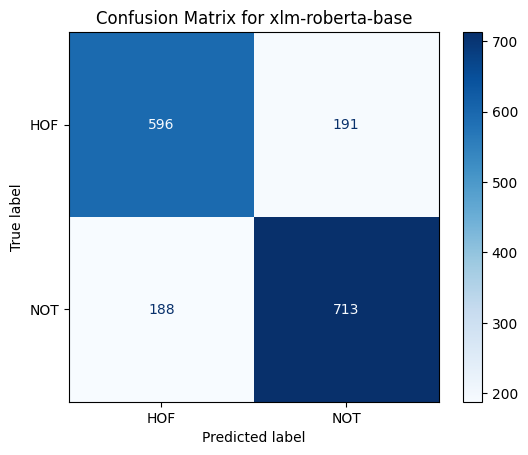

Map:   0%|          | 0/1688 [00:00<?, ? examples/s]

<ipython-input-24-6c3ee72e9cc0>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Evaluating distilbert-base-multilingual-cased on test set...



Classification Report:
              precision    recall  f1-score   support

         HOF       0.72      0.78      0.75       787
         NOT       0.80      0.74      0.77       901

    accuracy                           0.76      1688
   macro avg       0.76      0.76      0.76      1688
weighted avg       0.76      0.76      0.76      1688



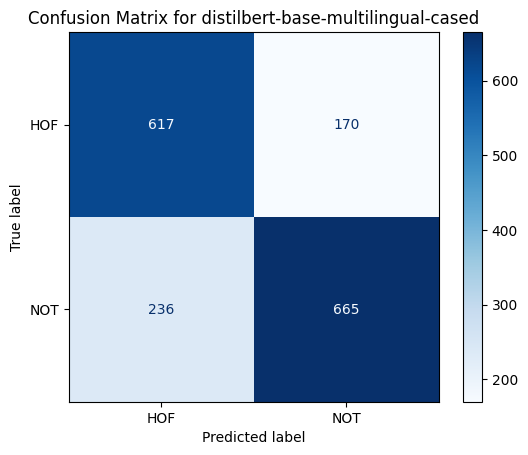

Map:   0%|          | 0/1688 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Evaluating ai4bharat/indic-bert on test set...


<ipython-input-24-6c3ee72e9cc0>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Classification Report:
              precision    recall  f1-score   support

         HOF       0.73      0.78      0.75       787
         NOT       0.79      0.75      0.77       901

    accuracy                           0.76      1688
   macro avg       0.76      0.76      0.76      1688
weighted avg       0.76      0.76      0.76      1688



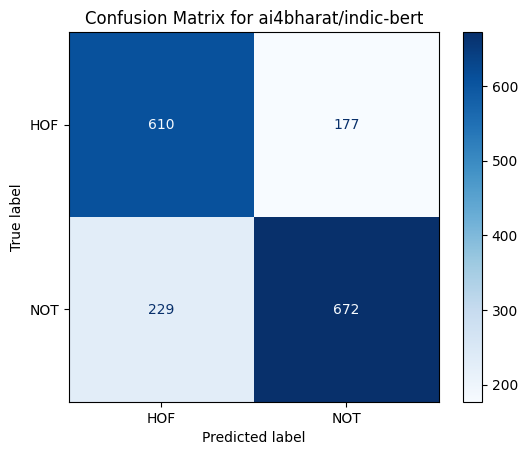

In [ ]:
# Run evaluation for all models on the test set
test_results_all = []
for model_name in models:
    result = evaluate_on_test_set(model_name, raw_test_ds, le.classes_.tolist())
    test_results_all.append(result)

### Visual Model Comparison

This graph was created using Excel, hence why the code is absent.

<img src="https://i.imgur.com/WoPFmgm.png" width="1500">

*Figure 1. Comparison of three multilingual transformer models (XLM-RoBERTa, DistilBERT, IndicBERT) on validation F1, test F1, and overall accuracy. XLM-RoBERTa shows the highest validation performance and maintains strong generalisation on the test set.*


# Potential Improvements

### Preprocessing Enhancements

- **Emoji & Emoticon Handling**:  
  The current pipeline removes all non-alphanumeric characters, including emojis, which often carry sentiment cues. Integrating an emoji lexicon or translating emojis to textual equivalents could help preserve emotional context.

- **Slang Normalisation**:  
  Incorporating a Hinglish or slang normaliser, especially for code-mixed Hindi-English tweets, would improve consistency in informal expressions.

- **Spelling Correction**:  
  Tweets often contain typographical or phonetic spelling errors. Adding a lightweight spell-correction mechanism could reduce vocabulary fragmentation.

- **Stopword Retention for Transformers**:  
  Since transformer models rely on contextual attention, removing stopwords may be unnecessary or even harmful. Retaining them might preserve important sentence structure cues.

- **Language Detection Refinement**:  
  The current use of Devanagari script detection can be extended using a full language identification model (e.g., `langdetect`) to better distinguish code-switched or Romanised Hindi tweets.

---

### Modelling Enhancements

- **Data Augmentation Diversification**:  
  Beyond back-translation, using transformer-based paraphrasing models like PEGASUS or T5 can further enrich the training corpus with semantically diverse samples.

- **Model Ensembling**:  
  Combining predictions from multiple models (e.g., XLM-RoBERTa + IndicBERT) using majority voting or weighted averaging could increase robustness across language and style variance.

- **Domain-Adaptive Pretraining**:  
  Fine-tuning on a larger corpus of Hindi-English social media data before task-specific training can help the model better understand domain-specific syntax and slang.

- **Class-Specific Loss Functions**:  
  Techniques like **focal loss** or enhanced **label smoothing** can further mitigate class imbalance and penalise misclassifications of underrepresented labels.

- **Token-Level Feature Integration**:  
  Including additional cues such as hashtag density, punctuation frequency, or uppercase ratio (via multi-modal input or concatenated embeddings) could help capture latent patterns missed by text alone.

---

Implementing these improvements could enhance generalisation, robustness to noisy or informal text, and classification performance across diverse linguistic inputs.
